In [1]:
from pyexpat import features

#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, ConvLSTM1D, Flatten, Dense, Conv1D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow.keras.regularizers import l2

import shap
from tqdm import tqdm
# Surpressing Warnings
import warnings
import tensorflow as tf

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
# Suppress Keras UserWarning about input shape in RNN layers
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Suppress statsmodels ValueWarning about no frequency information
warnings.filterwarnings("ignore", category=ValueWarning, module='statsmodels')

# Suppress statsmodels ConvergenceWarning about optimization failure
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

# Suppress statsmodels FutureWarning about optimization failure
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

# To suppress all TensorFlow warnings
# warnings.filterwarnings('ignore', category=tf.errors.UserWarning)
warnings.filterwarnings('ignore', message="6 out of the last .* calls to .* triggered tf.function retracing.*", category=UserWarning)



# Loading Transformed Data

In [2]:

file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
all_series_HICP_target_dir = "AllSamplesHICPtarget/"
all_Series_CPI_target_dir = "AllSamplesCPItarget/"
targetCpi = "CPI"

df_cpi_target = pd.read_csv(filepath_or_buffer = t_Data_Dir + 'full_cpi_target_data_norm.csv', index_col = 0)
df_cpi_target.index.name = 'DATE' # Set the name of the index


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


# Column Definitions

In [190]:
# main variables columns
main_vars_cols = pd.read_csv('combined2' + '.csv', header=1, skiprows=[0], index_col = 0).columns.tolist()

# CPI acf/pacf lags columns
cpi_pacf_lags = list(range(1, 13))
cpi_acf_extra_lags = [23, 24, 25, 35, 36, 37]
all_cpi_lags = sorted(set(cpi_pacf_lags + cpi_acf_extra_lags))
cpi_acf_pacf_lag_cols = [f'CPI_L{lag}' for lag in all_cpi_lags]

# CPI VAE columns
vae_cpi_cols = ['z1', 'z2', 'z3', 'z4', 'z5', 'CPI']


# Feature up to 3 lags columns
feature_3_lags_cols = []
for var in main_vars_cols:
    feature_3_lags_cols.append(var)
    for lag in range(1, 4): # Lags 1, 2, 3
        feature_3_lags_cols.append(f'{var}_L{lag}')


# Utility Functions

In [191]:

sns.set_theme(style="whitegrid") # Apply seaborn visual theme

def plot_forecast(forecasted_series, actual_series, title_name='Forecasted vs Actual CPIAUCSL'):

    fig = plt.figure(figsize=(12, 6)) # Store figure object

    actual_series.index = pd.to_datetime(actual_series.index) # Try converting to DateTimeIndex

    plt.plot(actual_series.index, forecasted_series, label='Forecasted', color='#e41a1c', linestyle='dashed', linewidth=2) # Red for forecast
    plt.plot(actual_series.index, actual_series, label='Actual', color='#377eb8', linestyle='solid', linewidth=2) # Blue for actual

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.title(title_name, fontsize=12)

    # Date formatting for x-axis (using logic from your improved plot_series)
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate x-axis labels, adjust font size
    plt.gcf().autofmt_xdate() # Auto-format dates

    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout() # Adjust layout

    return fig # Return the figure object (do NOT use plt.show() here if you want to control display later)

def plot_observed_vs_fitted_var(var_model_fit, train_df, target_column='CPIAUCSL', title='VAR Model - Observed vs Fitted (Training)'):

    fitted_values = var_model_fit.fittedvalues # Get fitted values from the VAR model
    observed_train = train_df[target_column]   # Observed values from the training data

    # Extract fitted values for the target column
    fitted_cpiauscl = fitted_values[target_column]

    # Ensure index is DateTimeIndex if possible (align with actual_series index if needed)
    try:
        fitted_cpiauscl.index = pd.to_datetime(fitted_cpiauscl.index)
        observed_train.index = pd.to_datetime(observed_train.index) # Align observed index too for plotting
        if not fitted_cpiauscl.index.equals(observed_train.index): # If indexes still not the same, try to align based on actual index
            fitted_cpiauscl.index = observed_train.index # Force index alignment for plotting if possible
    except ValueError:
        print("Warning: Could not convert index to DateTime for Observed vs Fitted plot.")
        pass # Plot without DateTimeIndex if conversion fails

    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_cpiauscl.index, fitted_cpiauscl, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator() # Use observed_train index for locator
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predictions(y_actual, y_pred, train_index, title='CNN-LSTM: Actual vs Forecasted Values'):
    """Plots actual vs forecasted values."""
    train_index = pd.to_datetime(train_index)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_index, y_actual, label='Actual', color='blue', linestyle='solid')
    plt.plot(train_index, y_pred, label='Forecasted', color='red', linestyle='dashed')

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title, fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_loss(history):
    # Plots loss function
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM - Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

def plot_observed_vs_fitted(y_train, predictions_train, train_index):
    fig = plt.figure(figsize=(12, 6))
    train_index = pd.to_datetime(train_index)
    plt.plot(train_index, y_train, label="Observed (Train)", linestyle="solid")
    plt.plot(train_index, predictions_train, label="Fitted (Train)", linestyle="solid")
    plt.title("CNN-LSTM - Observed vs. Fitted Values")

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_arima_observed_vs_fitted(arima_model_fit, train_data, target_column, title='ARIMA Model - Observed vs Fitted (Training)'):
    """
    Plots observed vs fitted values for an ARIMA model on the training data,
    handling cases where fittedvalues might not have an index and ensuring index alignment.
    Includes enhanced index debugging.
    """

    observed_train = train_data[target_column] if isinstance(train_data, pd.DataFrame) else train_data # Handle DataFrame or Series input for train_data
    fitted_series = arima_model_fit.fittedvalues    # Ensure only train data is plotted (if fittedvalues has more values)

    num_values_to_keep = observed_train.index.shape[0]
    fitted_series_train = fitted_series[:num_values_to_keep]

    fitted_series_reduced = pd.Series(fitted_series_train, index=observed_train.index)

    # Extract fitted values for the target column
    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_series_reduced.index, fitted_series_train, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    return fig


# CPI

# Creating Train and Test Data

In [416]:
df = df_cpi_target[main_vars_cols]
target = "CPI"

In [417]:

test_size = int(len(df) * 0.2)  # Convert percentage to absolute count
# test_size = 12  # Convert percentage to absolute count
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

print(train_df.shape)
print(test_df.shape)


(218, 21)
(54, 21)


# VAR Model Training & Testing
Given that we need more observations than parameters. A rough formula:

Required observations > lag_order × num_variables²

We need to reduce the maxlags or number of variables.


In [194]:

model = VAR(train_df)

# AIC based lag order (your original code)
lag_order_aic = model.select_order(maxlags=5).aic
print(f"AIC-based Lag Order: {lag_order_aic}")

# BIC based lag order
lag_order_bic = model.select_order(maxlags=5).bic
print(f"BIC-based Lag Order: {lag_order_bic}")

# HQIC based lag order
lag_order_hqic = model.select_order(maxlags=5).hqic
print(f"HQIC-based Lag Order: {lag_order_hqic}")

# Choose the lag order based on the criteria you prefer or by comparing performance with different lag orders.
var_lag_order = lag_order_aic # or lag_order_bic, or lag_order_hqic
var_model = model.fit(var_lag_order)
print(var_lag_order)

# var_model.summary()


AIC-based Lag Order: 5
BIC-based Lag Order: 0
HQIC-based Lag Order: 1
5


In [195]:

def var_forecast(model, train_df, test_df, lag_order, forecast_horizon):

    input_data = train_df.values[-lag_order:]
    forecast = model.forecast(y=input_data, steps=forecast_horizon)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # -------------------------------
    # EVALUATE ON TARGET
    # -------------------------------
    actual_cpi = test_df[target]
    forecasted_cpi = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))

    abs_err = np.abs(actual_cpi.values - forecasted_cpi.values)
    # print(f"Abs Err: {abs_err}")

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return model, forecasted_cpi, actual_cpi, train_df, mae, rmse



# ***Results***


Mean Absolute Error (MAE): 0.7446753151025556
Root Mean Squared Error (RMSE): 0.975673462969918


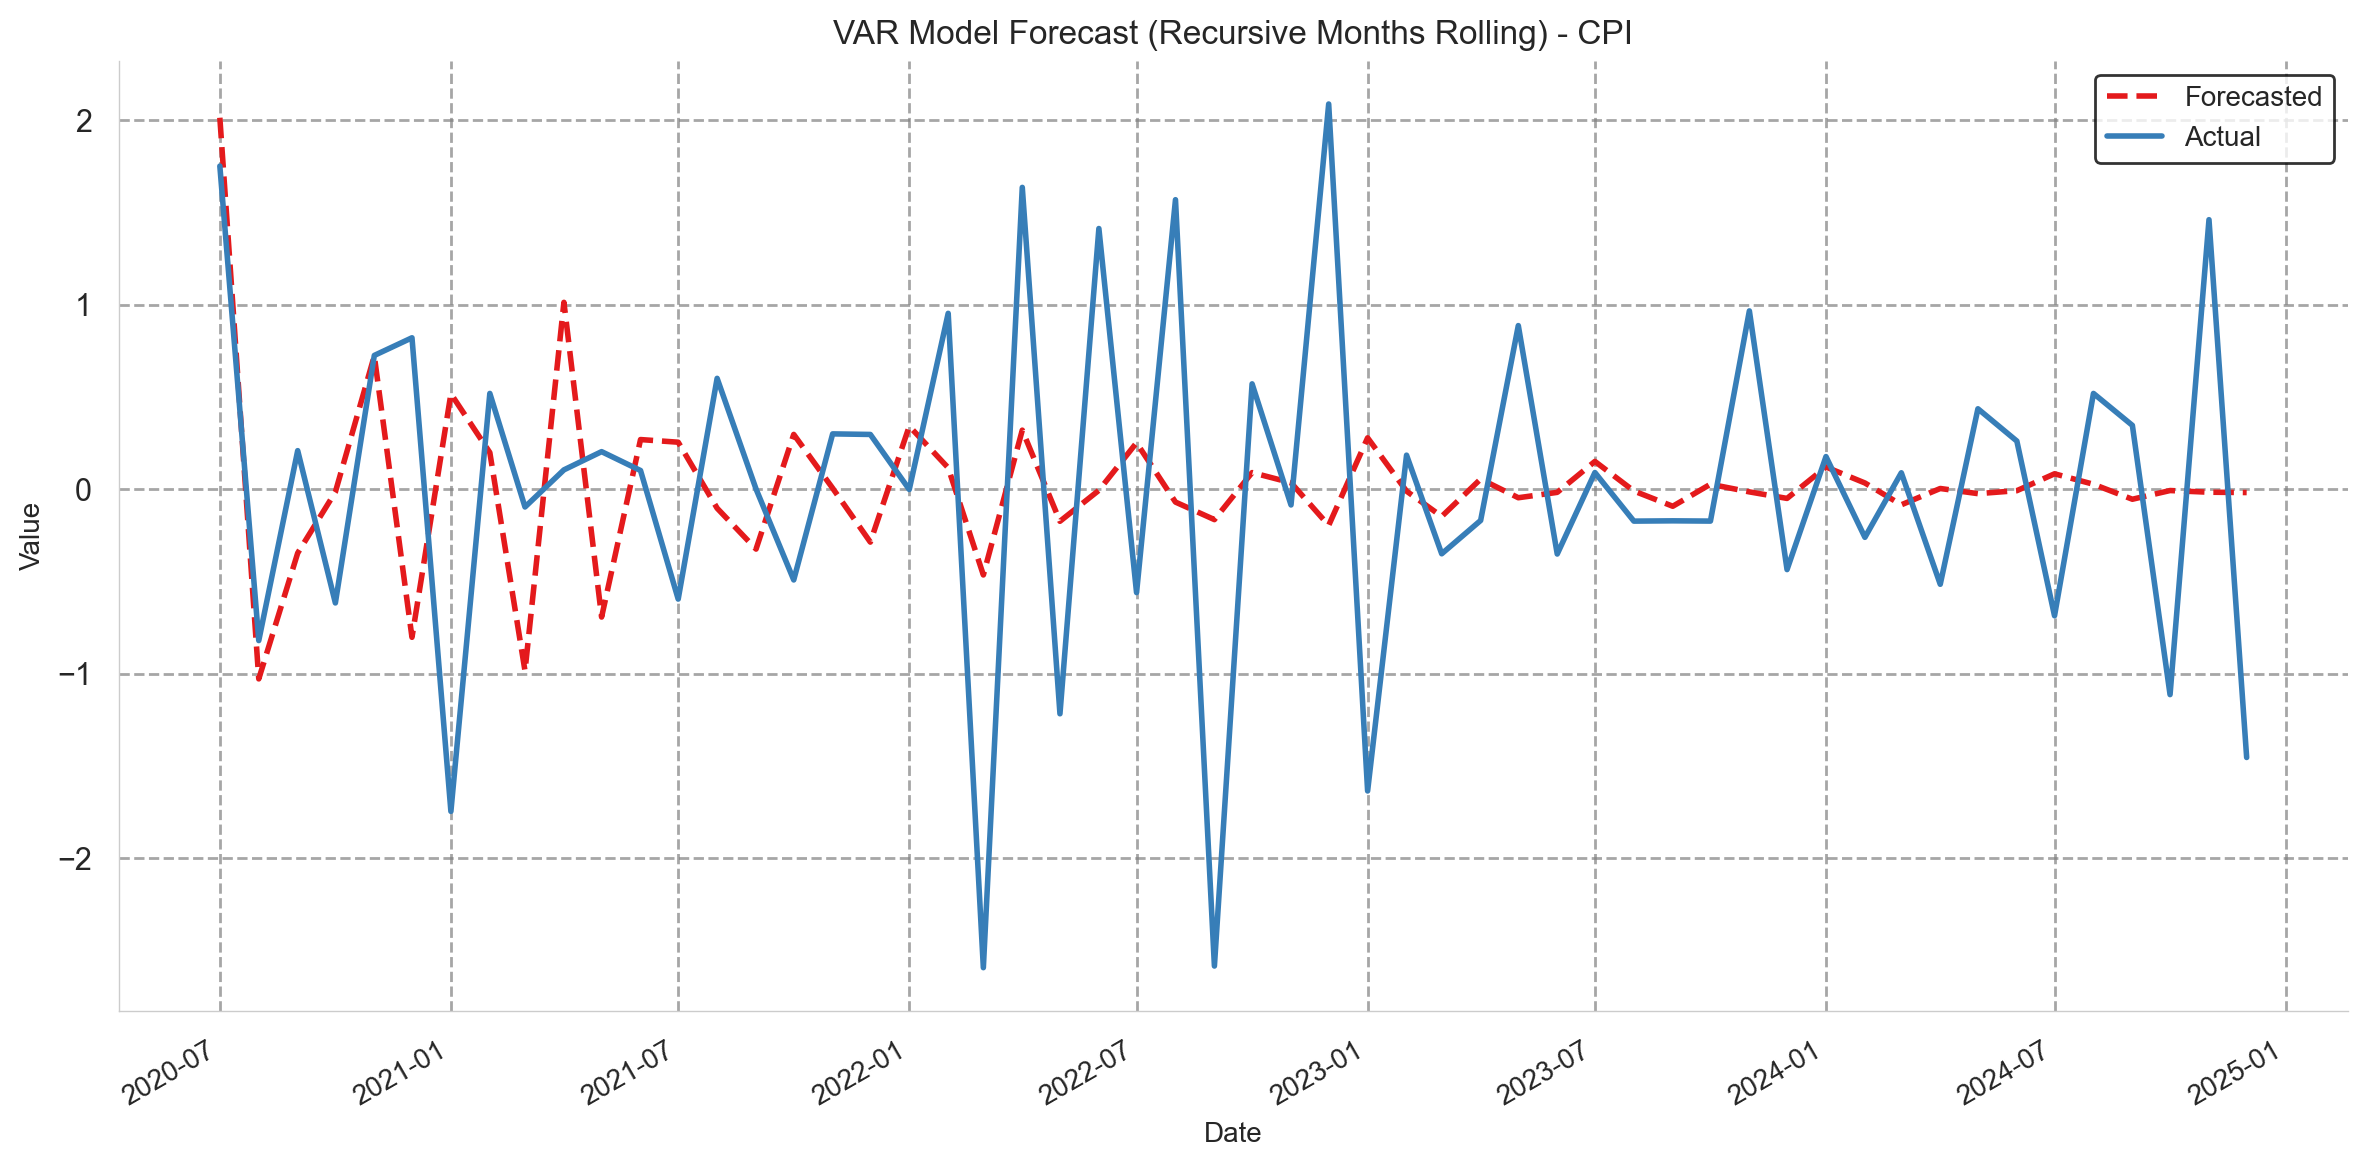

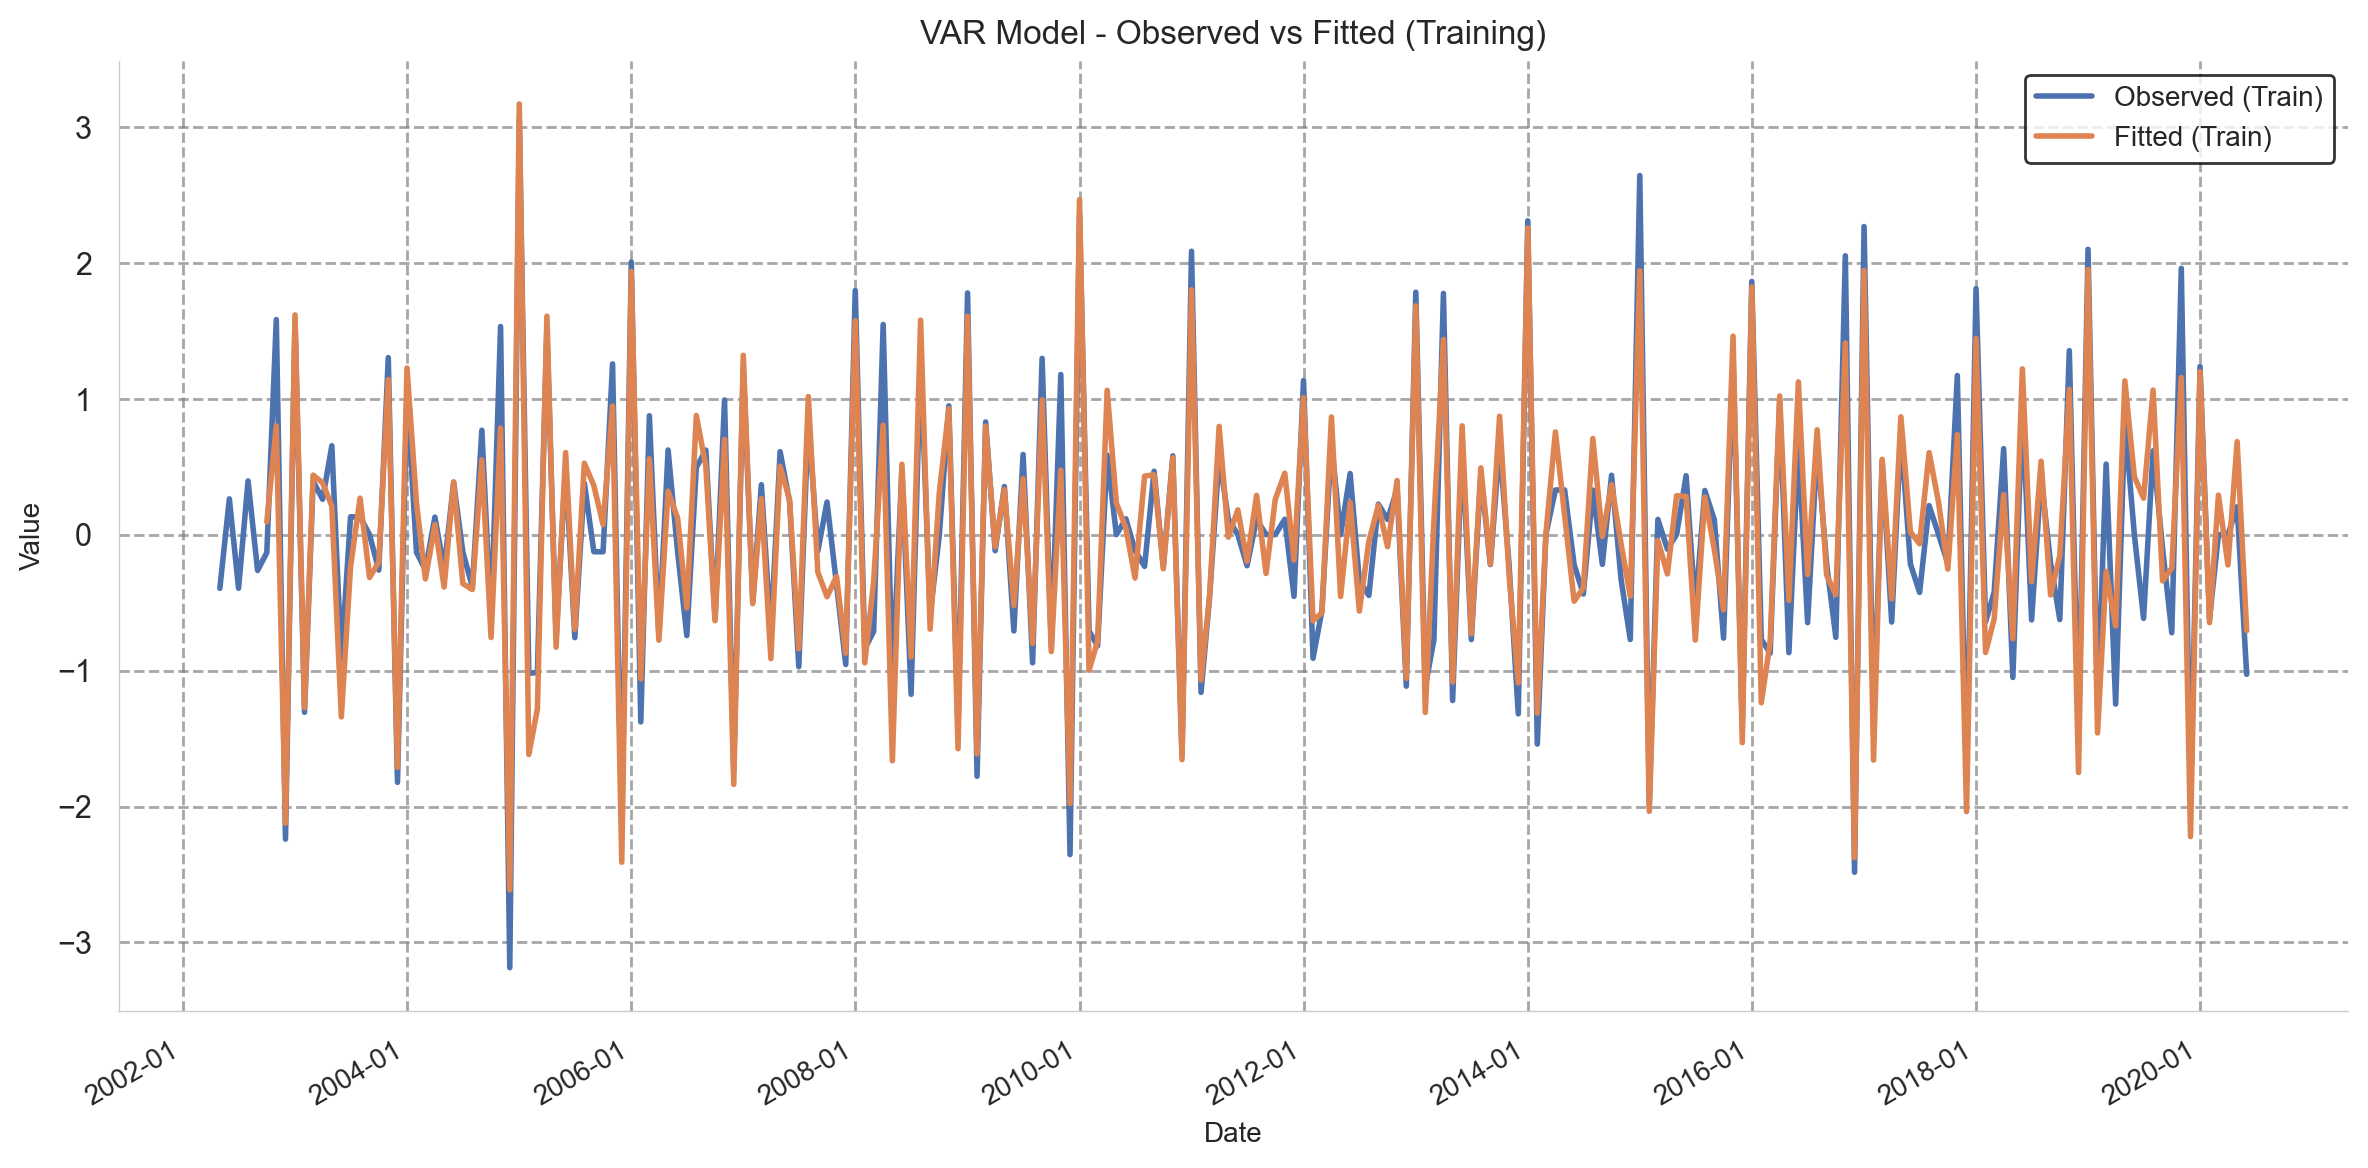

In [196]:
# # Forecast the next 12 months
model, forecasted_cpi, actual_cpi, var_train_df, var_mae, var_rmse = var_forecast(var_model, train_df.copy(), test_df.copy(), var_lag_order, test_size)
var_model_forecast_plot = plot_forecast(forecasted_cpi, actual_cpi, title_name='VAR Model Forecast (Recursive Months Rolling) - CPI')
var_observed_vs_fitted_plot = plot_observed_vs_fitted_var(model, var_train_df, target, 'VAR Model - Observed vs Fitted (Training)')


# ***ARIMA Training and Test***

In [197]:
# Extract CPI series for ARIMA
train_cpi_arima = train_df.copy()[target]
test_cpi_arima = test_df.copy()[target]

In [198]:

def arima_mm_forecast(train_df, test_df, auto_arima_model, forecast_horizon, title='ARIMA: Observed vs Fitted (24 Months Rolling)', target_column=target):
    """
    Performs a rolling multi-step-ahead ARIMA forecast for the entire test dataset.

    Parameters:
    - train_df (pd.DataFrame): Training data
    - test_df (pd.DataFrame): Test data
    - target_column (str): The target variable for evaluation (default 'CPIAUCSL')
    - steps (int): Number of steps ahead for each rolling forecast

    Returns:
    - forecast_df (pd.DataFrame): Forecasted values for the entire test period
    - mae (float): Mean Absolute Error
    - rmse (float): Root Mean Squared Error
    """

    # Extract target series
    train_series = train_df[target_column]
    test_series = test_df[target_column]

    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()

    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Build output DataFrame
    forecast_index = test_series.index[:forecast_horizon]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:forecast_horizon]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))

    print(f"ARIMA Model - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"ARIMA Model - Root Mean Squared Error (RMSE): {rmse:.4f}")

    # # Generate and display plots
    # print("Absolute Error")
    # abs_error = np.abs(actual_series.values - forecast_df[target].values)
    # print(abs_error)

    plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_arima_observed_vs_fitted(model_fit, train_df, target_column=target_column, title=title) # Pass target_column

    plt.show()  # Display plots
    return forecast_df, mae, rmse


In [199]:
# For ARIMA order selection (non-seasonal):
auto_arima_model_arima = auto_arima(train_cpi_arima, seasonal=False, stepwise=True,
                                    suppress_warnings=True, error_action="ignore", max_order=10, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=220.087, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=633.393, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=443.241, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=386.344, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=224.736, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=254.752, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=275.042, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=224.109, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=253.561, Time=0.02 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 0.641 seconds


# Results

ARIMA Model - Mean Absolute Error (MAE): 0.6548
ARIMA Model - Root Mean Squared Error (RMSE): 0.9123


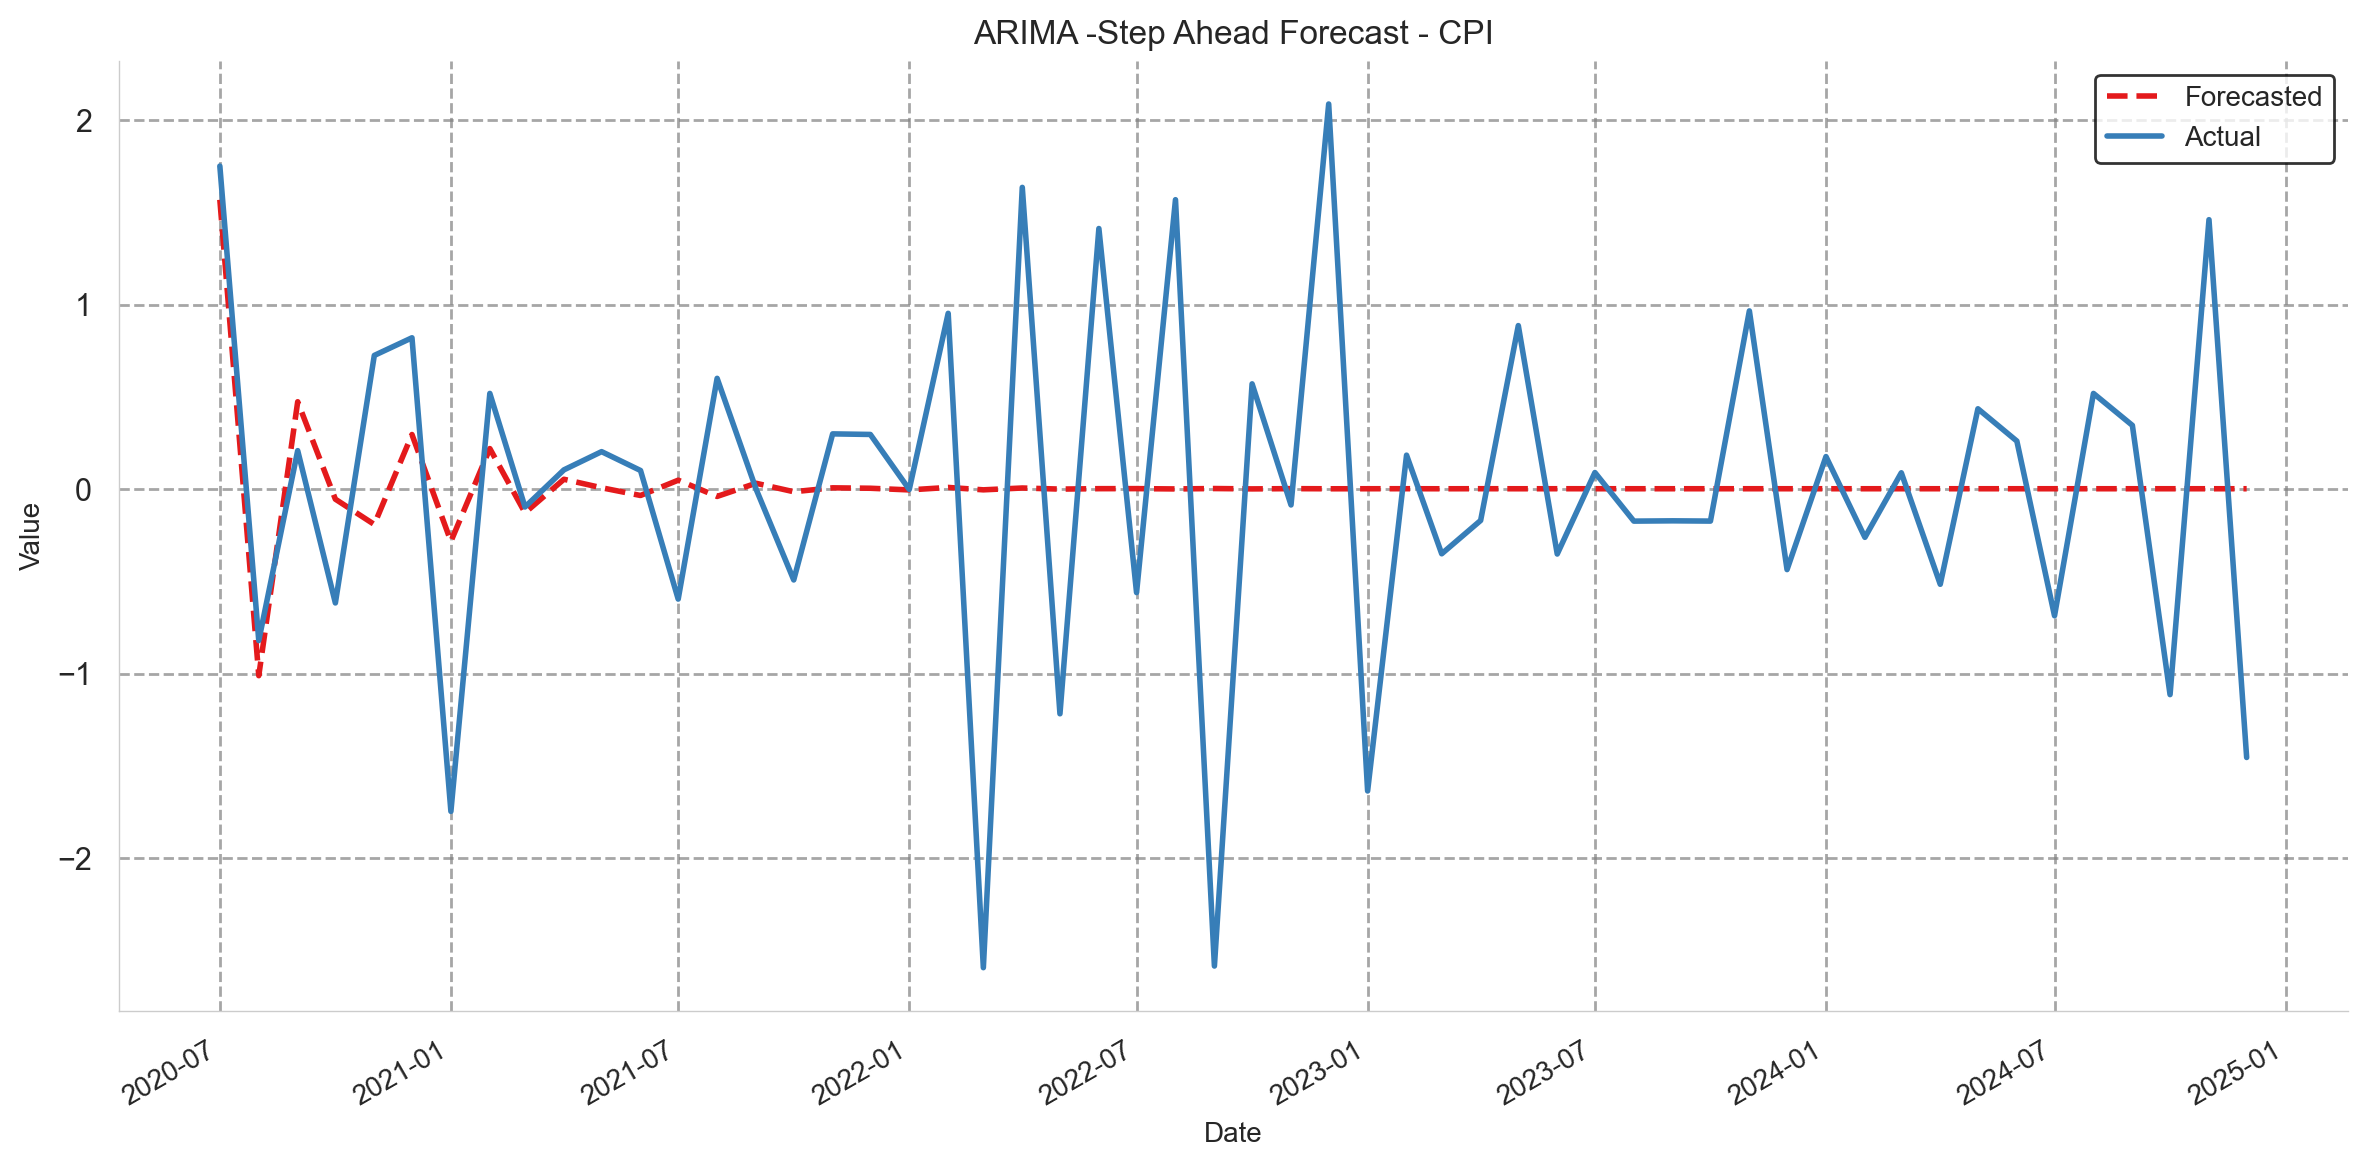

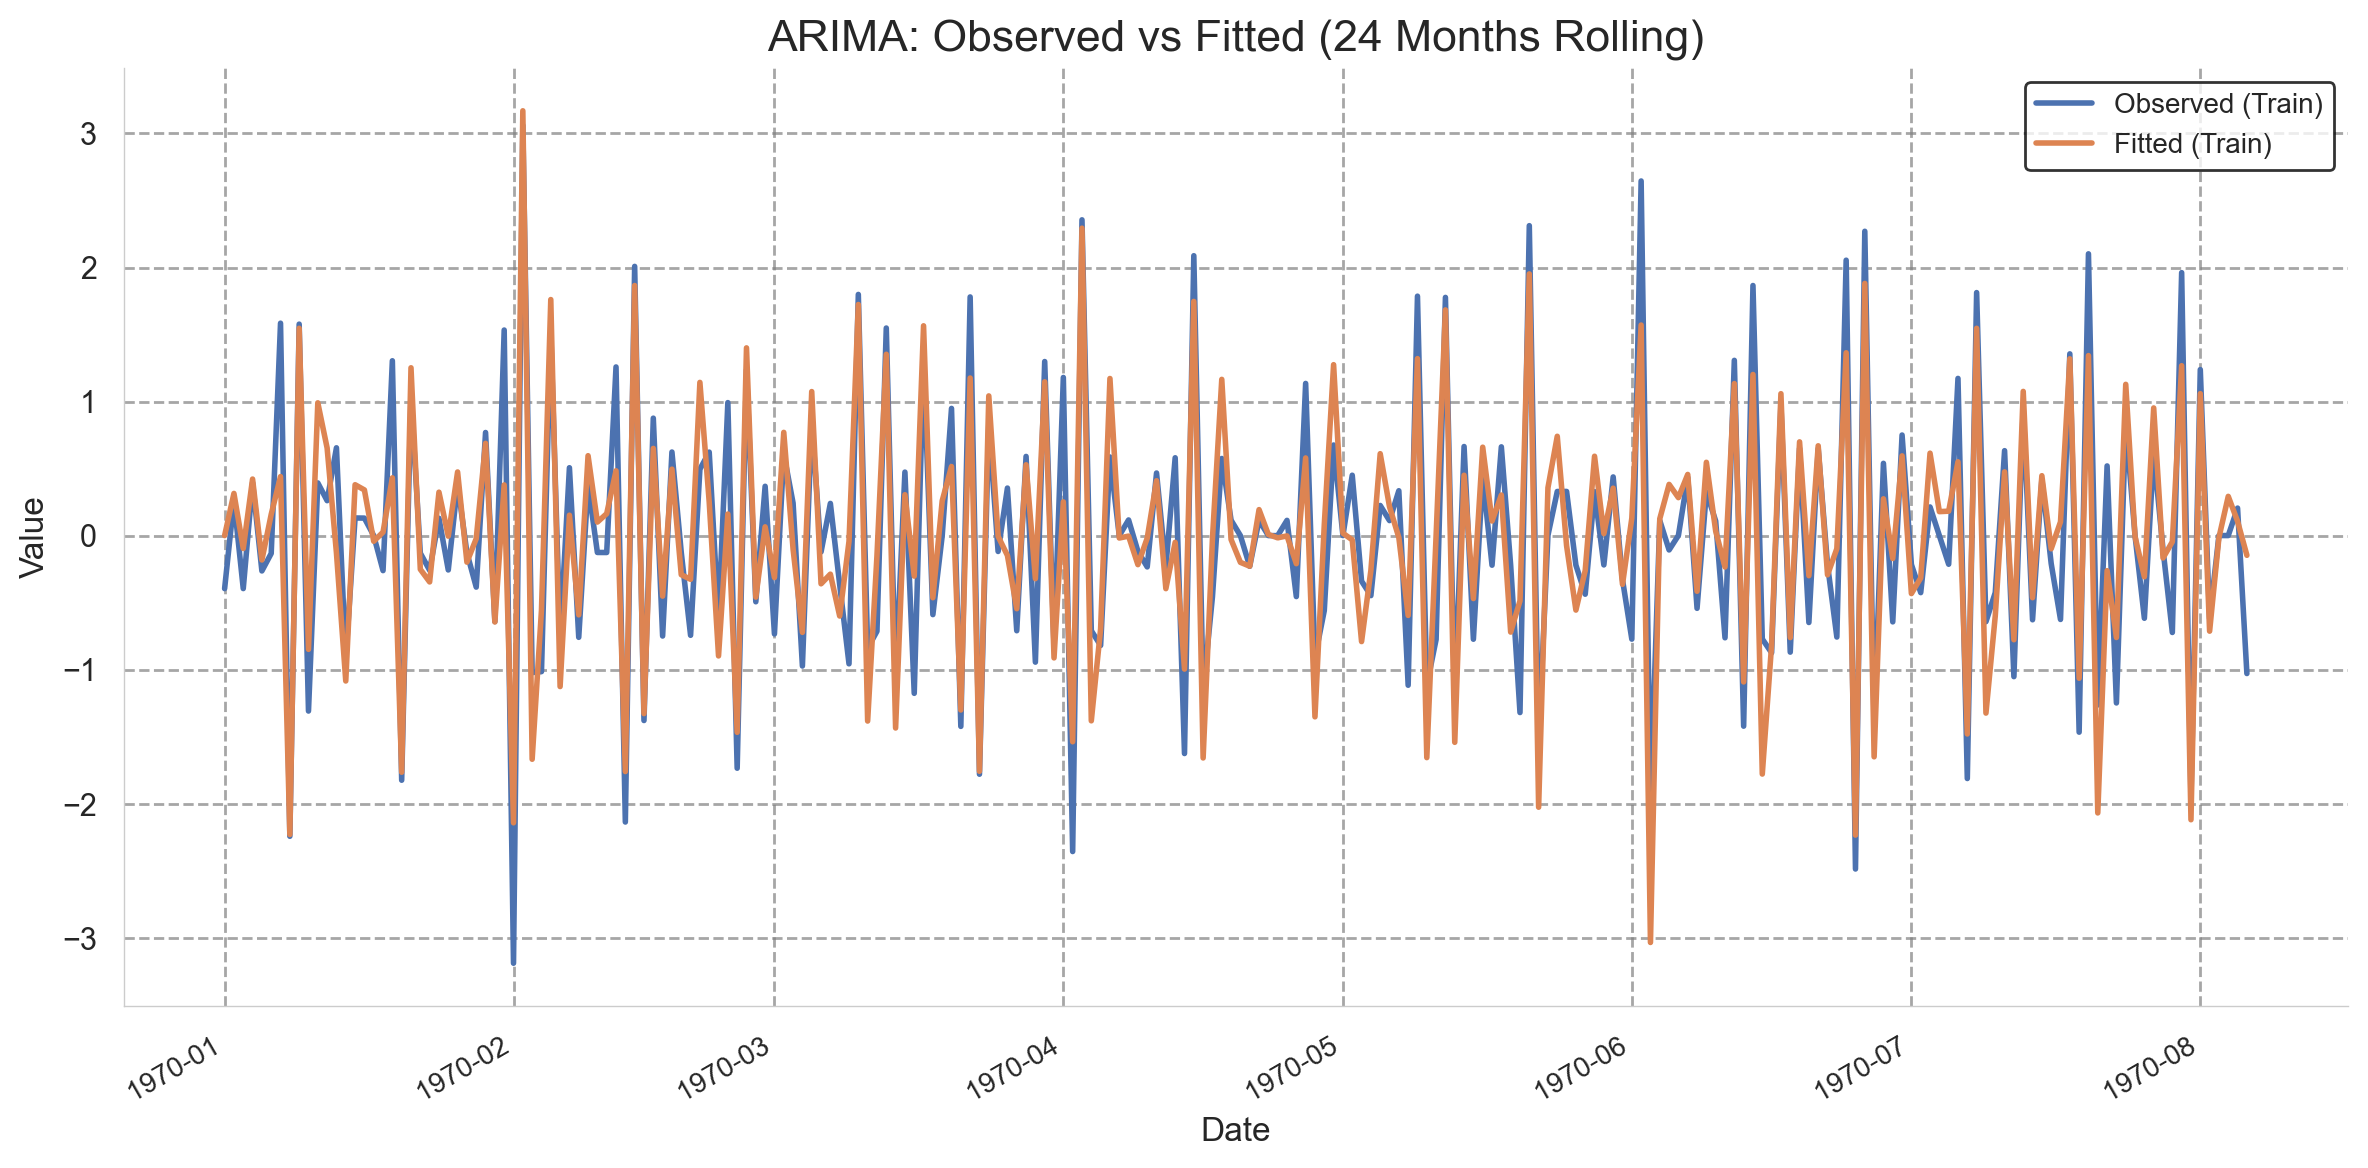

In [200]:
arima_forecast_df, arima_mae, arima_rmse = arima_mm_forecast(train_df, test_df, auto_arima_model_arima, test_size)

# ***SARIMA Training & Test***


In [201]:
# For SARIMA order selection (seasonal):
train_cpi_sarima = train_df[target]
auto_arima_model_sarima = auto_arima(train_cpi_sarima, seasonal=True, m=12, stepwise=True, # m=12 for monthly seasonality
                                     suppress_warnings=True, error_action="ignore", max_order=10, trace=True,
                                     max_p=10, max_q=10, max_P=10, max_Q=10, verbose=0) # Limit search space


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=143.153, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=635.390, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=334.893, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=633.393, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=204.653, Time=0.29 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=140.304, Time=0.99 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=158.656, Time=0.76 sec
 ARIMA(2,0,2)(3,0,1)[12] intercept   : AIC=135.026, Time=2.08 sec
 ARIMA(2,0,2)(3,0,0)[12] intercept   : AIC=131.036, Time=2.16 sec
 ARIMA(2,0,2)(4,0,0)[12] intercept   : AIC=133.955, Time=4.18 sec
 ARIMA(2,0,2)(4,0,1)[12] intercept   : AIC=135.039, Time=4.12 sec
 ARIMA(1,0,2)(3,0,0)[12] intercept   : AIC=87.367, Time=1.56 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC

In [202]:

def sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size, target_column=target):

    # Extract CPI series for ARIMA
    train_cpiauscl_arima = train_df[target_column]
    test_cpiauscl_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_cpiauscl_arima.index = pd.to_datetime(train_cpiauscl_arima.index)

    history = train_cpiauscl_arima.tolist()
    sarima_model = SARIMAX(history,
                          order=auto_arima_model_sarima.order,
                          seasonal_order=auto_arima_model_sarima.seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)

    forecast_df = pd.DataFrame(forecast, index=test_cpiauscl_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpiauscl_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpiauscl_arima, forecast_df[target_column]))

    # Print evaluation metrics
    print(f'Rolling SARIMA Model - Mean Absolute Error (MAE): {mae_sarima:.4f}')
    print(f'Rolling SARIMA Model - Root Mean Squared Error (RMSE): {rmse_sarima:.4f}')

    # Plot the forecast and the fitted model
    print("DETAILS")
    print(forecast_df.shape)
    print(test_cpiauscl_arima.shape)
    print(sarima_model_fit.fittedvalues.shape)
    sarima_forecast = plot_forecast(forecast_df, test_cpiauscl_arima, title_name='Rolling SARIMA Model Forecast - CPI')
    sarima_fitted = plot_arima_observed_vs_fitted(sarima_model_fit, train_df, target_column=target_column, title='SARIMA Model - Observed vs Fitted (24 Months Rolling)')
    plt.show()

    return sarima_forecast, mae_sarima, rmse_sarima



# Result

Rolling SARIMA Model - Mean Absolute Error (MAE): 0.8807
Rolling SARIMA Model - Root Mean Squared Error (RMSE): 1.2524
DETAILS
(54, 1)
(54,)
(218,)


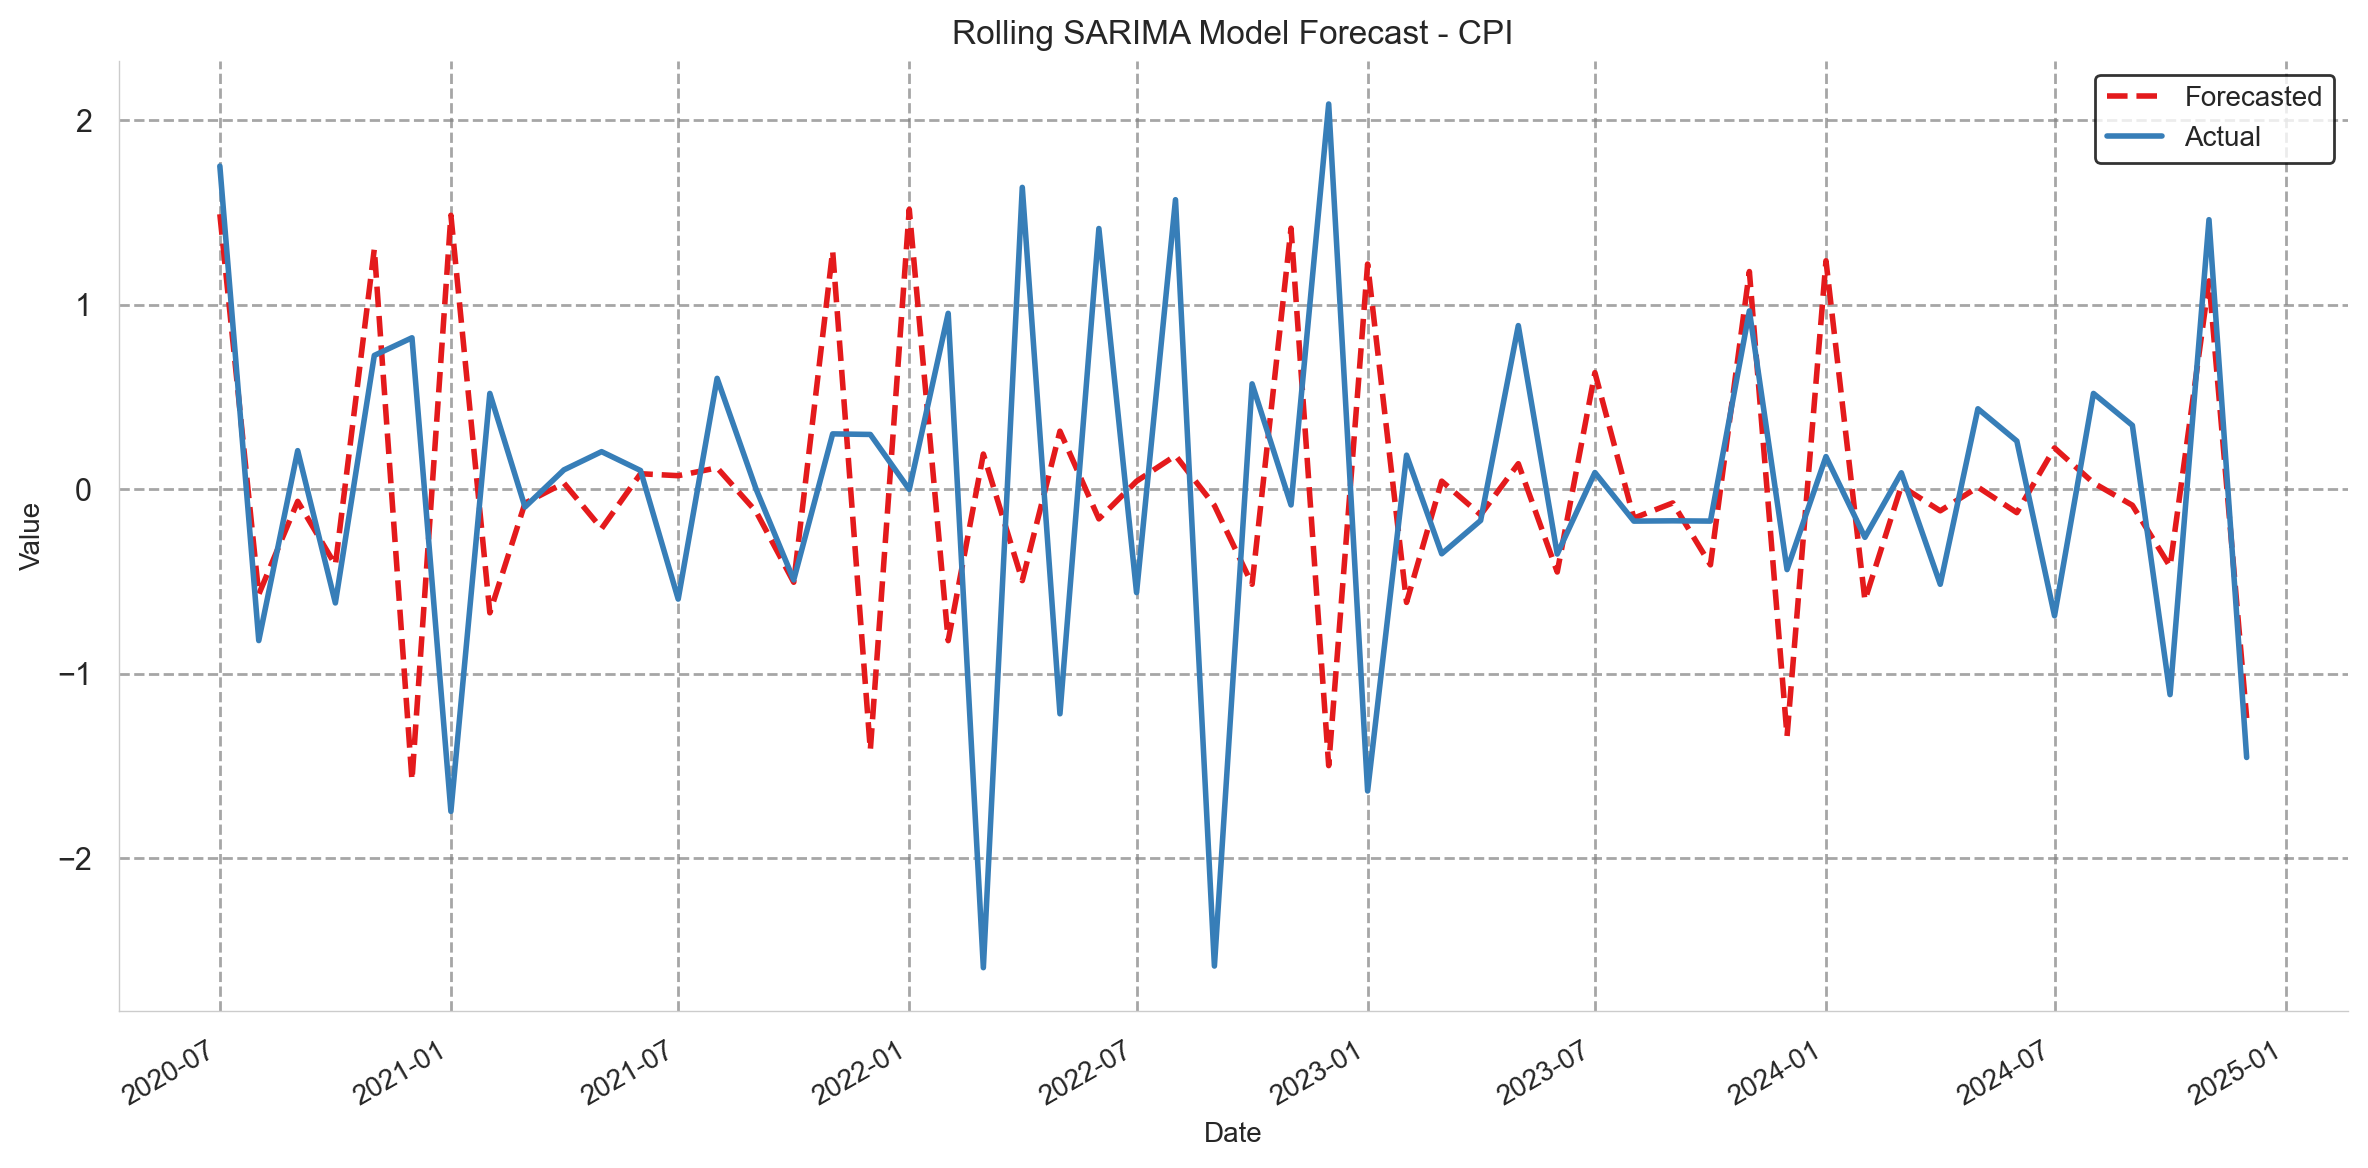

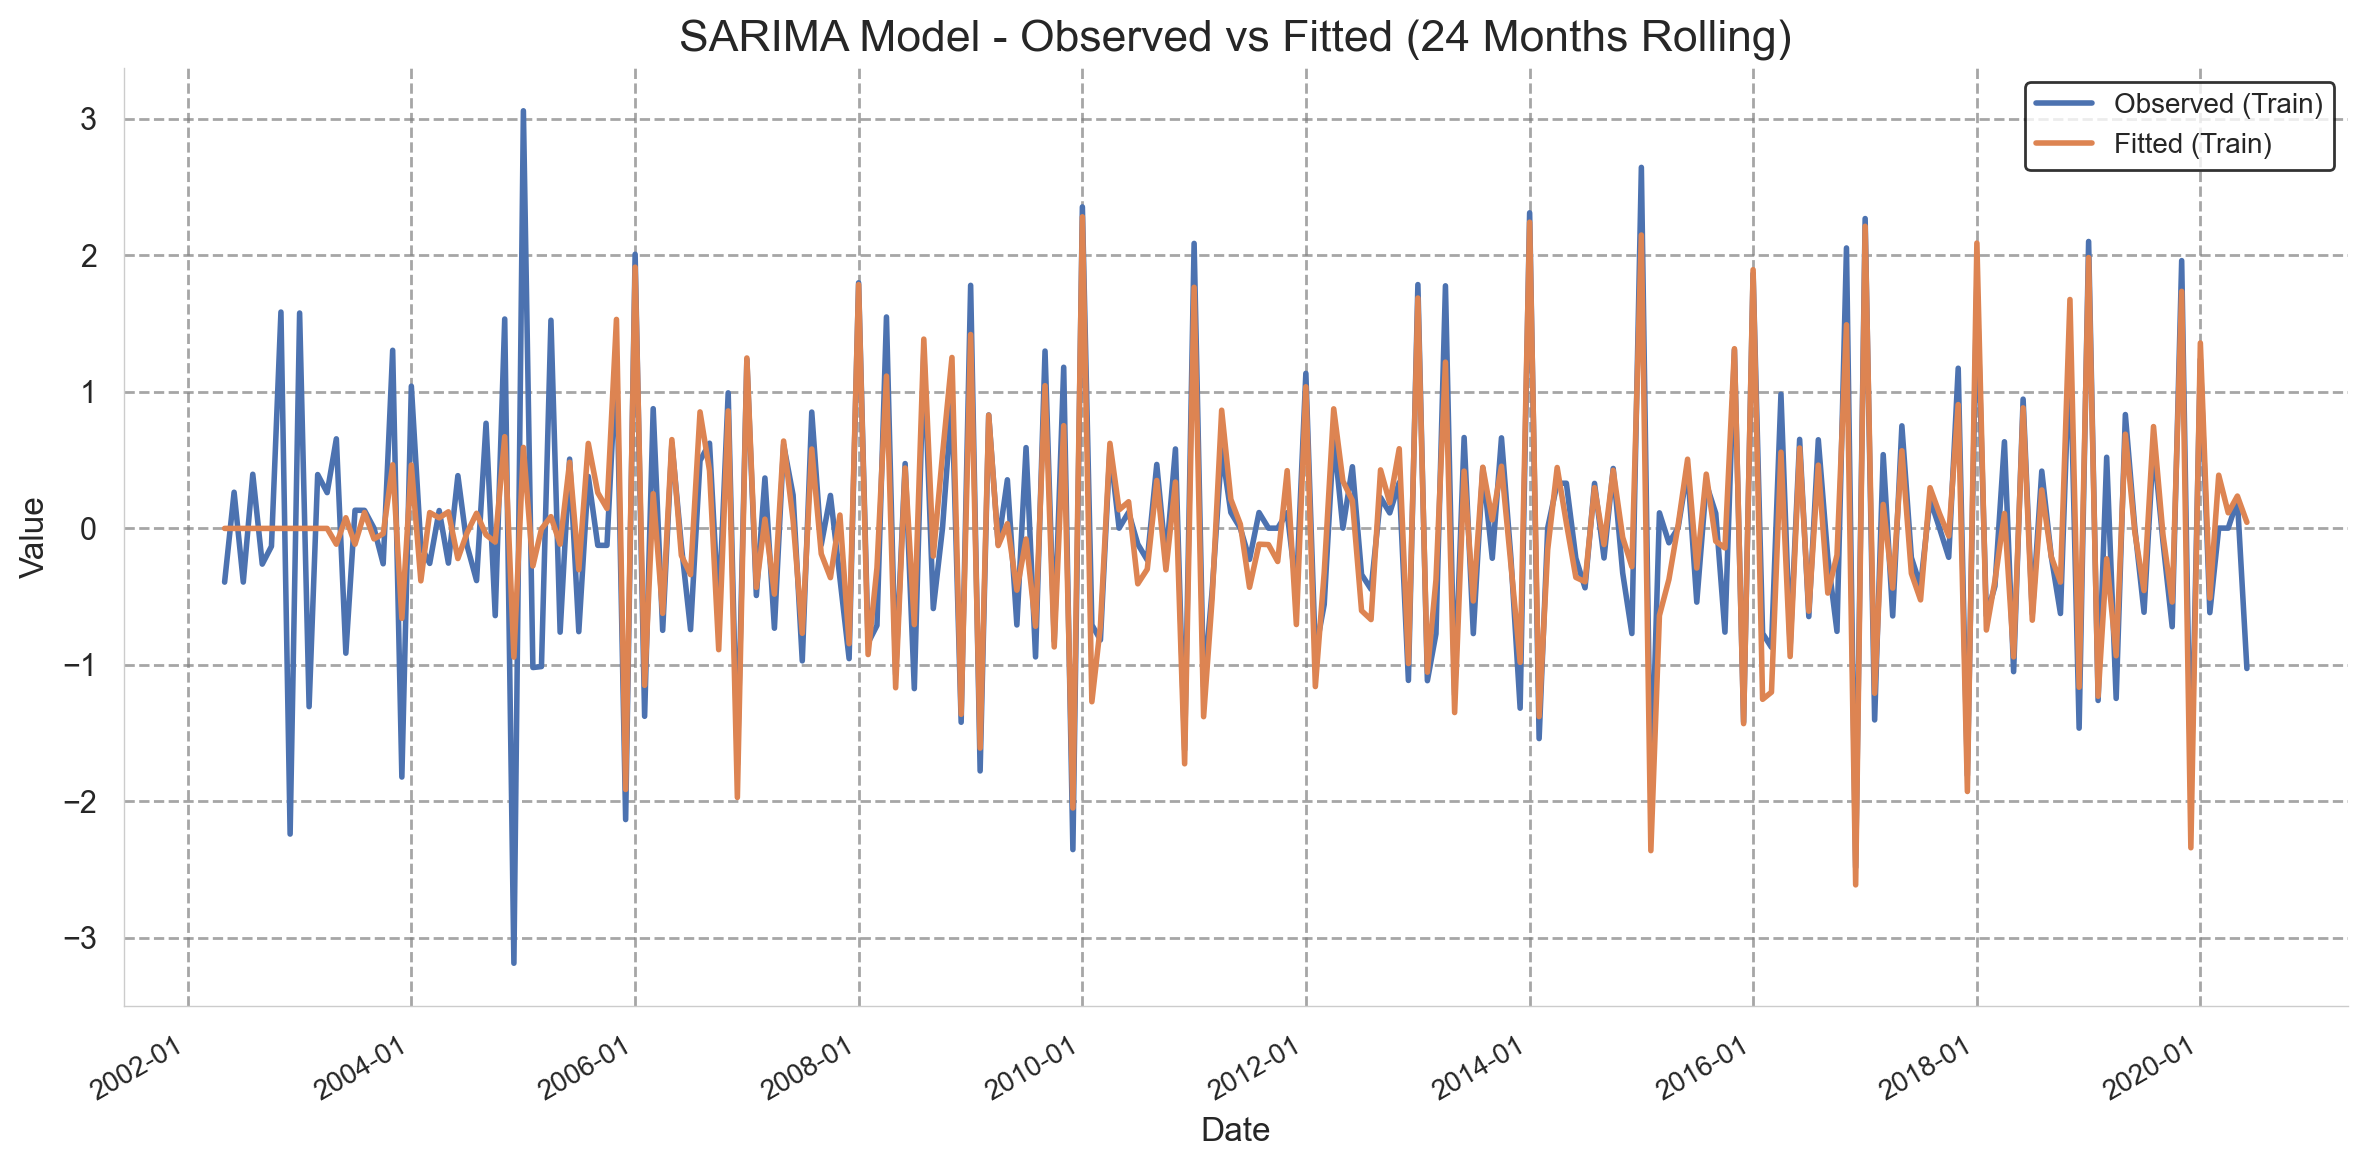

In [203]:

sarima_forecast, sarima_mae, sarima_rmse = sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size)


# ***CNN-LSTM Training & Testing***

In [418]:

def prepare_data_convlstm2D(data, target_column, test_size, sequence_length=3, grid_shape=(5, 4)):
    """
    Prepares the data for ConvLSTM2D using temporal sequences and reshapes features into spatial grids.
    """
    feature_names = [col for col in data.columns if col != target_column]
    total_features = len(feature_names)
    rows, cols = grid_shape
    grid_size = rows * cols
    assert grid_size >= total_features, f"Grid shape {grid_size} is too small for number of features {total_features}."

    # Padding mask
    # def pad_features(features):
    #     padded = np.zeros((features.shape[0], grid_size))
    #     padded[:, :features.shape[1]] = features
    #     return padded.reshape(features.shape[0], rows, cols, 1)
    def pad_features_to_grid(features, rows, cols):
        padded_grid = np.zeros((features.shape[0], rows, cols, 1))
        for t in range(features.shape[0]):
            for idx, val in enumerate(features[t]):
                r, c = divmod(idx, cols)
                padded_grid[t, r, c, 0] = val
        return padded_grid

    # Generate sequences
    X, y, indices = [], [], []
    for i in range(len(data) - sequence_length):
        seq_x = data.iloc[i:i+sequence_length][feature_names].values
        seq_y = data.iloc[i + sequence_length - 1][target_column]
        X.append(seq_x)
        y.append(seq_y)
        indices.append(data.index[i + sequence_length])

    X = np.array(X)  # shape: (samples, timesteps, features)
    y = np.array(y).reshape(-1, 1)
    indices = np.array(indices)

    # Normalize
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_flat = X.reshape(-1, total_features)
    X_scaled = scaler_X.fit_transform(X_flat).reshape(X.shape)
    y_scaled = scaler_y.fit_transform(y)
    # X_scaled = X
    # y_scaled = y

    # Reshape for ConvLSTM2D: (samples, timesteps, rows, cols, channels)
    X_reshaped = np.array([
        # pad_features_to_grid(sample) for sample in X_scaled
        pad_features_to_grid(sample, rows, cols) for sample in X_scaled
    ])  # shape: (samples, timesteps, rows, cols, 1)

    # Split train/test
    X_train = X_reshaped[:-test_size]
    y_train = y_scaled[:-test_size]
    X_test = X_reshaped[-test_size:]
    y_test = y_scaled[-test_size:]
    train_index = indices[:-test_size]
    test_index = indices[-test_size:]

    # Input shape for ConvLSTM2D layer
    input_shape = X_reshaped.shape[1:]  # (timesteps, rows, cols, channels)

    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names, input_shape

# def prepare_data_conv_1D(data, target_column, test_size):
#     data_x = data.copy()
#     train_df = data_x.iloc[:-test_size]
#     test_df = data_x.iloc[-test_size:]
#     train_index = train_df.index
#     test_index = test_df.index
#
#     feature_names_used = data_x.drop(target_column, axis=1).columns.tolist()
#     X_train = train_df.drop(target_column, axis=1).values
#     y_train = train_df[target_column].values.reshape(-1, 1)
#     X_test = test_df.drop(target_column, axis=1).values
#     y_test = test_df[target_column].values.reshape(-1, 1)
#
#     # Initialize scalers
#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
#
#     # Fit scalers on training data only
#     X_train_scaled = scaler_X.fit_transform(X_train)
#     y_train_scaled = scaler_y.fit_transform(y_train)
#
#     # Transform test data
#     X_test_scaled = scaler_X.transform(X_test)
#     y_test_scaled = scaler_y.transform(y_test)
#
#     # Reshape for Conv1D: [samples, timesteps, features]
#     X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
#     X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
#     input_shape = (X_train.shape[1], X_train.shape[2])
#     return X_train, y_train_scaled, X_test, y_test_scaled, train_index, test_index, scaler_y, feature_names_used, input_shape


def prepare_data_conv_1D(data, target_column, test_size, timesteps=3):
    """
    Prepares data for Conv1D models with sliding window of specified timesteps.
    Returns scaled and reshaped train/test splits along with metadata.
    """
    data = data.copy()
    feature_names_used = data.drop(columns=target_column).columns.tolist()

    # Extract feature and target arrays
    X_all = data.drop(columns=target_column).values
    y_all = data[target_column].values.reshape(-1, 1)

    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_all_scaled = scaler_X.fit_transform(X_all)
    y_all_scaled = scaler_y.fit_transform(y_all)
    # X_all_scaled = X_all
    # y_all_scaled = y_all

    # Create sequences
    def create_sequences(X, y, timesteps):
        X_seq, y_seq = [], []
        for i in range(len(X) - timesteps + 1):
            X_seq.append(X[i:i+timesteps])
            y_seq.append(y[i+timesteps-1])  # target at the end of the window
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X_all_scaled, y_all_scaled, timesteps)

    # Adjusted split size due to sequence shortening
    adjusted_test_size = test_size
    adjusted_train_size = len(X_seq) - adjusted_test_size

    X_train = X_seq[:adjusted_train_size]
    y_train = y_seq[:adjusted_train_size]
    X_test = X_seq[-adjusted_test_size:]
    y_test = y_seq[-adjusted_test_size:]

    # Index tracking (optional)
    train_index = data.index[timesteps-1:timesteps-1 + adjusted_train_size]
    test_index = data.index[-adjusted_test_size:]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape



In [454]:

def build_model_convlstm2D(input_shape):
    """
    Builds and compiles a ConvLSTM2D model with input shape:
    (timesteps, rows, cols, channels)
    """
    model = Sequential([
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=True, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.003)),
        Dropout(0.3),
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=False, padding='same', kernel_regularizer=l2(0.003)),
        Dropout(0.3),
        Flatten(),
        # Dense(64, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_model_conv1D(input_shape):
    model = Sequential([
        Conv1D(filters=8, kernel_size=3, activation='tanh', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Conv1D(filters=8, kernel_size=3, activation='tanh', padding='same', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Flatten(),
        # Dense(32, activation='linear'),
        Dense(1)
    ])
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

def build_model_convlstm1D(input_shape):
    """Builds a hybrid CNN-LSTM model."""
    model = Sequential([
        Conv1D(filters=8, kernel_size=3, activation='tanh', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        LSTM(16, return_sequences=True),
        Dropout(0.5),
        Conv1D(filters=8, kernel_size=3, activation='tanh',padding='same', kernel_regularizer=l2(0.01)),
        # LSTM(8, return_sequences=True),
        Dropout(0.5),
        # LSTM(16),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_model(model, X_train, y_train, batch_size=16):
    """Trains the model with early stopping."""
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_dataset, epochs=600, callbacks=[early_stopping], verbose=0)
    return history

def evaluate_model(model, X_test, y_test, batch_size=16):
    """Evaluates the model and returns the test loss and predictions."""
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)
    loss = model.evaluate(test_dataset, verbose=0)
    predictions = model.predict(test_dataset, verbose=0)
    return loss, predictions

def inverse_transform(scaler, data):
    """Inverse transforms the scaled data."""
    return scaler.inverse_transform(data.reshape(-1, 1))

def model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))

    predictions_train = model.predict(X_train, verbose=0) # Predict on X_train
    predictions_train_actual = inverse_transform(scaler_y, predictions_train) # Inverse transform fitted values
    y_train_actual = inverse_transform(scaler_y, y_train) # Inverse transform y_train
    # --- Plot Observed vs Fitted on Training Data ---
    plot_cnn_forecast = plot_predictions(y_test_actual, predictions_actual, test_index)
    plot_cnn_obs_vs_fitted = plot_observed_vs_fitted(y_train_actual, predictions_train_actual, train_index) # Pass y_train_actual and predictions_train_actual
    print(f'Mean Absolute Error (MAE): {mae:.8f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.8f}')

    return model, X_train, X_test, mae, rmse



Variant CNN Models

In [455]:
def convlstm2D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size)
    model = build_model_convlstm2D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def conv1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=3)
    model = build_model_conv1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def convlstm1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=3)
    model = build_model_convlstm1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used


CNN 1D (C1D) No feature engineering

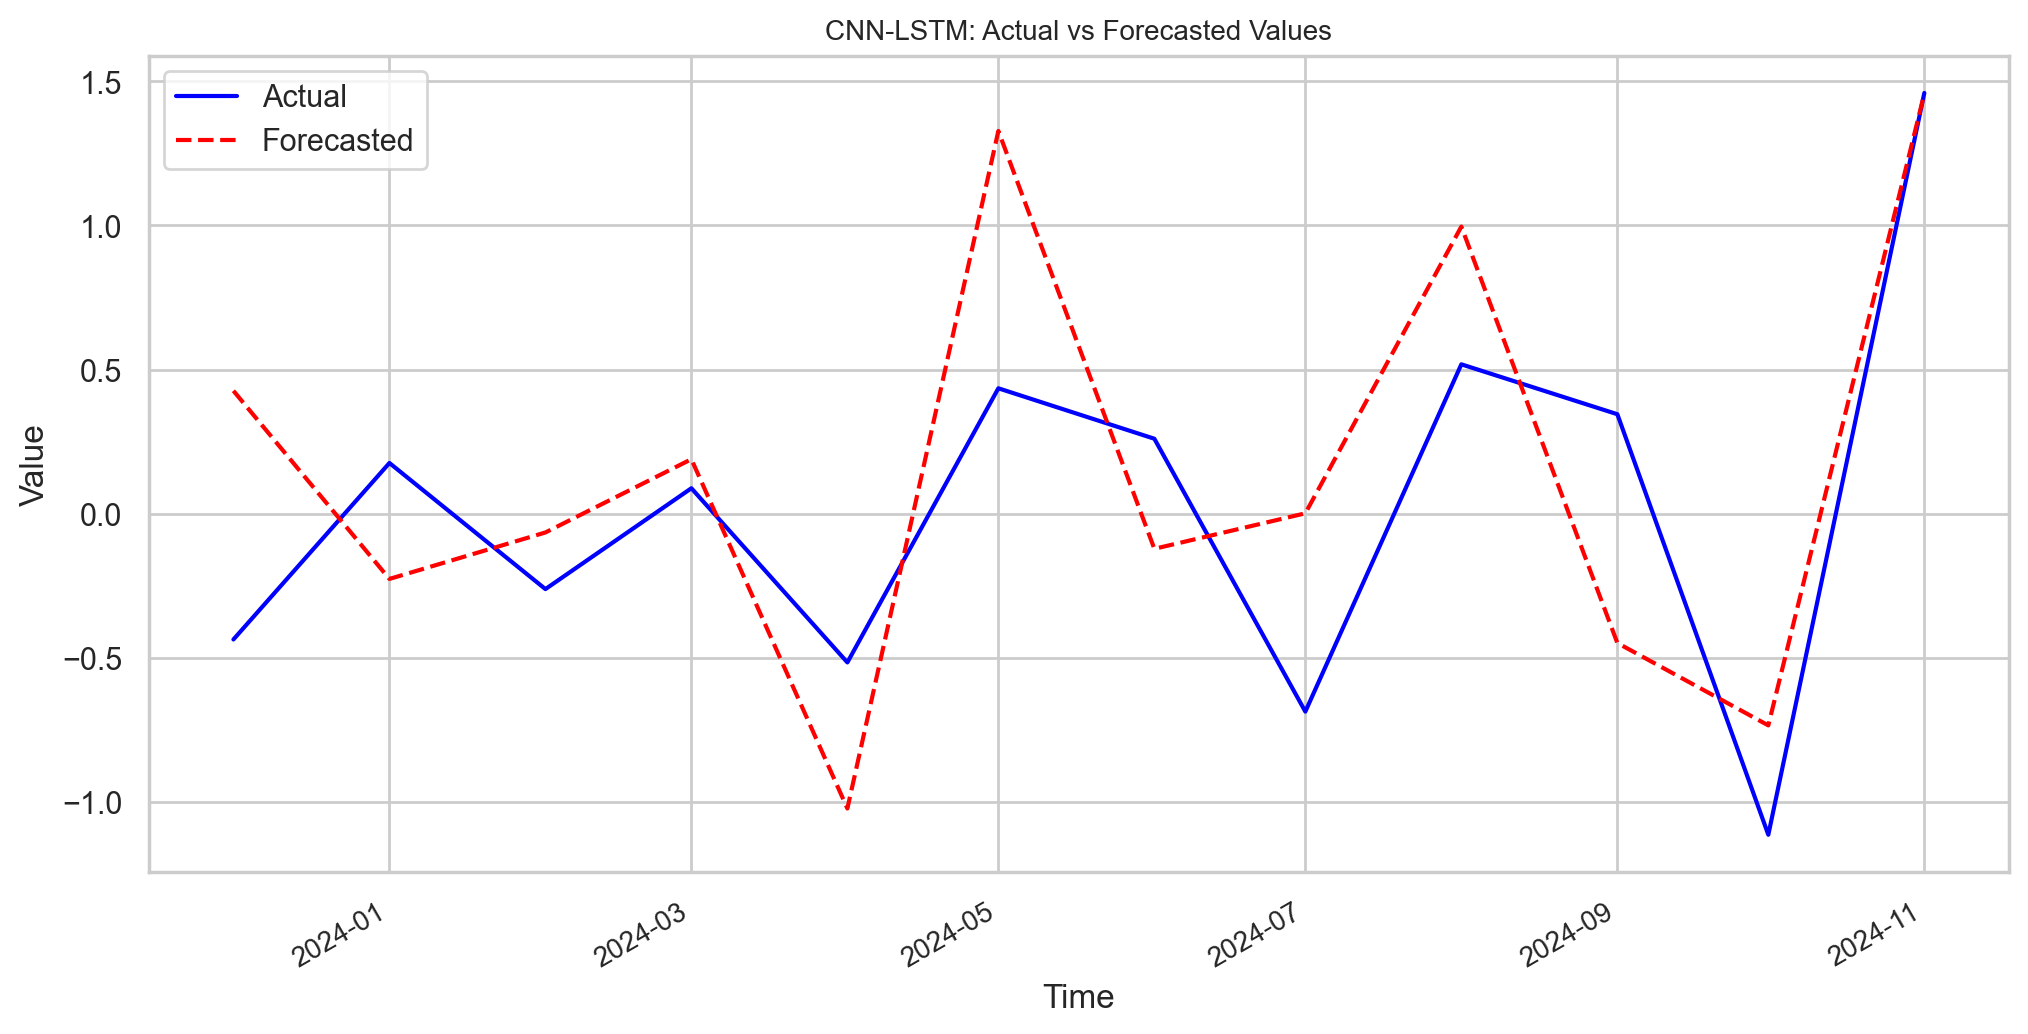

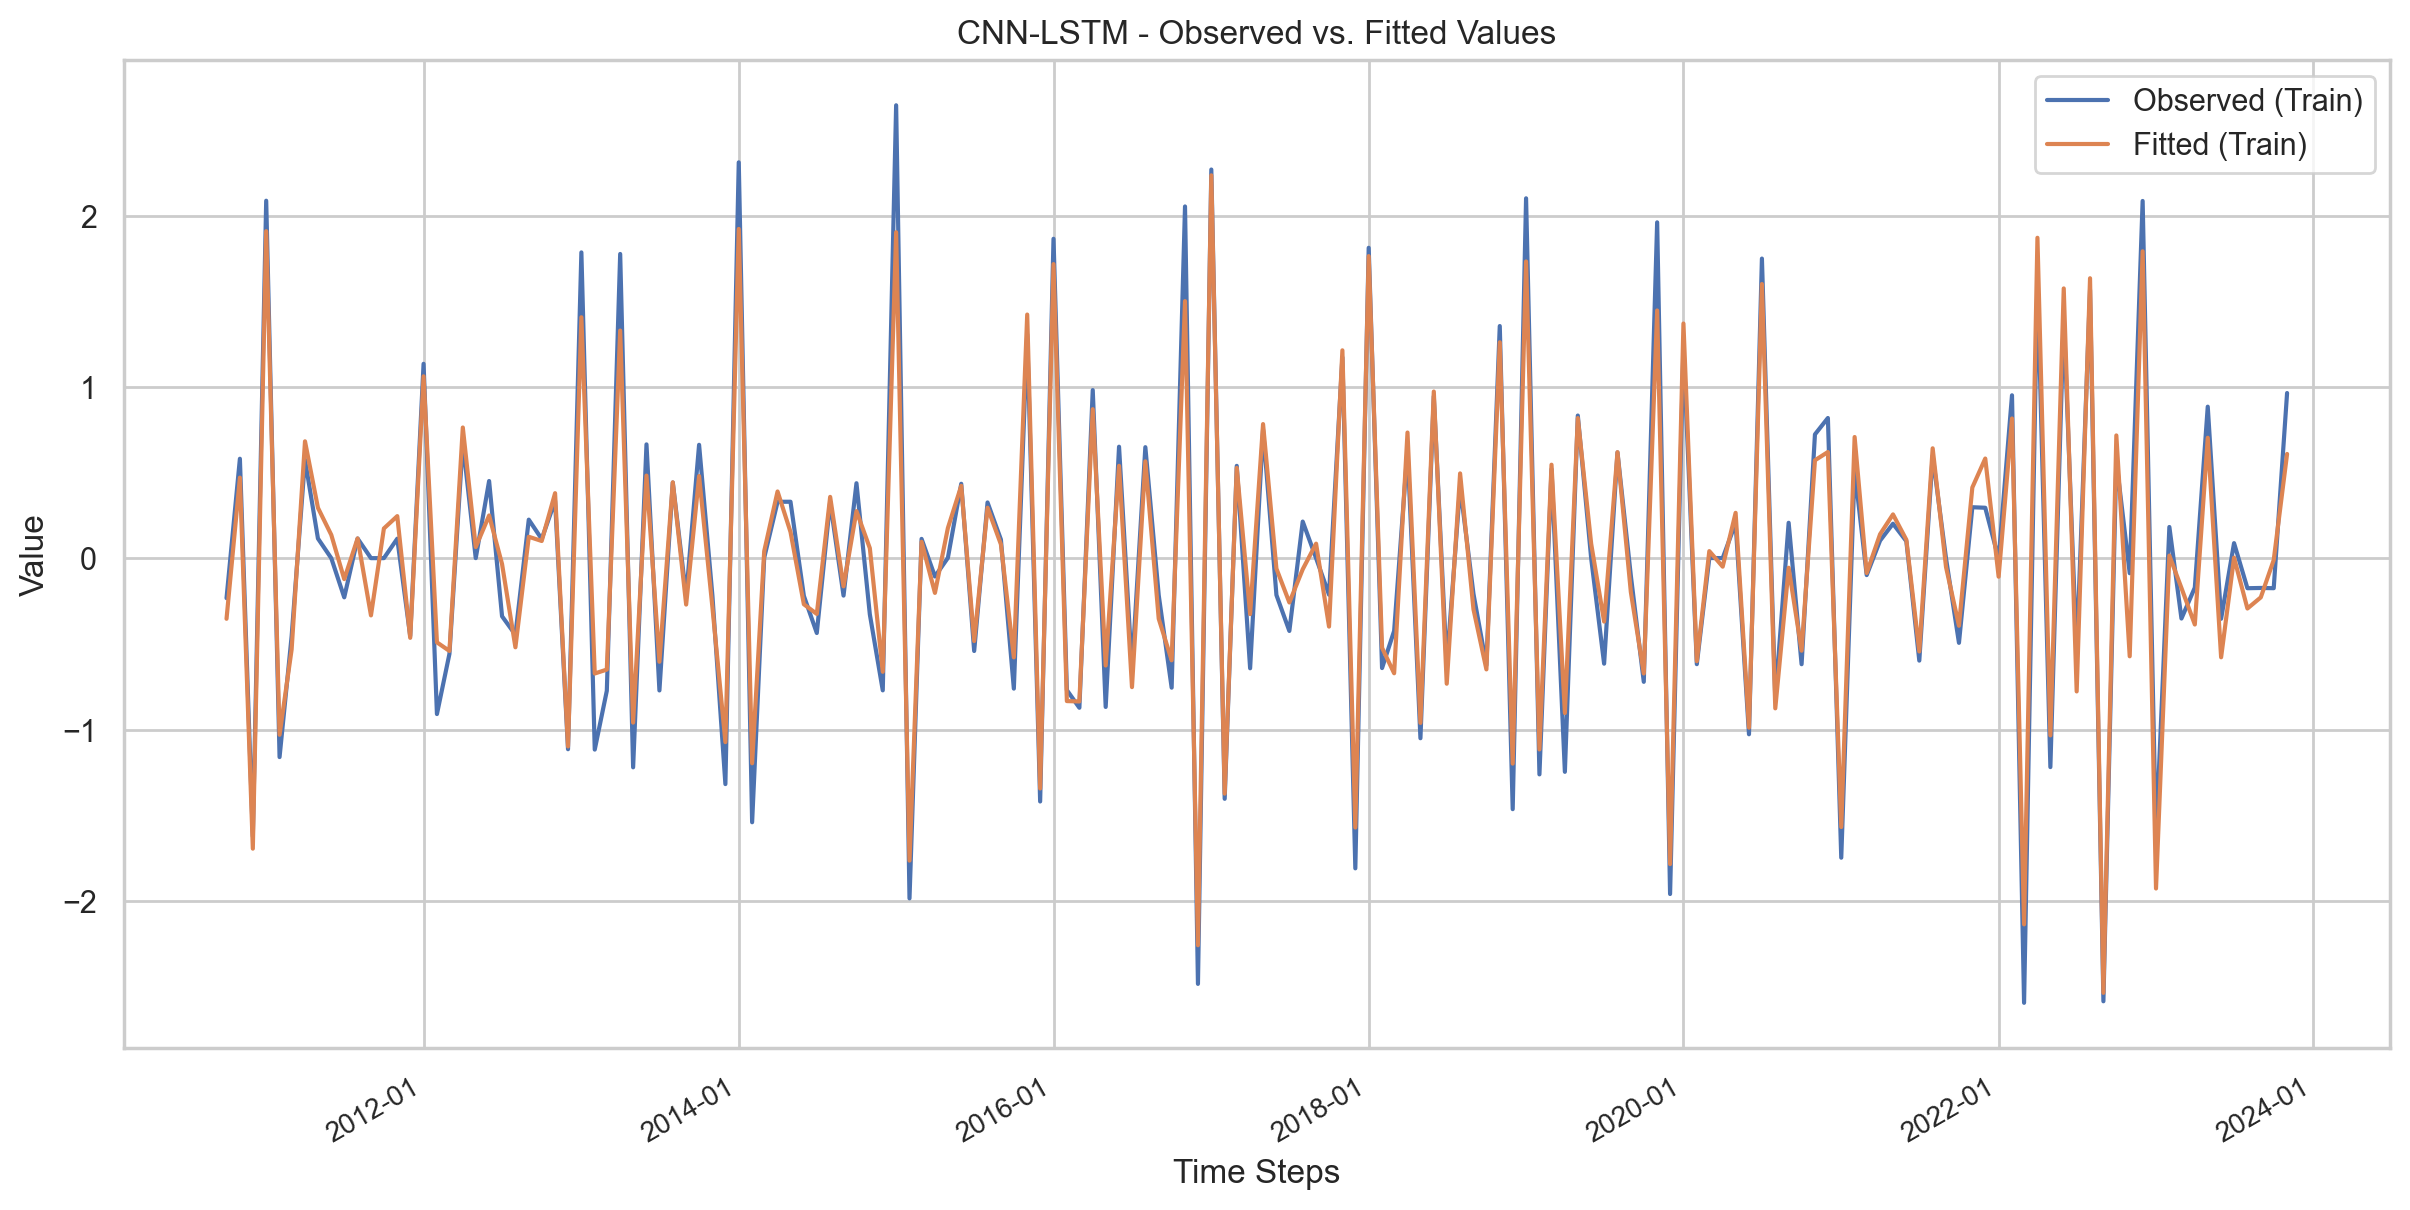

Mean Absolute Error (MAE): 0.47382420
Root Mean Squared Error (RMSE): 0.55011897


In [456]:
model_C1D_nfe, X_train_C1D_nfe, X_test_C1D_nfe, mae_C1D_nfe, rmse_C1D_nfe, fnames_C1D_nfe = conv1D(df,target, test_size)

CNN 1D (C1D) + Feature Engineered 3 lags

(3, 83)


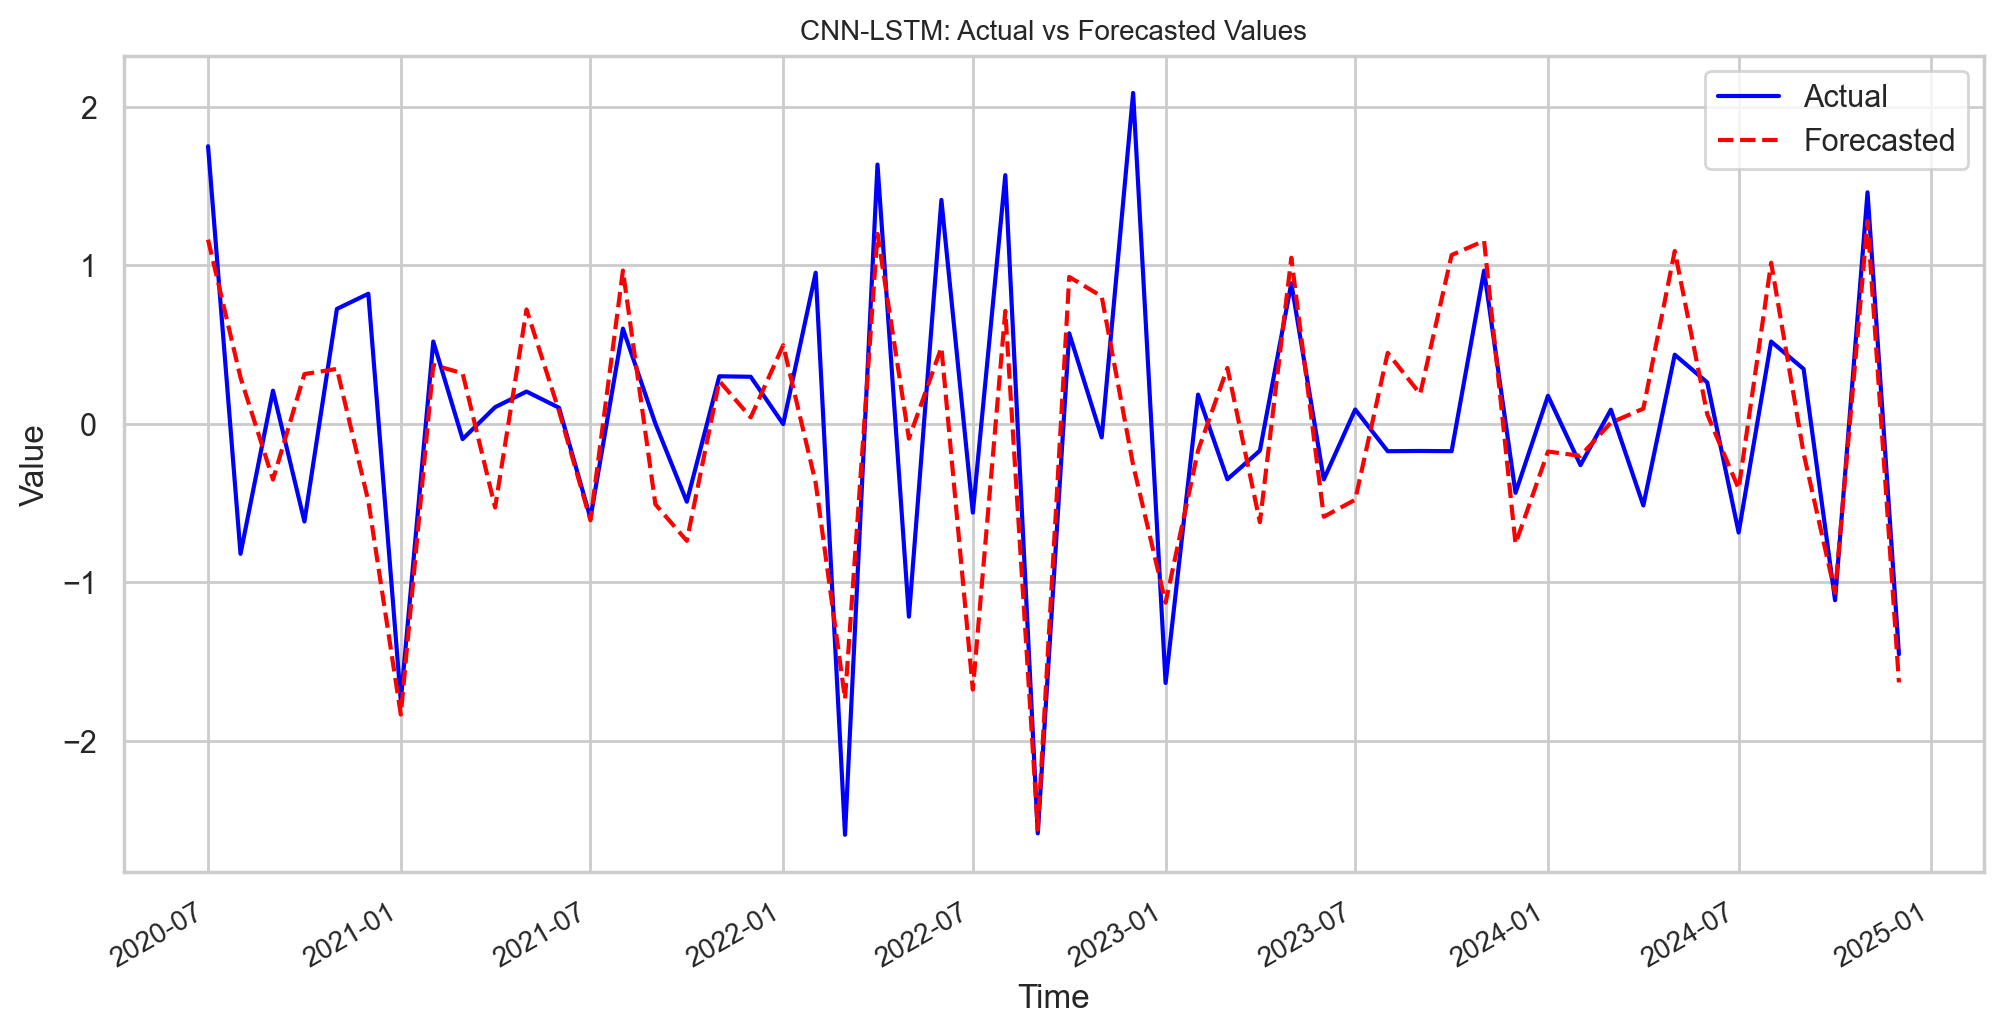

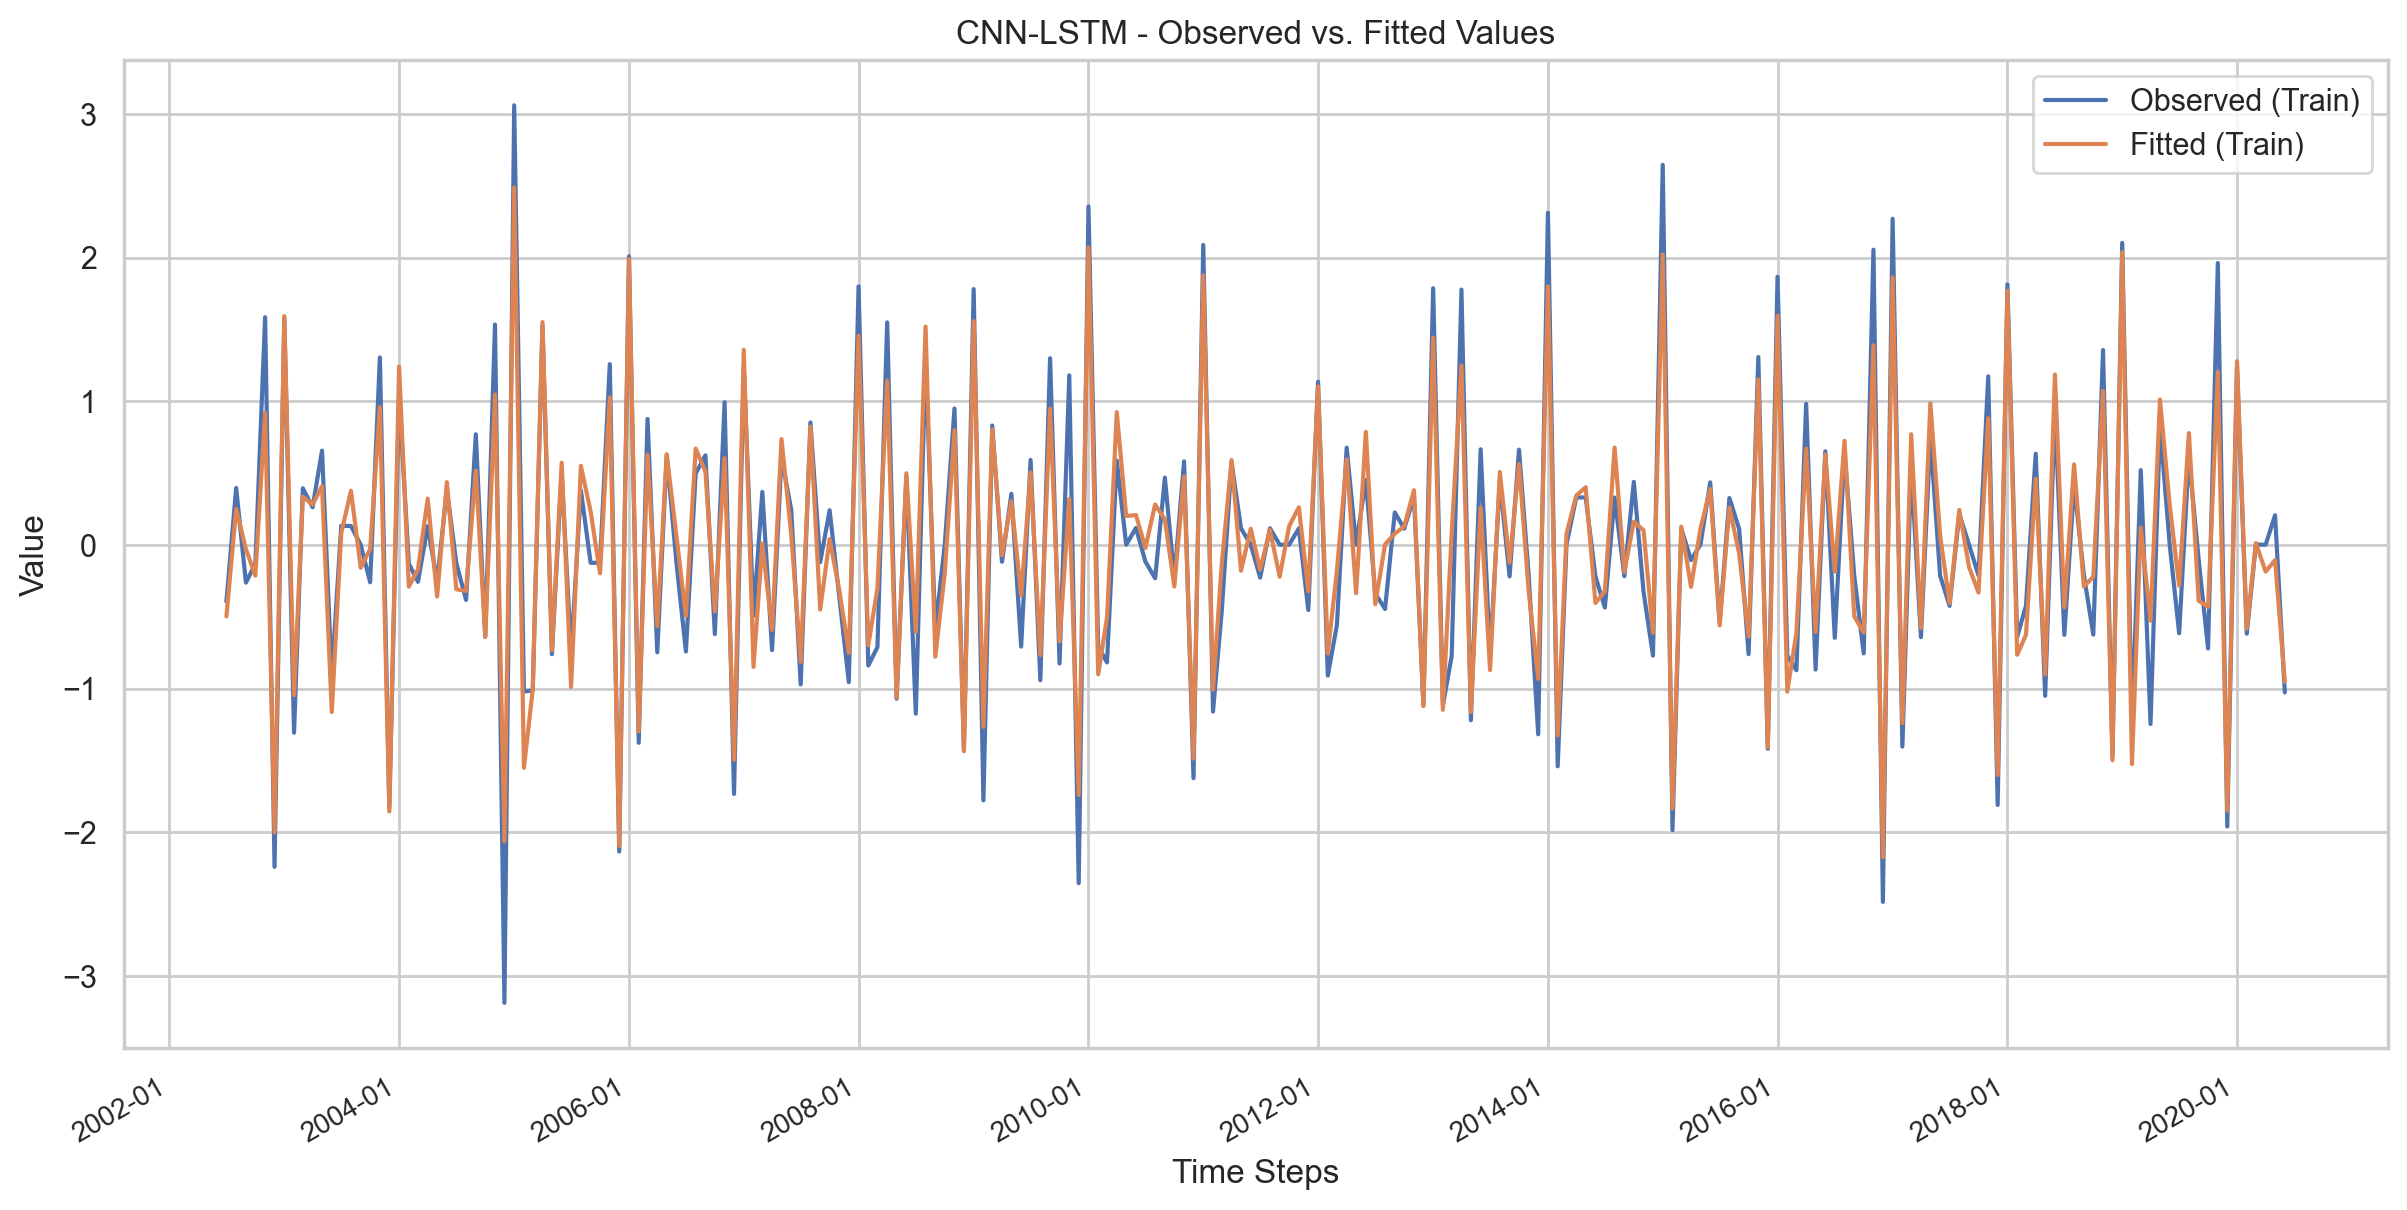

Mean Absolute Error (MAE): 0.52344648
Root Mean Squared Error (RMSE): 0.67779238


In [288]:
df_cpi_3lags = df_cpi_target[feature_3_lags_cols]
model_C1D_3l, X_train_C1D_3l, X_test_C1D_3l, mae_C1D_3l, rmse_C1D_3l, fnames_C1D_3l = conv1D(df_cpi_3lags, target, test_size)


CNN-LSTM 1D (CL1D) No Feature engineering

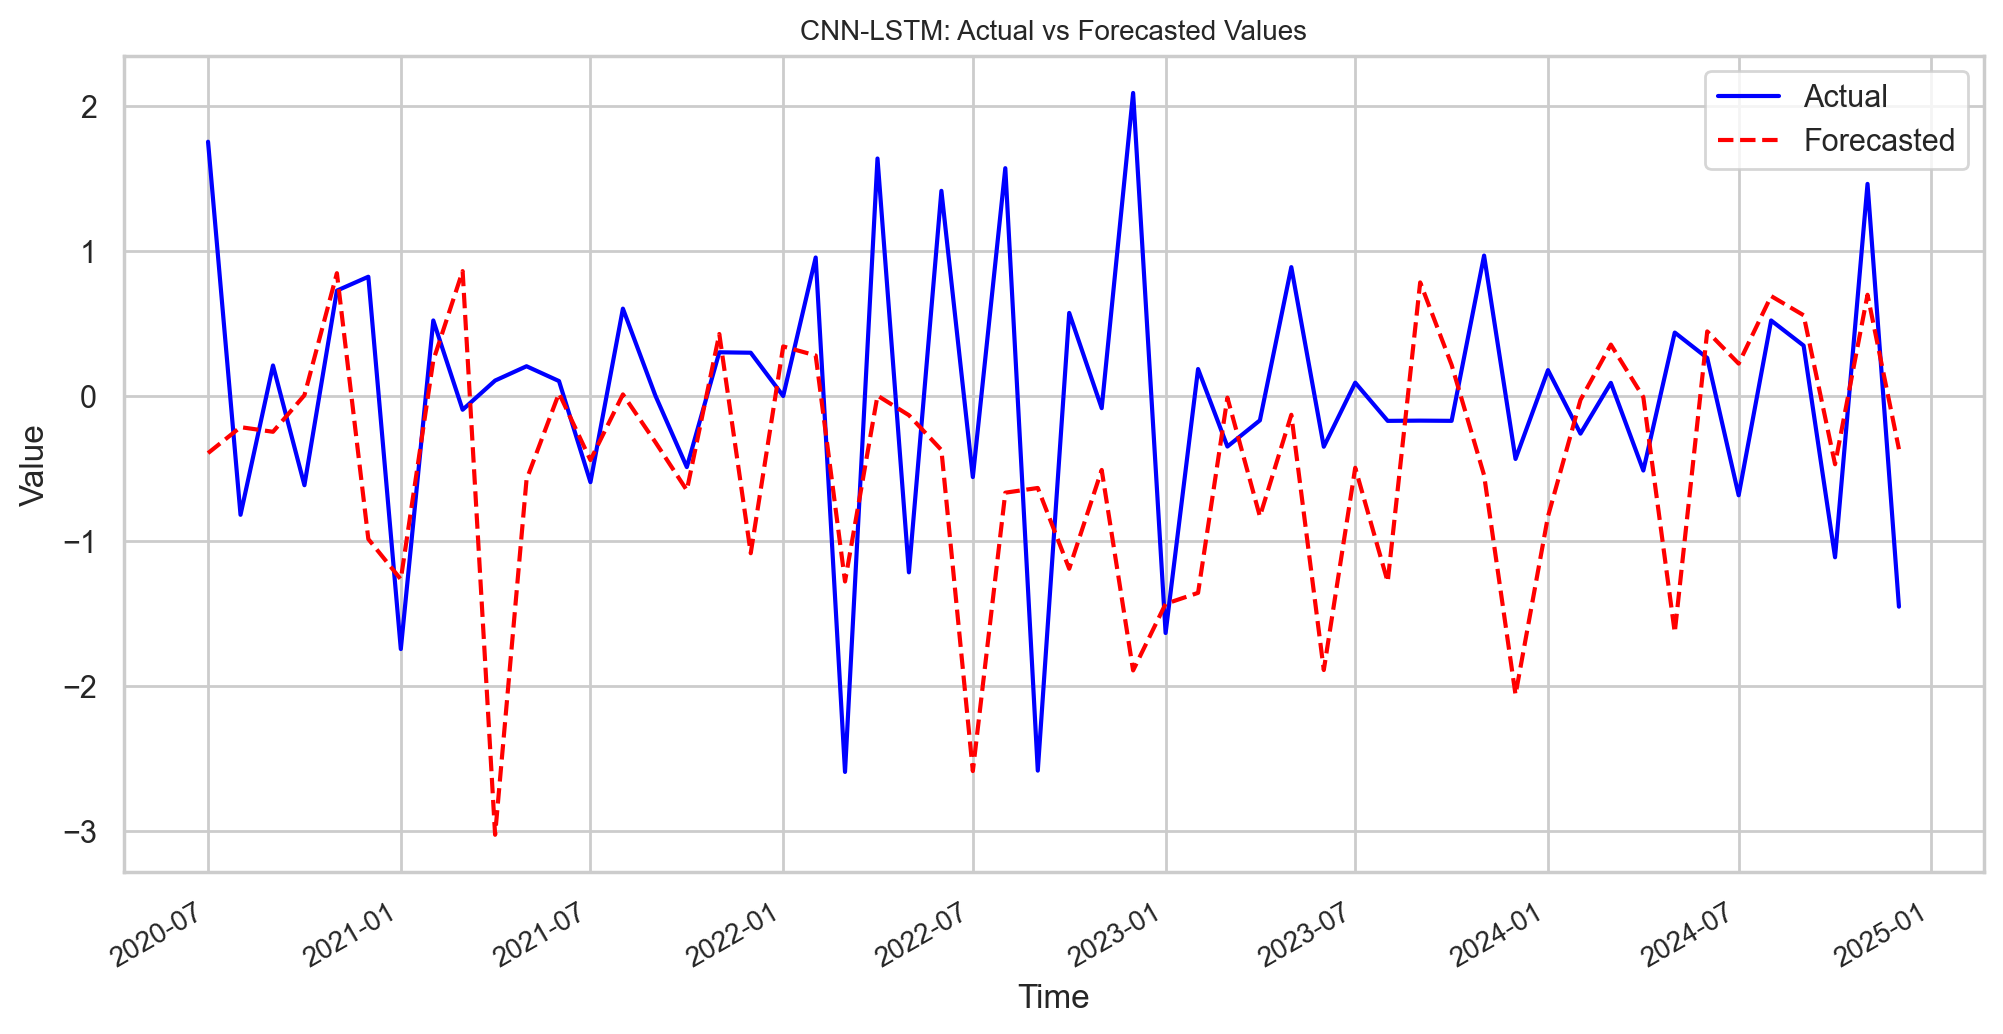

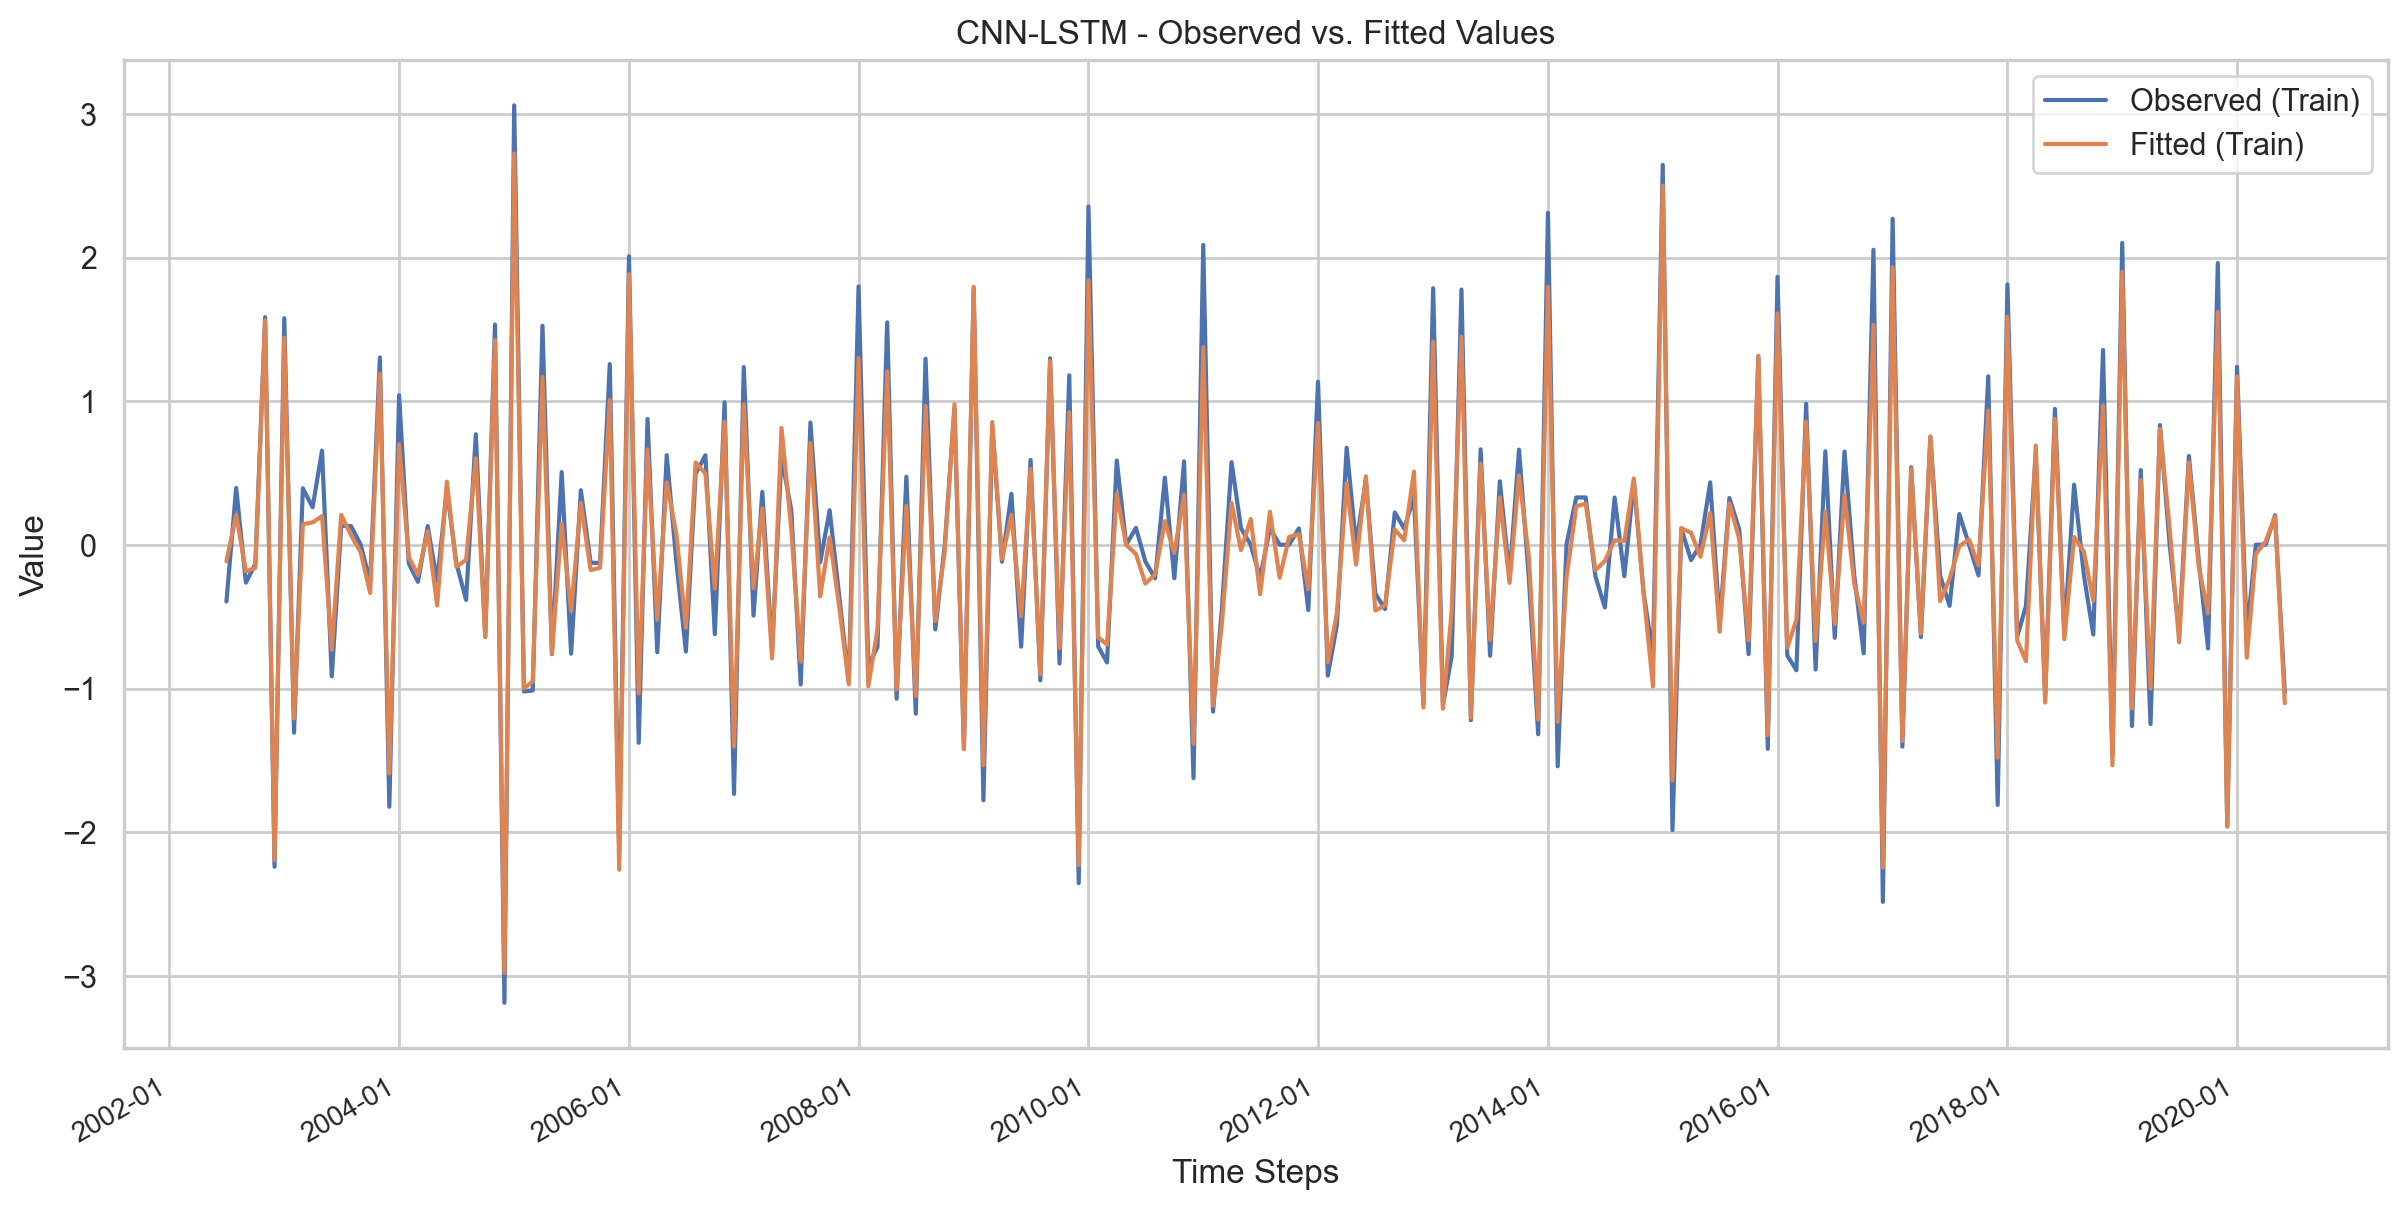

Mean Absolute Error (MAE): 0.98017169
Root Mean Squared Error (RMSE): 1.26954806


In [222]:
model_CL1D_nfe, X_train_CL1D_nfe, X_test_CL1D_nfe, mae_CL1D_nfe, rmse_CL1D_nfe, fnames_CL1D_nfe = convlstm1D(df, target, test_size)

CNN 1D ACF/PACF Target + Feature Engineered

(3, 38)


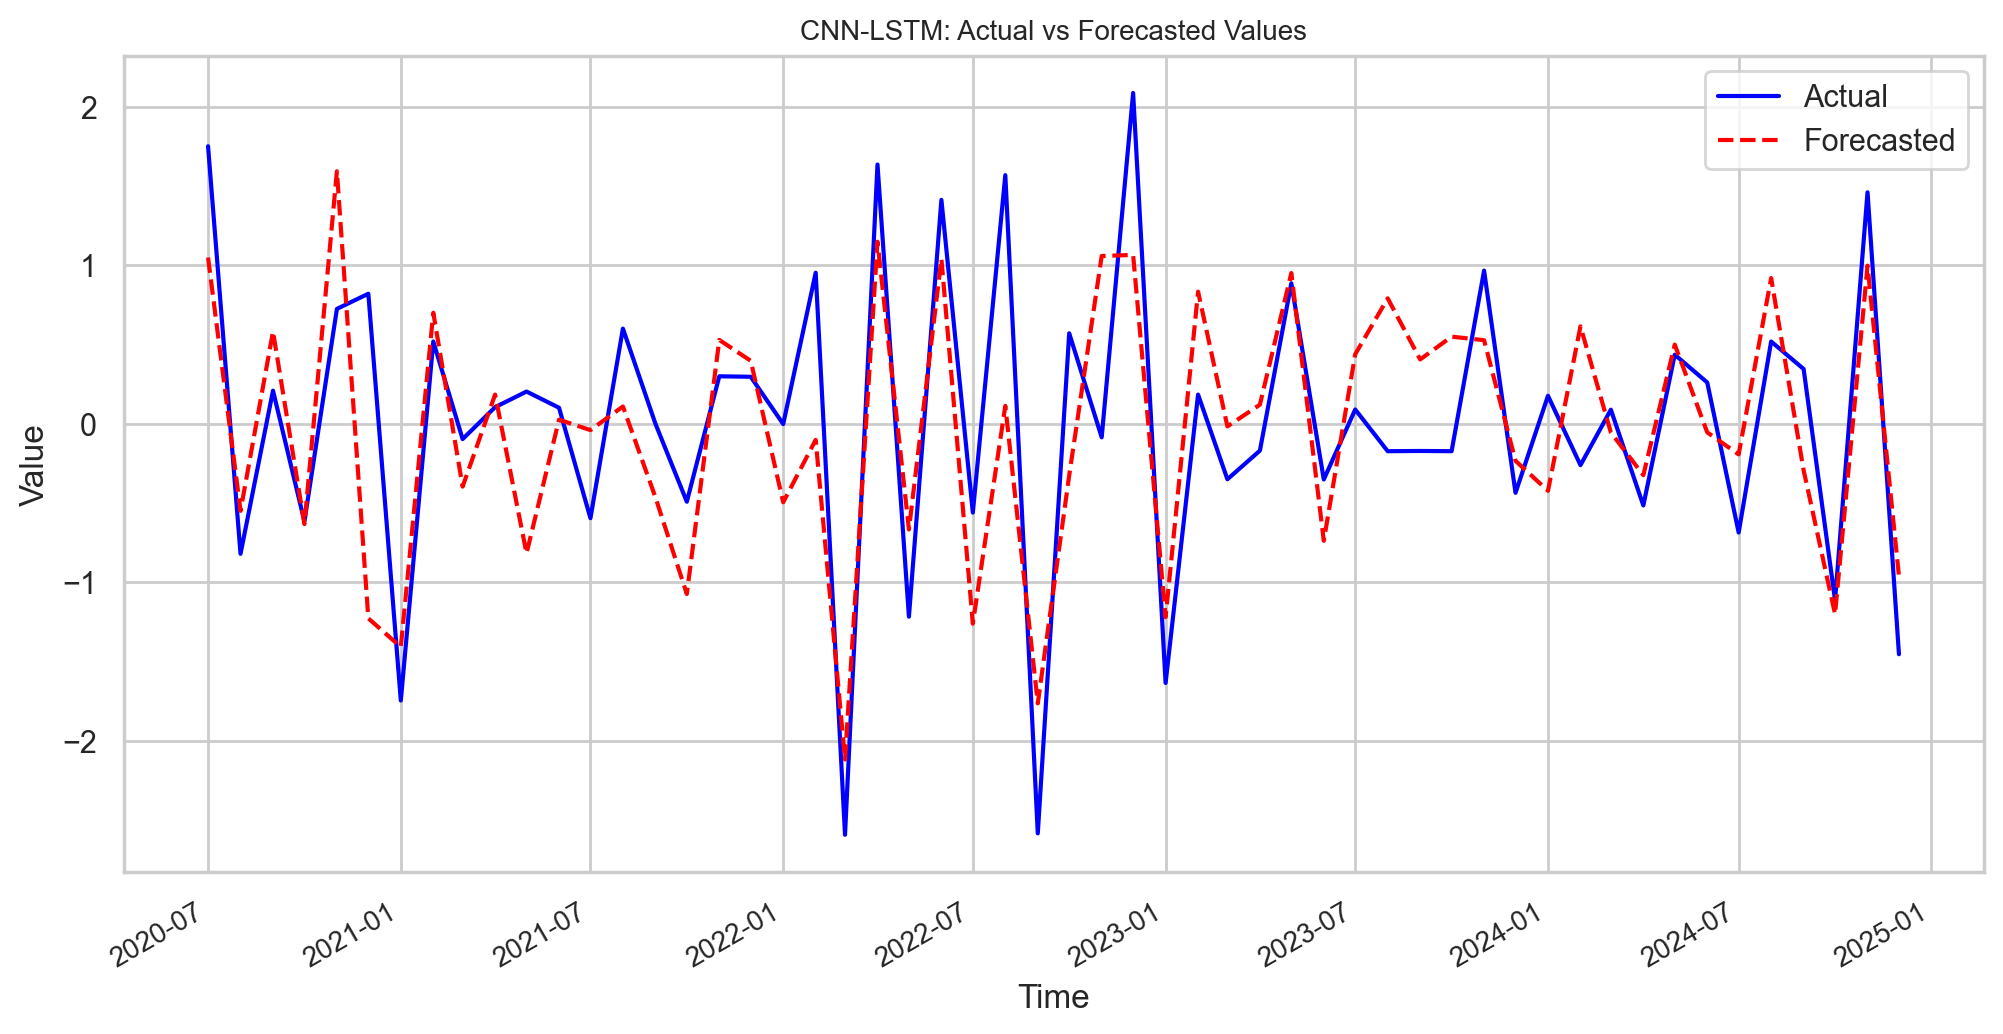

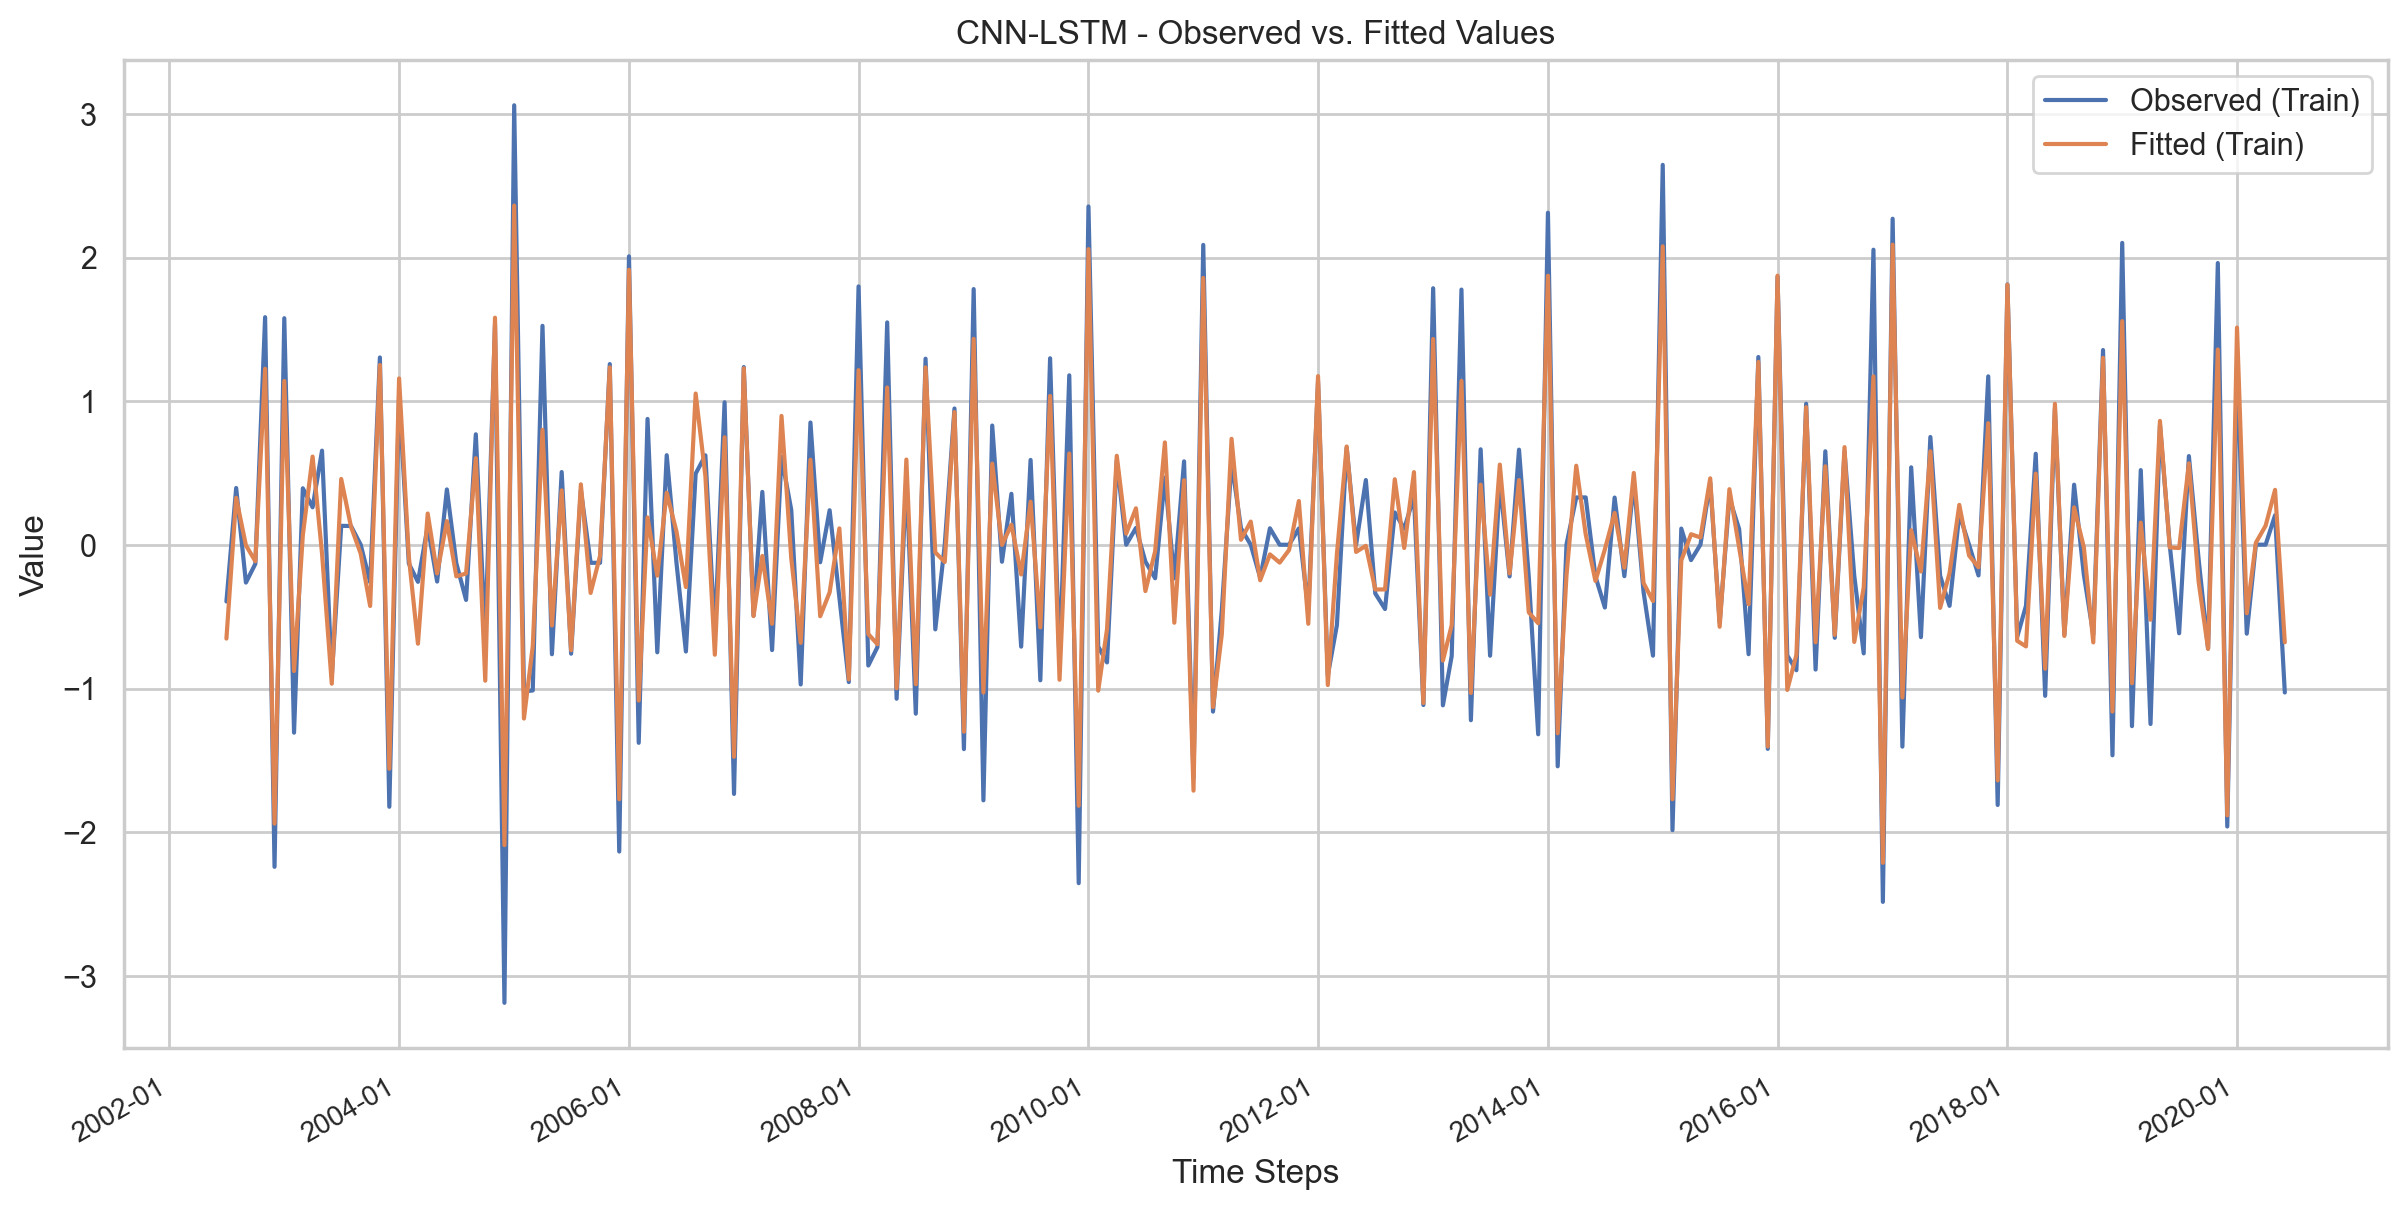

Mean Absolute Error (MAE): 0.52462584
Root Mean Squared Error (RMSE): 0.64498446


In [225]:
df_cpi_acf = df_cpi_target[main_vars_cols + cpi_acf_pacf_lag_cols]
model_C1D_acf, X_train_C1D_acf, X_test_C1D_acf, mae_C1D_acf, rmse_C1D_acf, fnames_C1D_acf = conv1D(df_cpi_acf, target, test_size)

CNN-LSTM 1D ACF/PACF Target + Feature Engineered

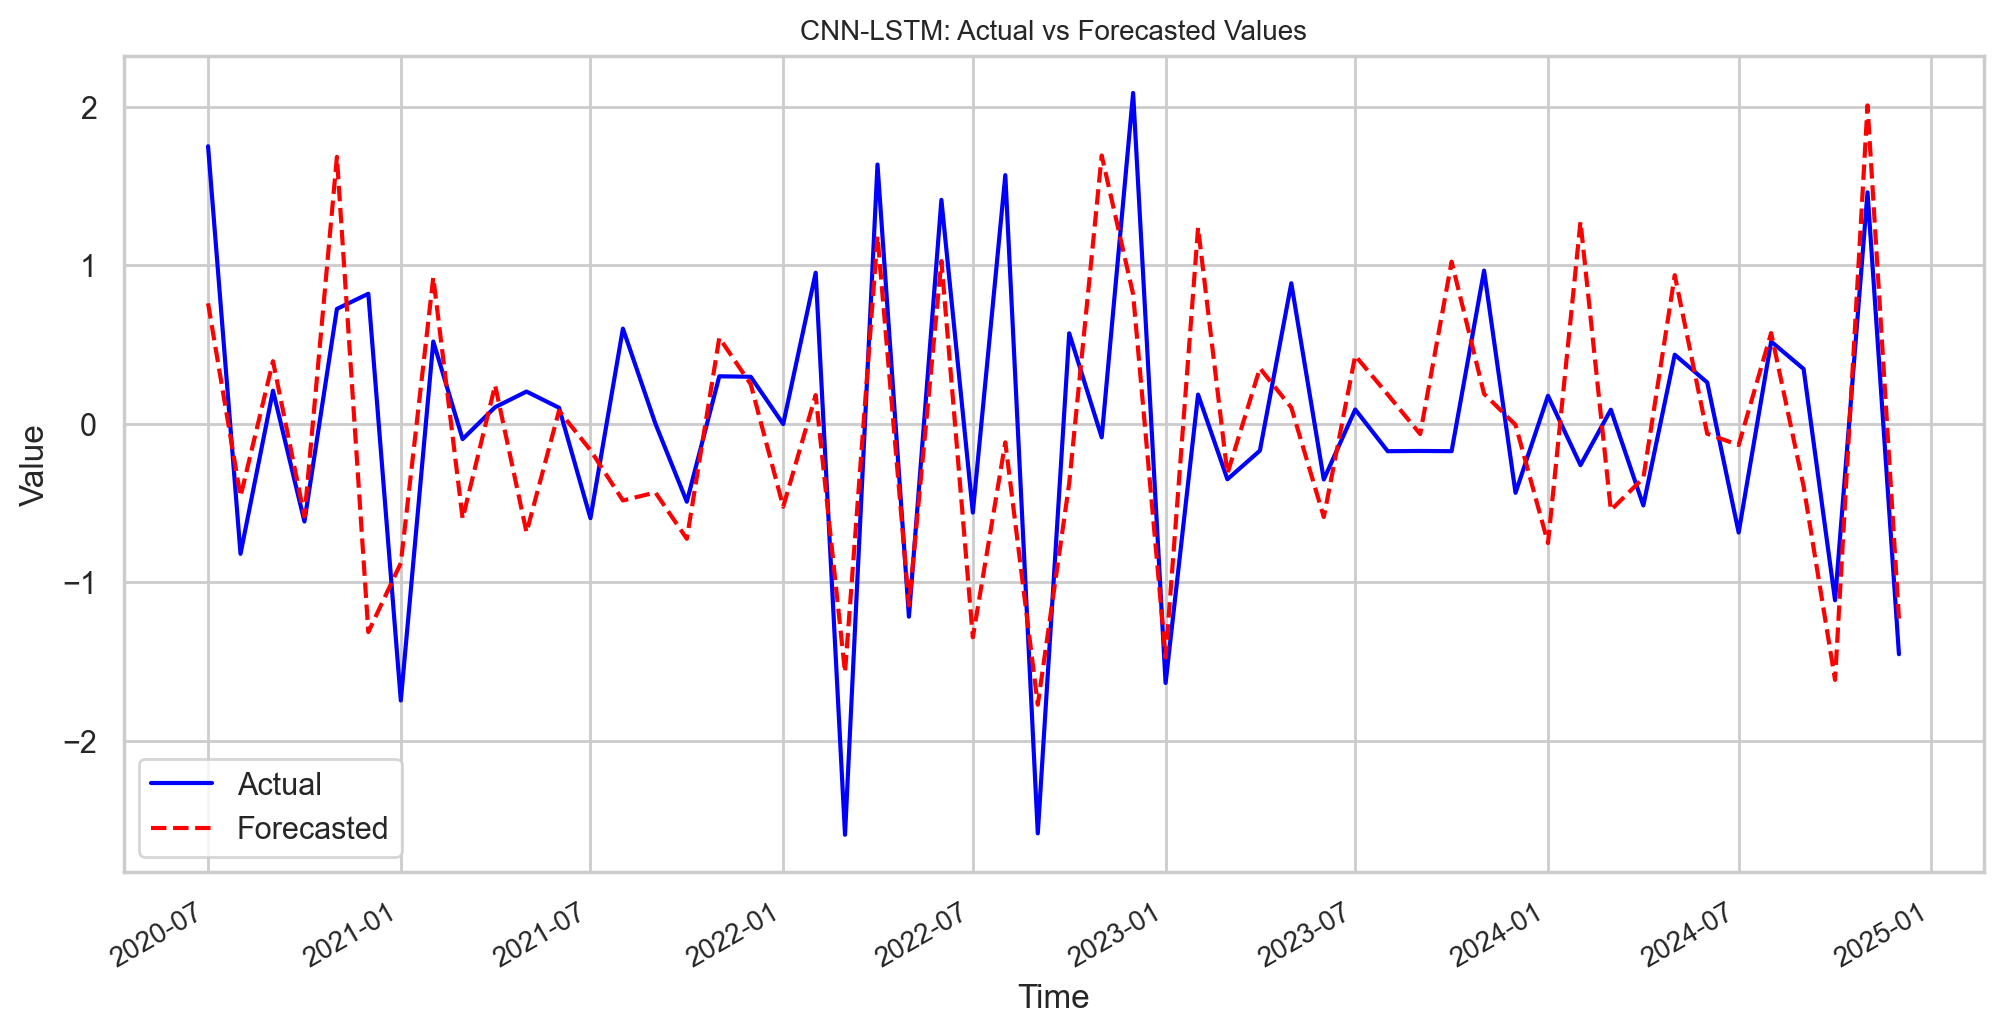

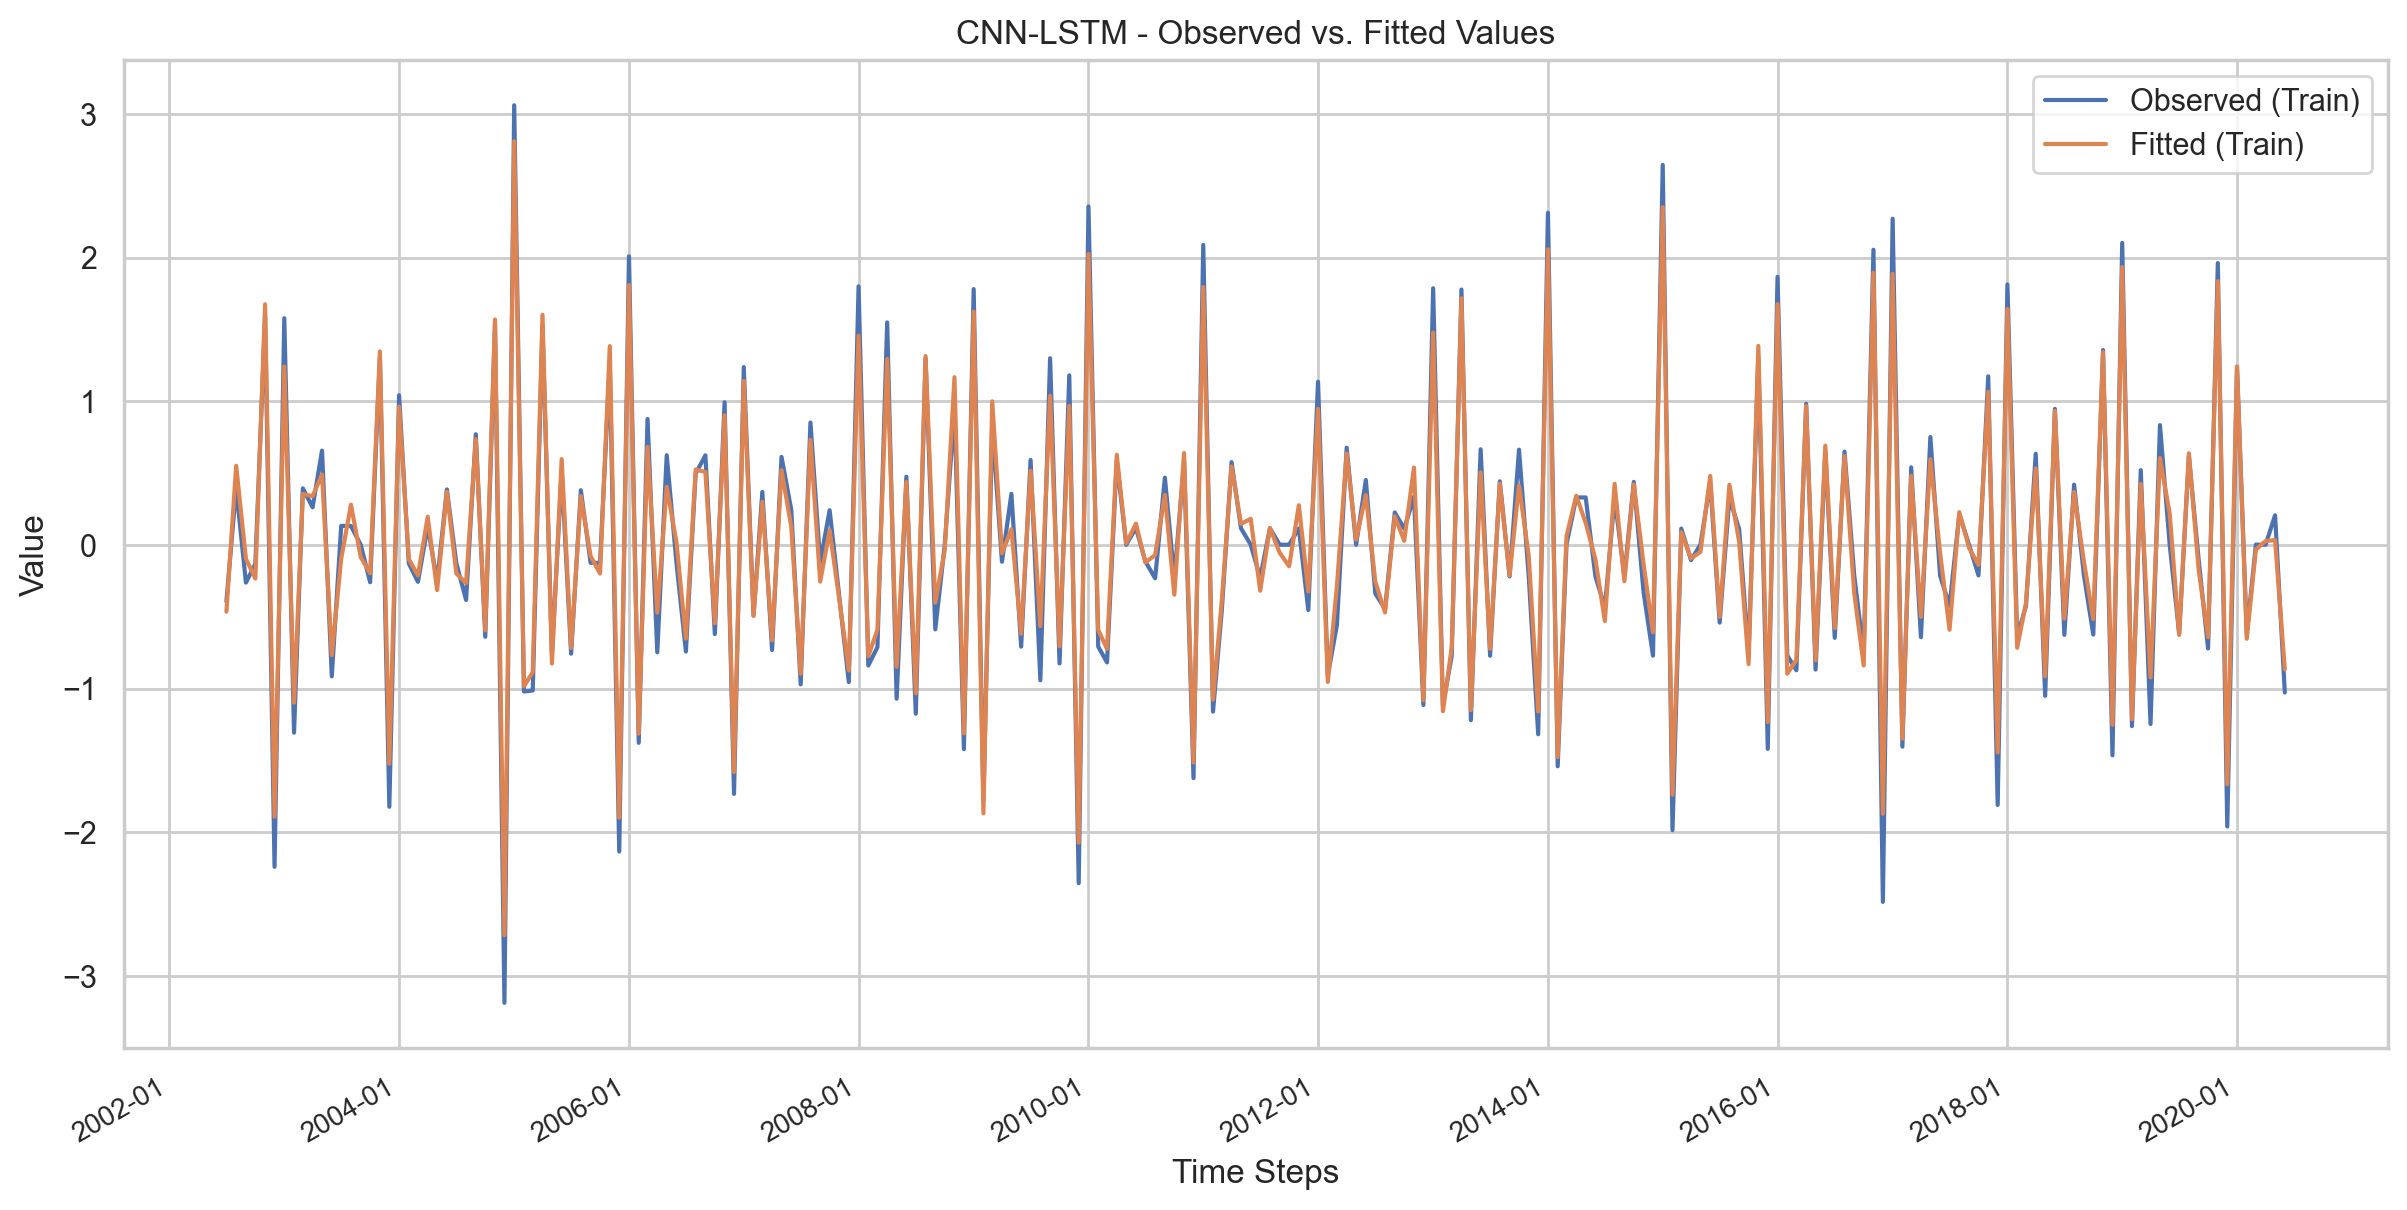

Mean Absolute Error (MAE): 0.61450517
Root Mean Squared Error (RMSE): 0.77417194


In [211]:
model_CL1D_acf, X_train_CL1D_acf, X_test_CL1D_acf, mae_CL1D_acf, rmse_CL1D_acf, fnames_CL1D_acf = convlstm1D(df_cpi_acf, target, test_size)

CNN-LSTM 1D Target + Feature Engineered 3 lags

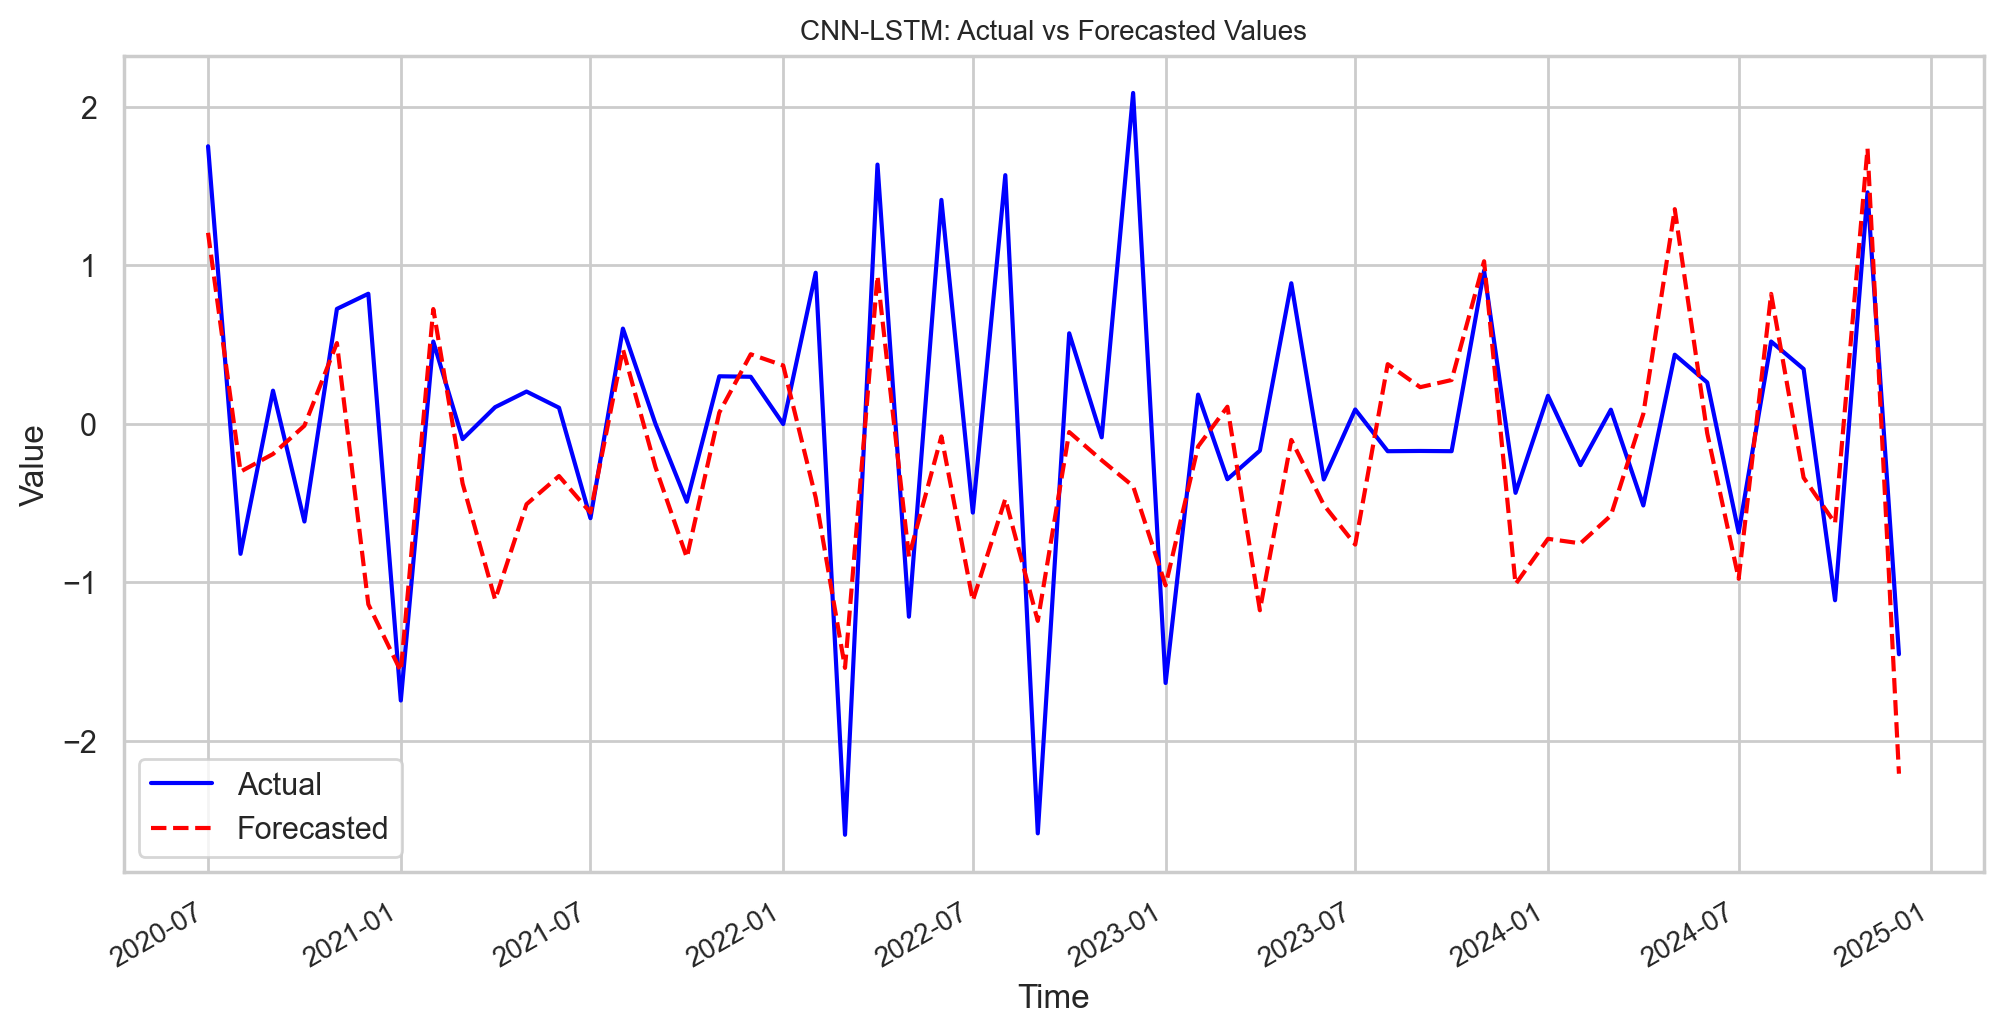

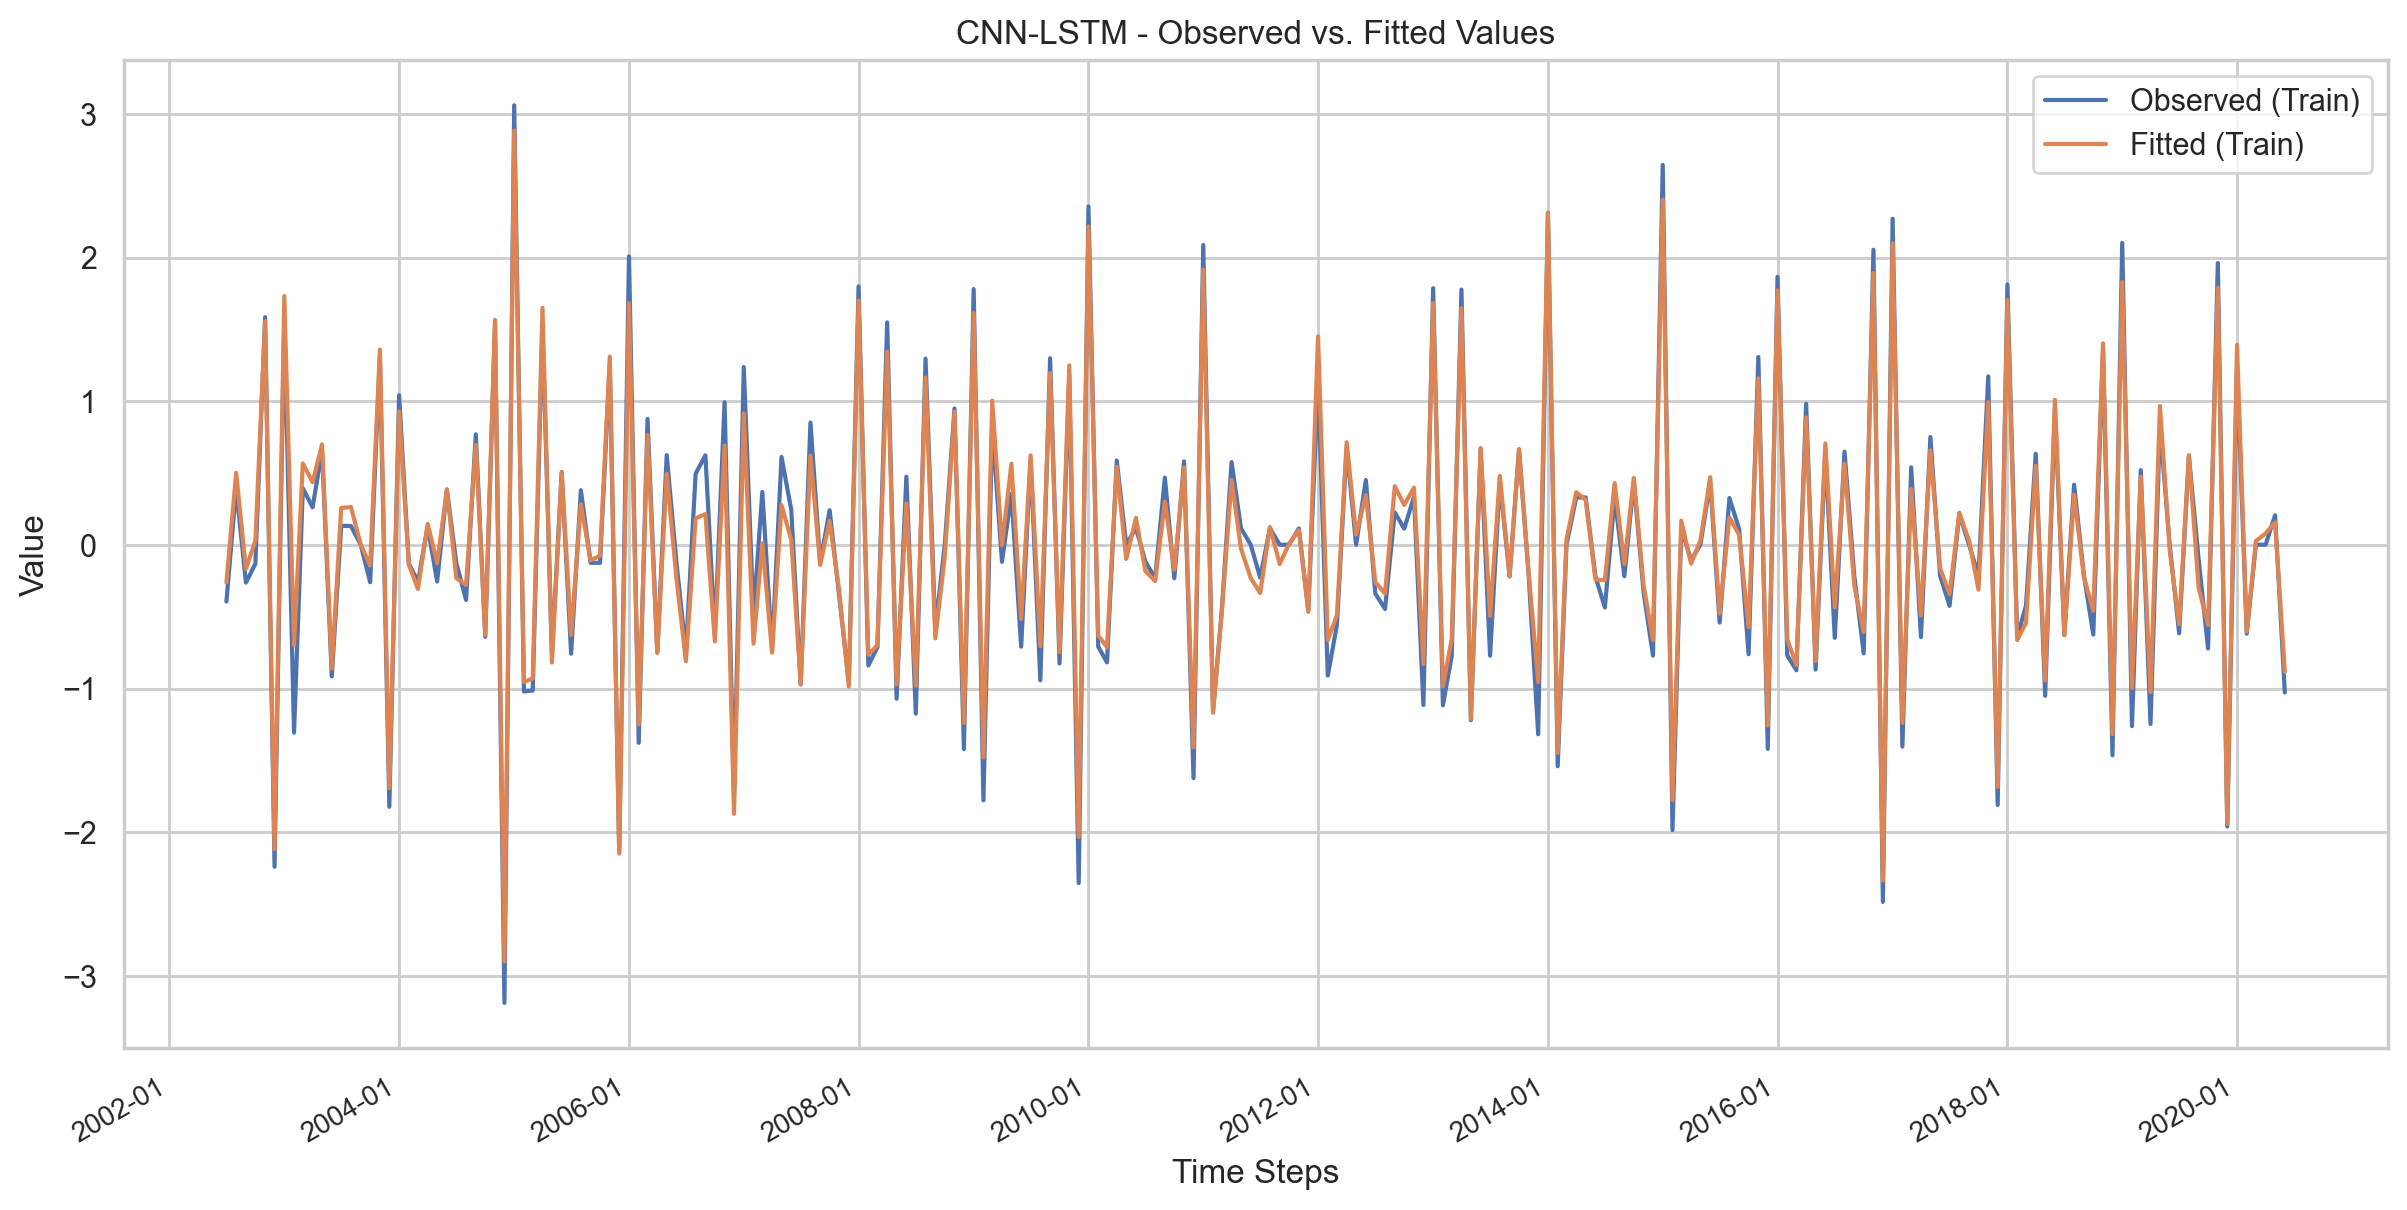

Mean Absolute Error (MAE): 0.63257677
Root Mean Squared Error (RMSE): 0.80864361


In [212]:
model_CL1D_3l, X_train_CL1D_3l, X_test_CL1D_3l, mae_CL1D_3l, rmse_CL1D_3l, fnames_CL1D_3l = convlstm1D(df_cpi_3lags, target, test_size)

CNN-LSTM 2D (CL2D) No feature engineering

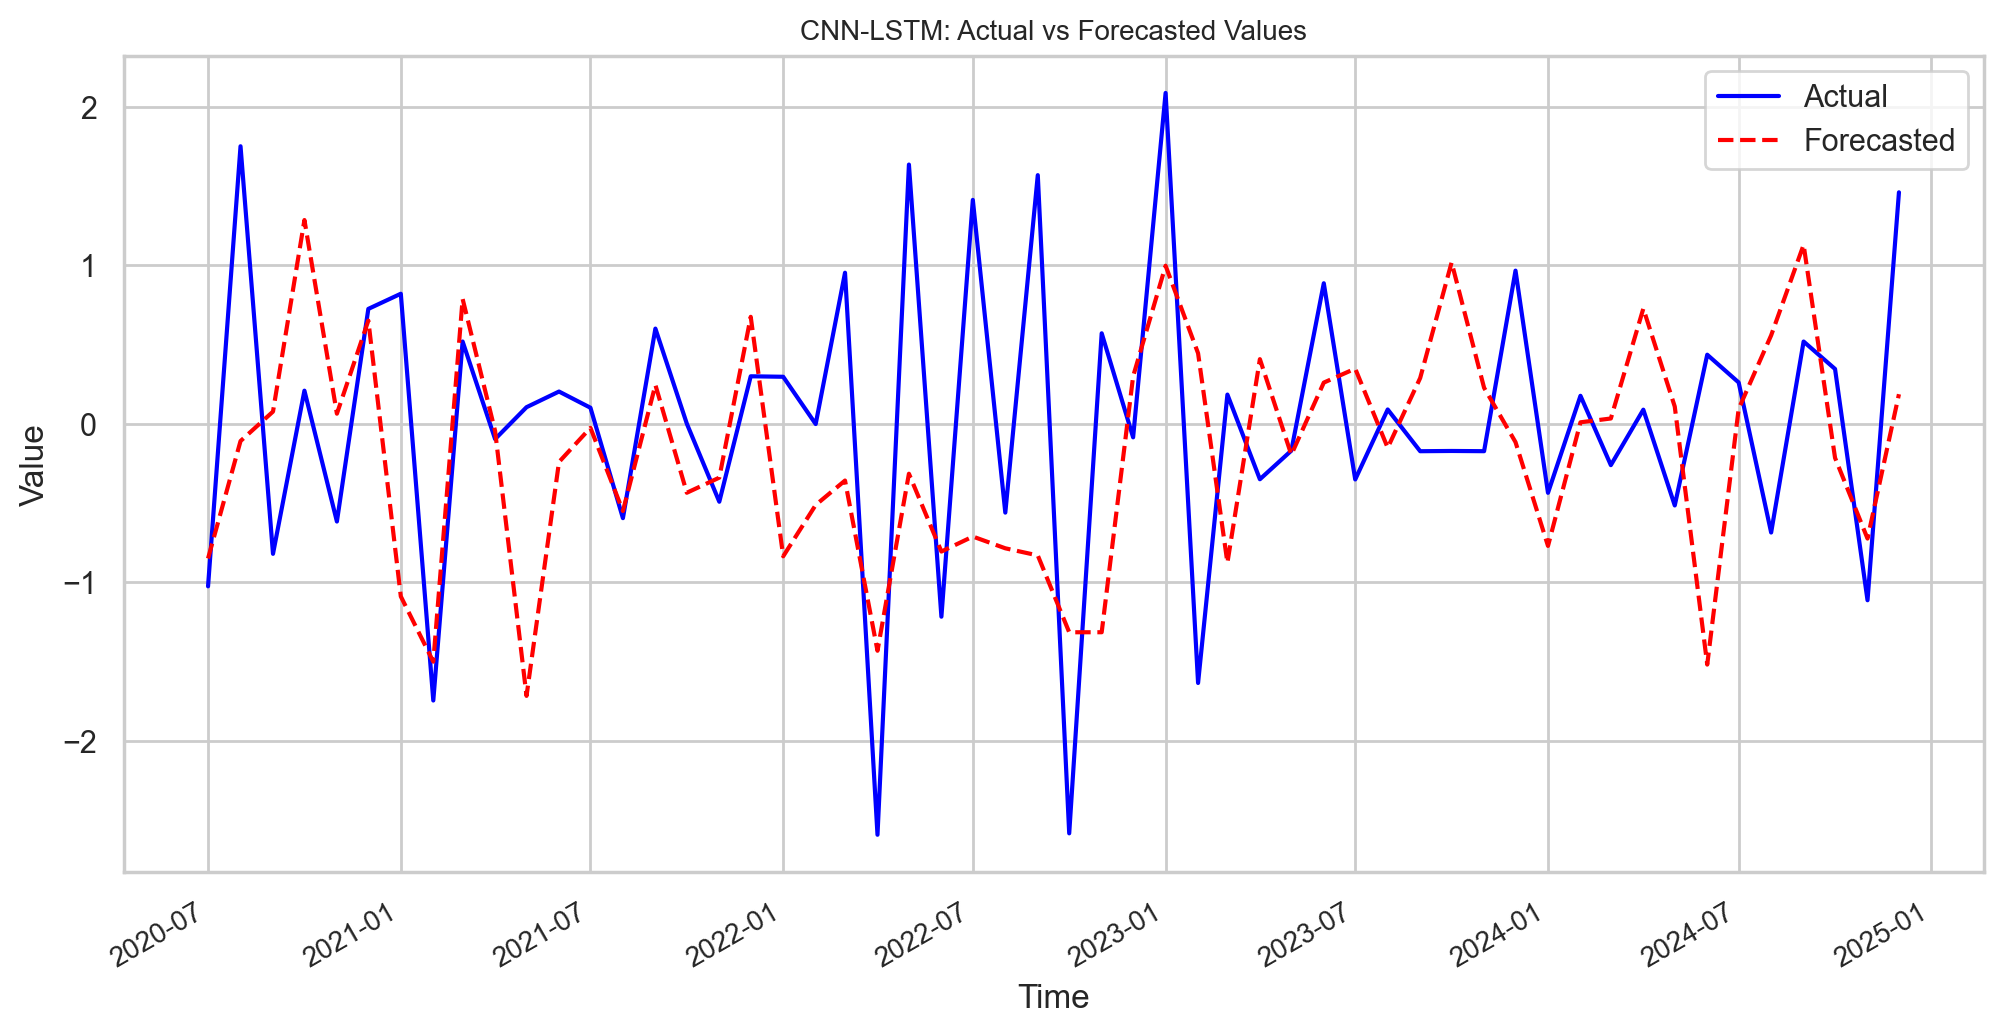

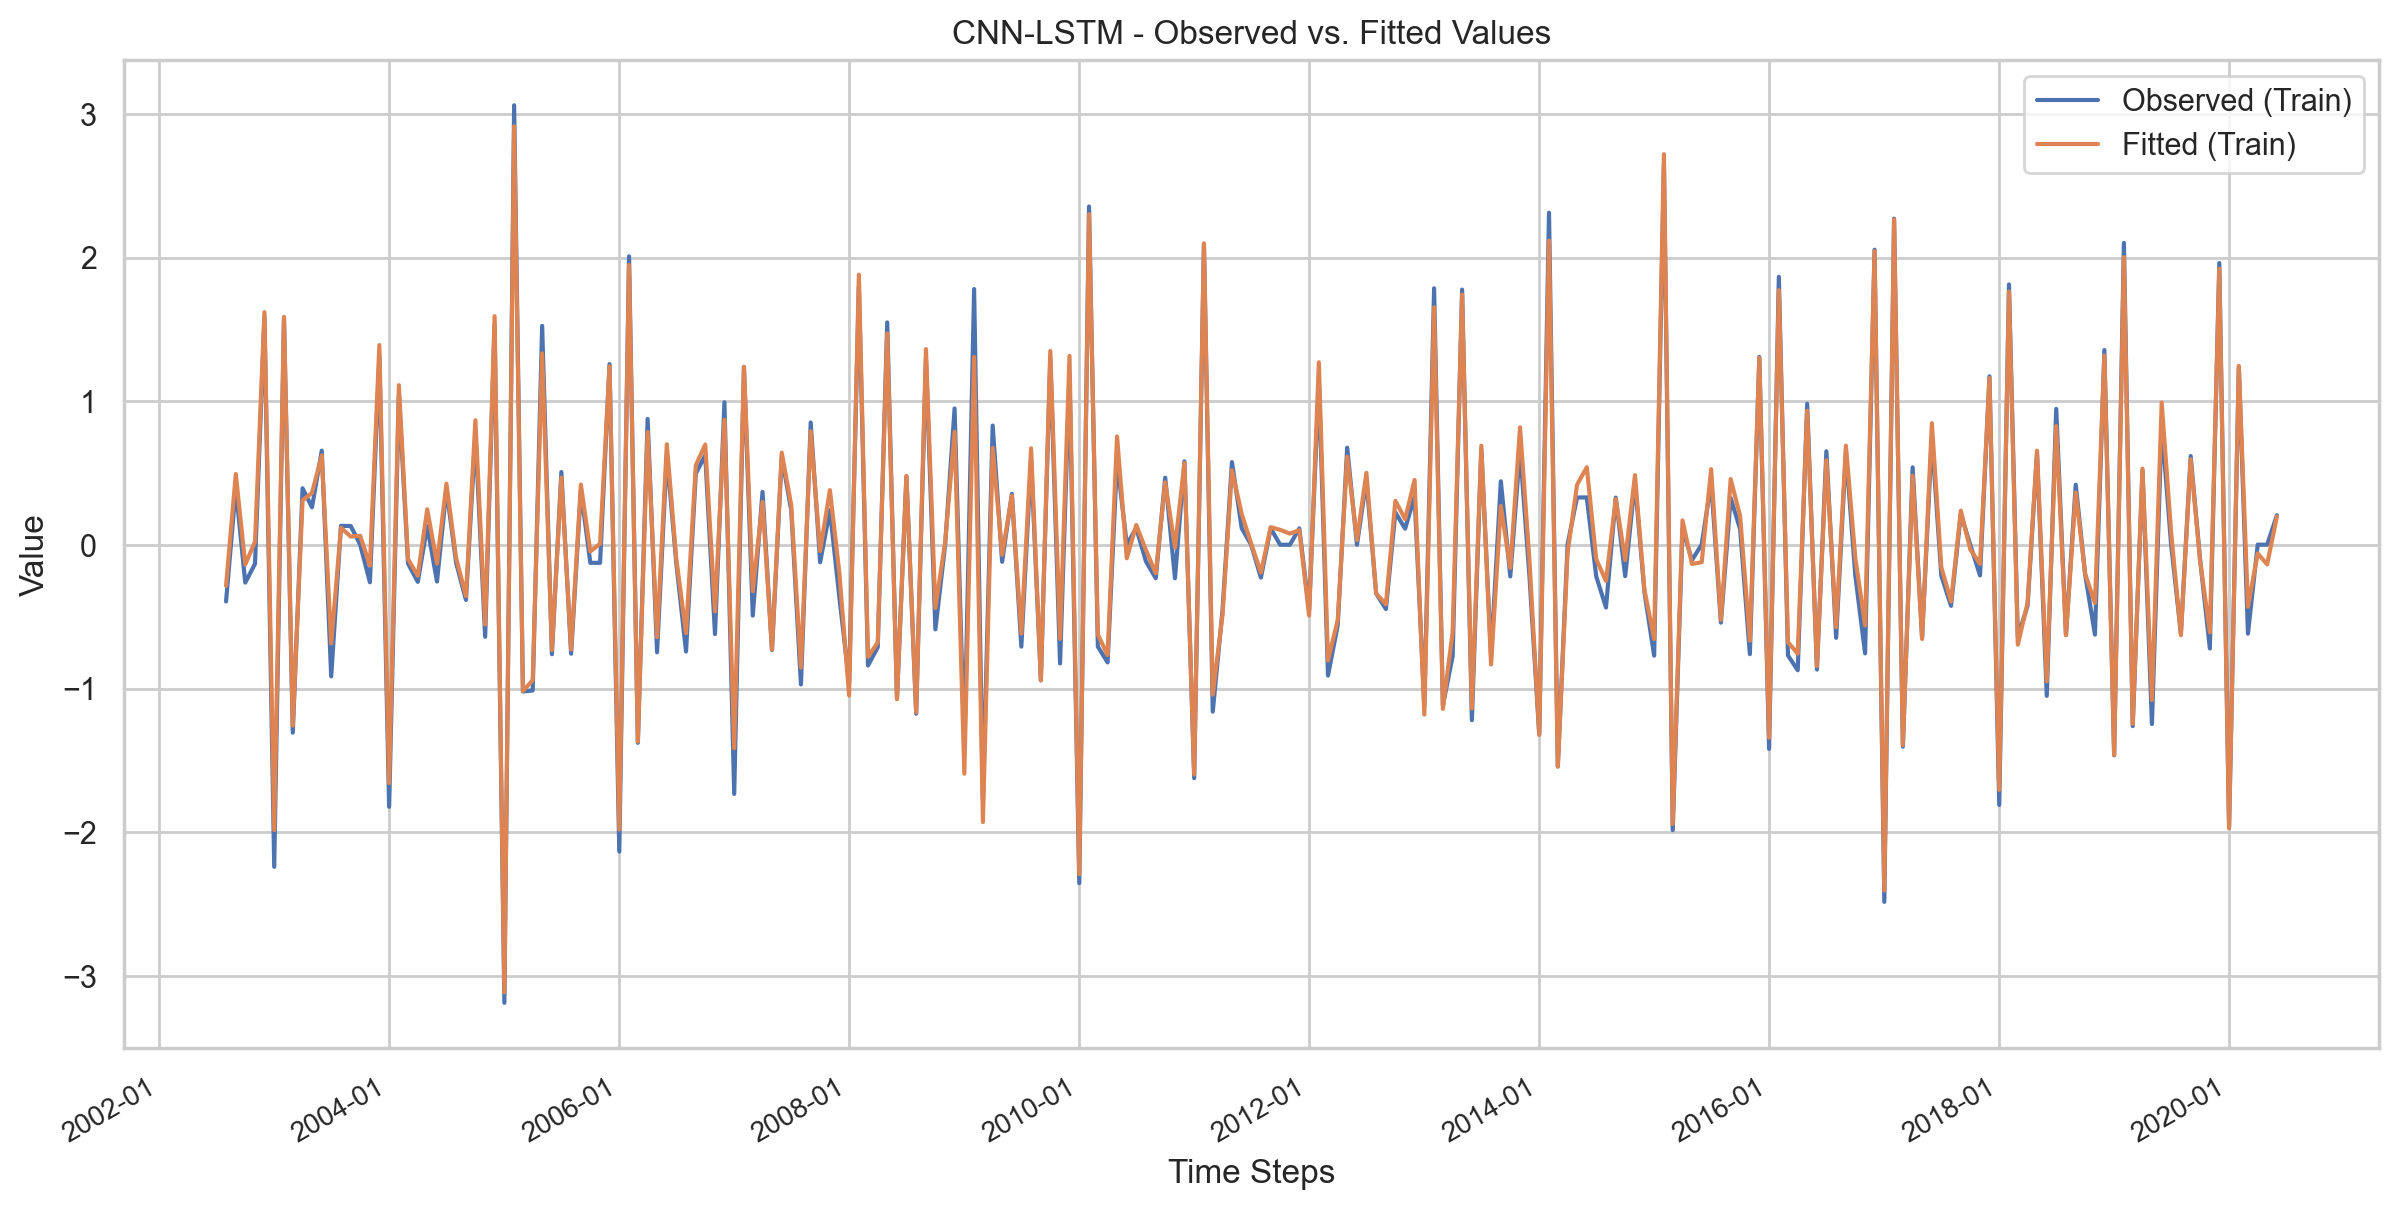

Mean Absolute Error (MAE): 0.80999904
Root Mean Squared Error (RMSE): 1.03592919


In [421]:
model_CL2D_nfe, X_train_CL2D_nfe, X_test_CL2D_nfe, mae_CL2D_nfe, rmse_CL2D_nfe, fnames_CL2D_vae = convlstm2D(df, target, test_size)

CNN-LSTM 2D + VAE

Index(['z1', 'z2', 'z3', 'z4', 'z5', 'CPI'], dtype='object')


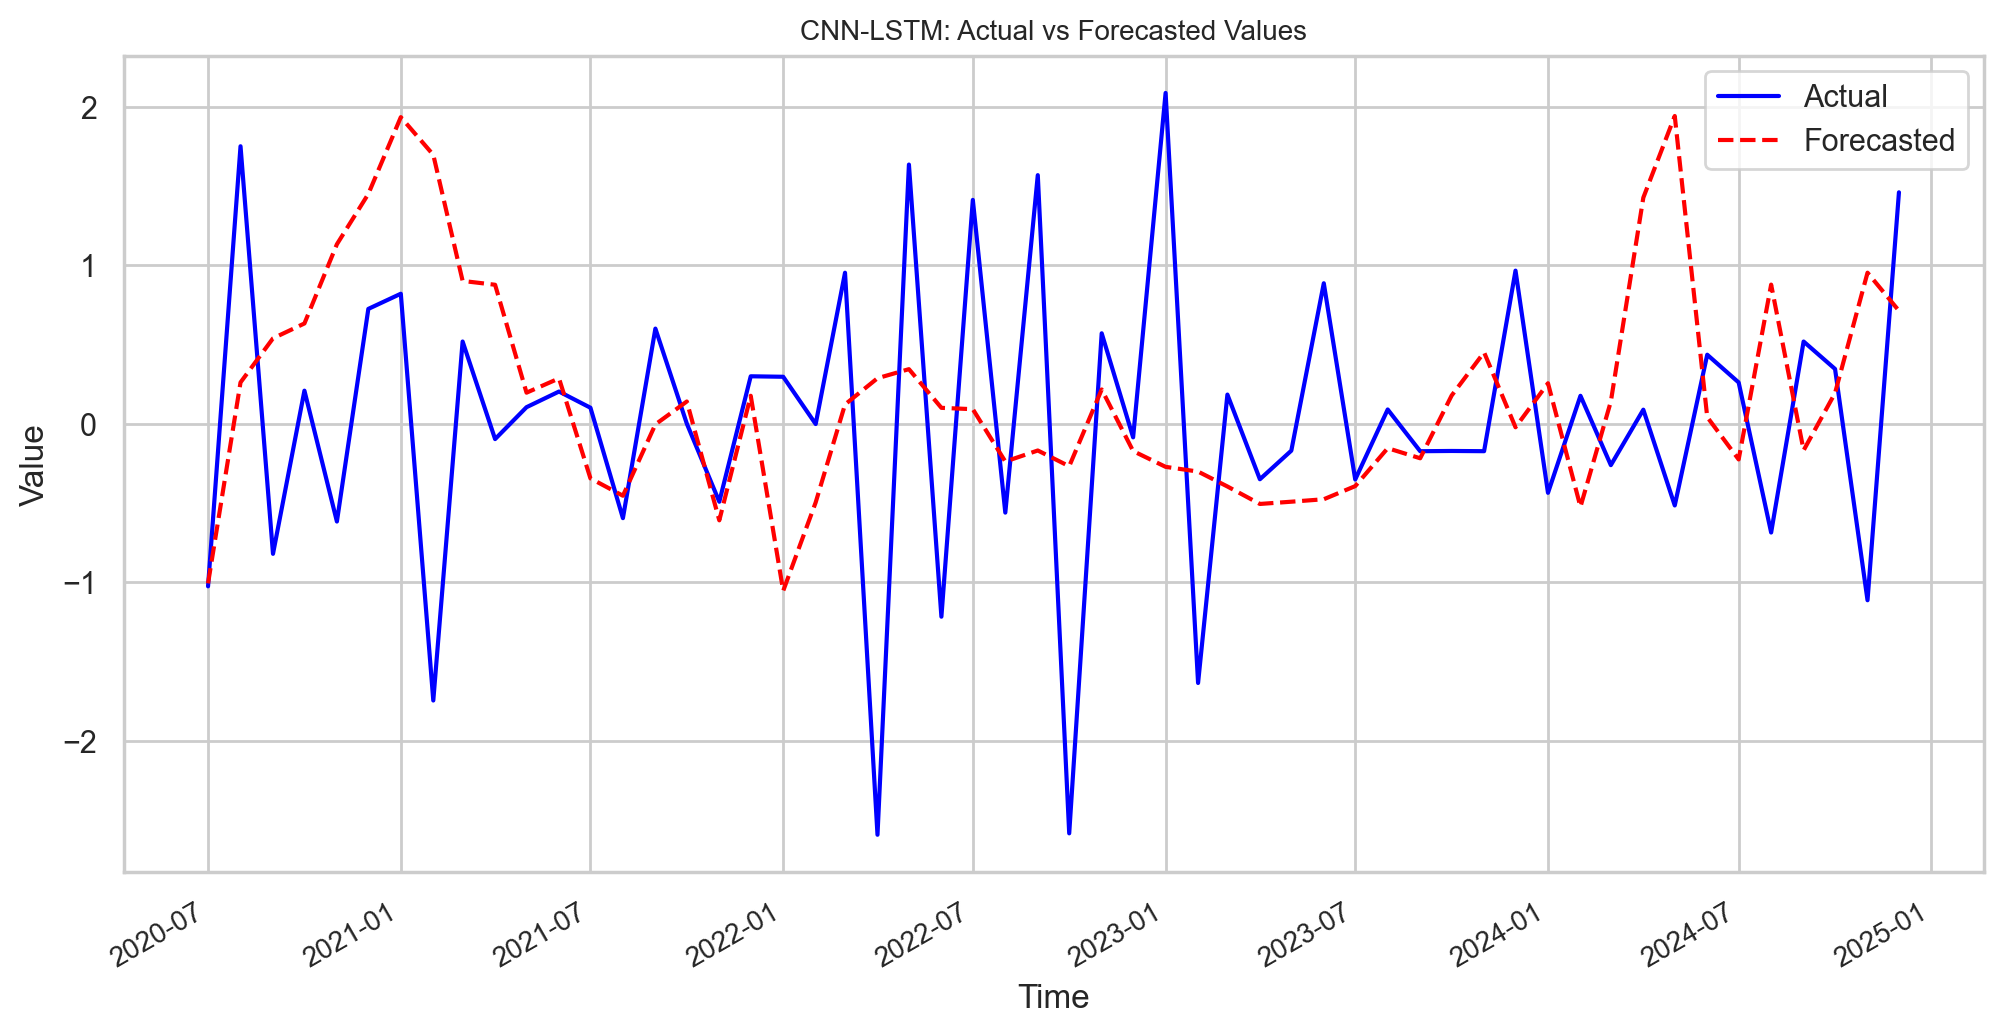

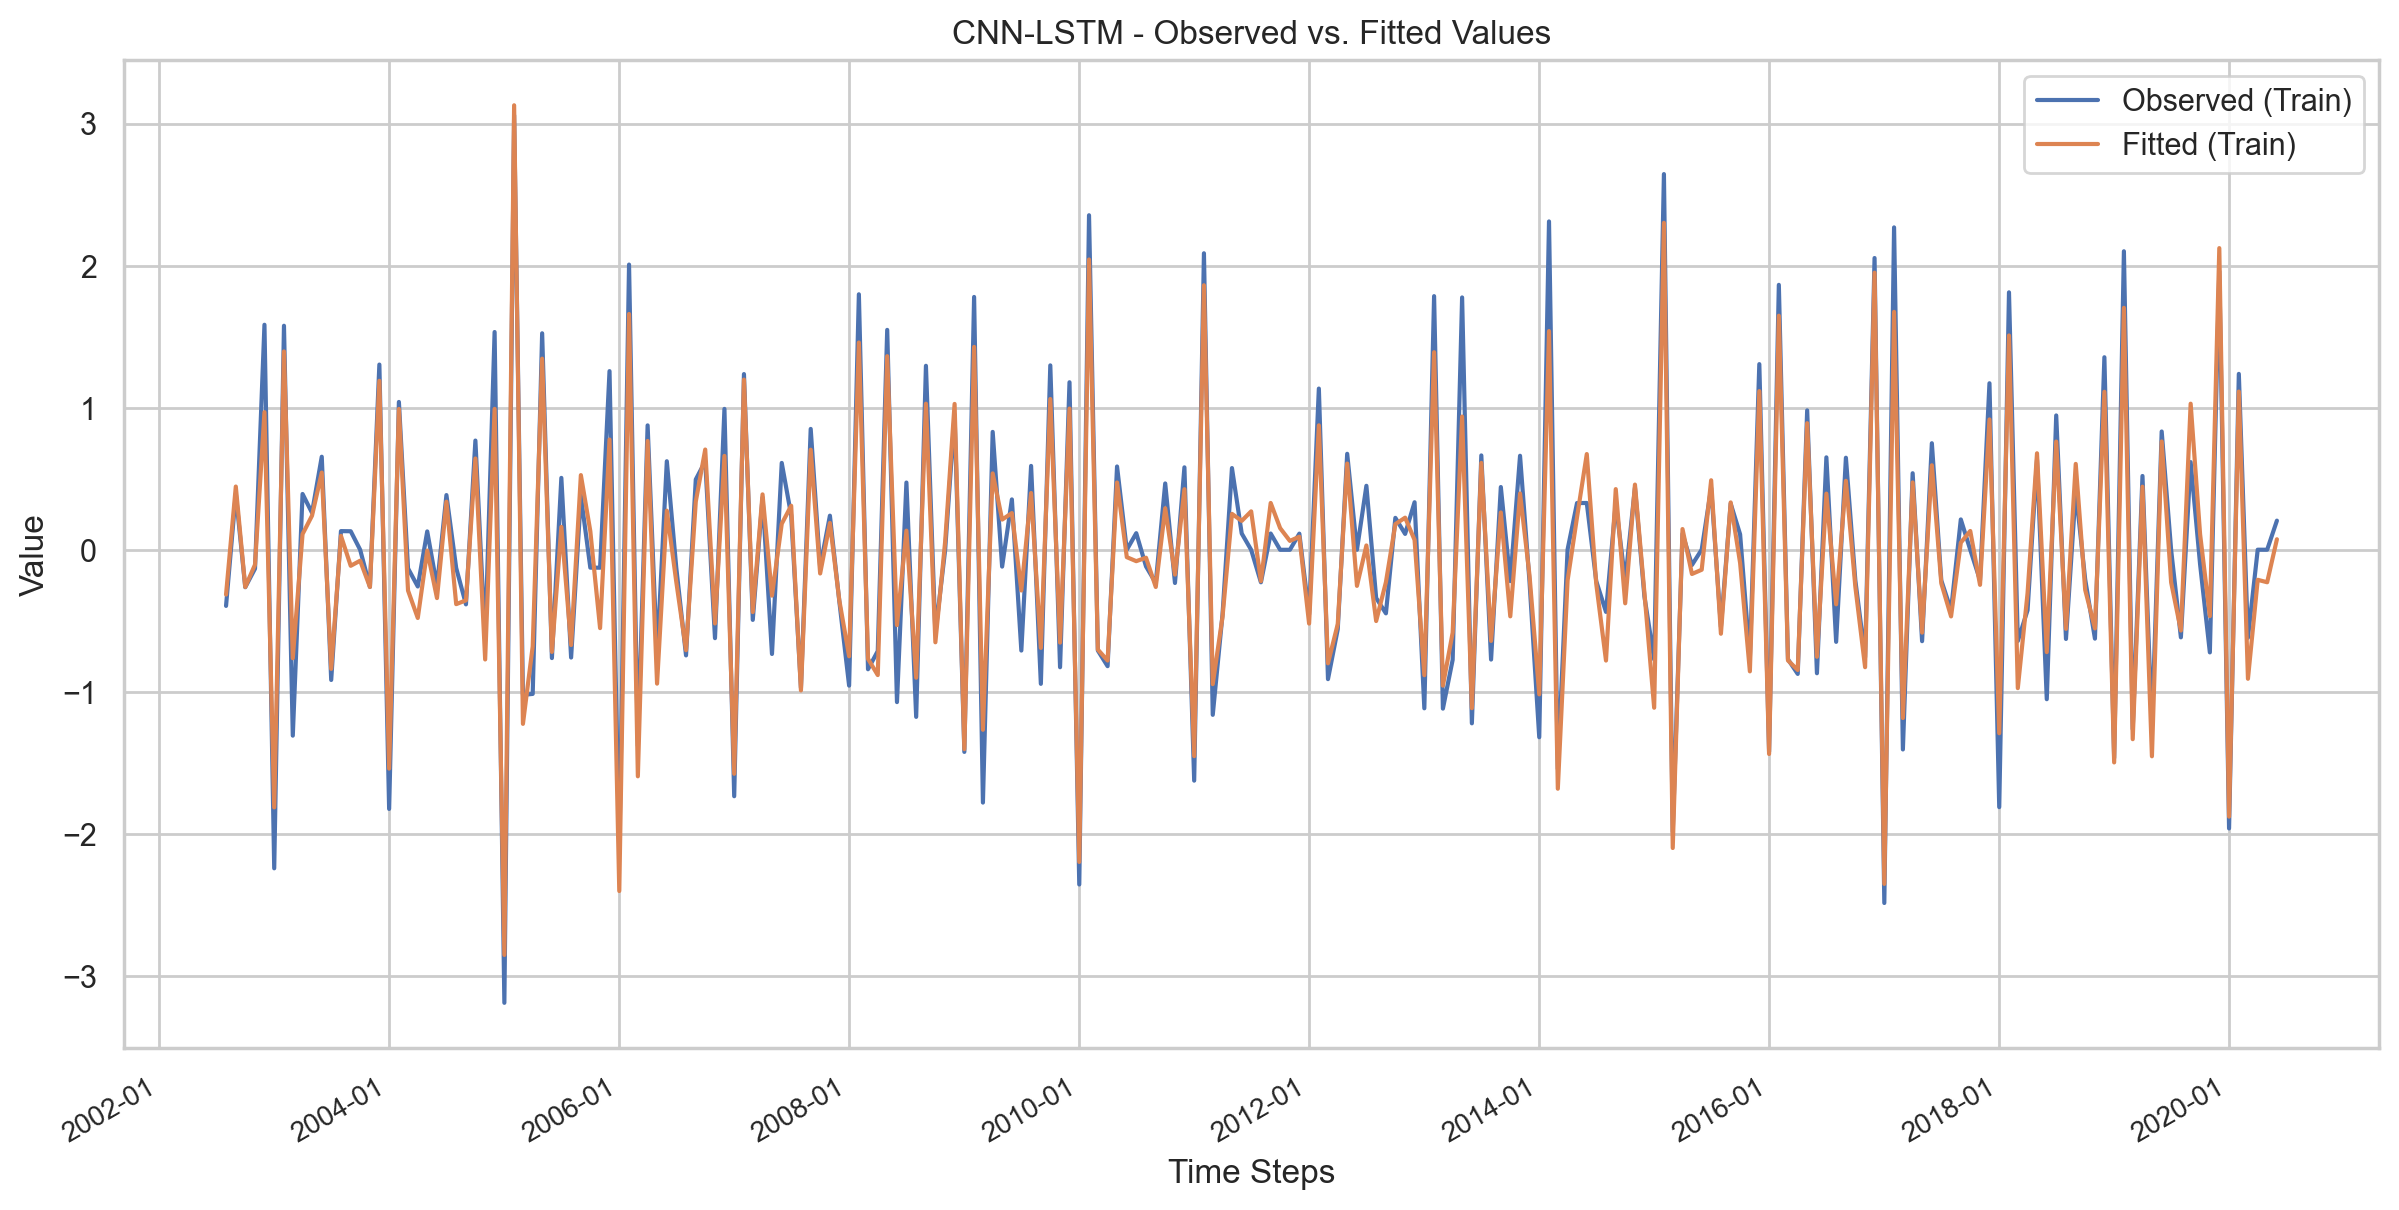

Mean Absolute Error (MAE): 0.88565773
Root Mean Squared Error (RMSE): 1.18518020


In [295]:
df_cpi_vae = df_cpi_target[vae_cpi_cols]
print(df_cpi_vae.columns)
model_CL2D_vae, X_train_CL2D_vae, X_test_CL2D_vae, mae_CL2D_vae, rmse_CL2D_vae, fnames_CL2D_nfe = convlstm2D(df_cpi_vae, target, test_size)

In [411]:
print(f'CONV 1D NFE (MAE): {mae_C1D_nfe}')
print(f'CONVLSTM 2D NFE (MAE): {mae_CL2D_nfe}')
print(f'CONVLSTM 1D + NFE (MAE): {mae_CL1D_nfe}')

print(f'CONV 1D + ACF/PACF (MAE): {mae_C1D_acf}')
print(f'CONVLSTM 1D + ACF/PACF (MAE): {mae_CL1D_acf}')

print(f'CONV1D + 3 LAGS (MAE): {mae_C1D_3l}')
print(f'CONVLSTM 1D + 3 LAGS (MAE): {mae_CL1D_3l}')

# print(f'CONVLSTM 1D + VAE (MAE): {mae_CL1D_vae}')
print(f'CONVLSTM 2D + VAE (MAE): {mae_CL2D_vae}')

print(f'VAR (MAE): {var_mae}')
print(f'ARIMA (MAE): {arima_mae}')
print(f'SARIMA (MAE): {sarima_mae}')

CONV 1D NFE (MAE): 0.7851649154909308
CONVLSTM 2D NFE (MAE): 1.0385966957112502
CONVLSTM 1D + NFE (MAE): 0.9801716932486185
CONV 1D + ACF/PACF (MAE): 0.9599162938328315
CONVLSTM 1D + ACF/PACF (MAE): 0.6145051749068807
CONV1D + 3 LAGS (MAE): 0.5234464789373302
CONVLSTM 1D + 3 LAGS (MAE): 0.6325767734534057
CONVLSTM 2D + VAE (MAE): 0.8856577273836811
VAR (MAE): 0.7446753151025556
ARIMA (MAE): 0.6548119535188084
SARIMA (MAE): 0.8807167533281404


# SHAP Value Estimation for CNN-LSTM Model

In [403]:

# def get_model_input_shape(model):
#     """Return the input shape of the first layer (excluding batch size)."""
#     return model.input_shape[1:]
#
# def create_model_predict_fn(model, input_shape):
#     """Wrapper to adapt input shape for model prediction inside SHAP."""
#     def model_predict(X_flat):
#         if len(input_shape) == 2:  # e.g., (1, 83) or (timesteps, features)
#             X = X_flat.reshape((X_flat.shape[0], input_shape[0], input_shape[1]))
#         elif len(input_shape) == 1:  # e.g., (features,) -> flat dense input
#             X = X_flat.reshape((X_flat.shape[0], input_shape[0]))
#         elif len(input_shape) == 4:  # ConvLSTM2D: (1, 1, 1, features)
#             X = X_flat.reshape((X_flat.shape[0], *input_shape))
#         else:
#             raise ValueError(f"Unsupported input shape: {input_shape}")
#         return model.predict(X, verbose=0).flatten()
#     return model_predict
#
# def shappy(model, X_test, feature_names):
#     """Flexible SHAP summary plot generator for CNN/LSTM models."""
#     input_shape = get_model_input_shape(model)
#     num_samples = min(50, X_test.shape[0])
#
#     # Flatten X_test to 2D for SHAP explainer (samples, features)
#     if len(X_test.shape) == 3:  # (samples, timesteps, features)
#         X_flat = X_test.mean(axis=1)
#     # X_flat = X_test.reshape((X_test.shape[0], X_test.shape[2]))
#     elif len(X_test.shape) == 5:  # (samples, 1, 1, 1, features)
#         X_flat = X_test.reshape((X_test.shape[0], X_test.shape[-1]))
#     else:
#         raise ValueError(f"Unsupported X_test shape: {X_test.shape}")
#
#     X_sample = X_flat[:num_samples]
#     X_sample_df = pd.DataFrame(X_sample, columns=feature_names)
#
#     model_predict = create_model_predict_fn(model, input_shape)
#     explainer = shap.KernelExplainer(model_predict, X_sample_df)
#     shap_values = explainer.shap_values(X_sample_df)
#
#     # Plot
#     fig, ax = plt.subplots(figsize=(10, 6))
#     shap.summary_plot(shap_values, X_sample_df, show=False)
#     for item in ax.get_xticklabels() + ax.get_yticklabels():
#         item.set_fontsize(8)
#     plt.show()
#
#     return shap_values, feature_names

def get_model_input_shape(model):
    """Return the input shape of the first layer (excluding batch size)."""
    return model.input_shape[1:]

def create_model_predict_fn(model, input_shape):
    """Wrapper to adapt SHAP 2D input back to model's expected input shape."""
    def model_predict(X_flat):
        # Reshape 2D SHAP input to original model input shape
        X = X_flat.reshape((X_flat.shape[0], *input_shape))
        return model.predict(X, verbose=0).flatten()
    return model_predict

# def shappy(model, X_test, feature_names):
#     """SHAP summary plot using original feature names (no timestep suffixes)."""
#     input_shape = get_model_input_shape(model)
#     num_samples = min(50, X_test.shape[0])
#
#     # Use a sample of the test data
#     X_sample = X_test[:num_samples]  # (samples, timesteps, features)
#
#     # Flatten to 2D for SHAP: (samples, timesteps * features)
#     X_sample_flat = X_sample.reshape((X_sample.shape[0], -1))
#
#     # Repeat each feature name for each timestep (e.g., [WPI, WPI, ..., CPI, CPI, ...])
#     flat_feature_names = feature_names * input_shape[0]  # input_shape[0] = timesteps
#
#     # Create SHAP DataFrame
#     X_sample_df = pd.DataFrame(X_sample_flat, columns=flat_feature_names)
#
#     # Prediction wrapper
#     model_predict = create_model_predict_fn(model, input_shape)
#
#     # SHAP explanation
#     explainer = shap.KernelExplainer(model_predict, X_sample_df)
#     shap_values = explainer.shap_values(X_sample_df)
#
#     # Plot summary (aggregate repeated features automatically)
#     fig, ax = plt.subplots(figsize=(10, 6))
#     shap.summary_plot(shap_values, X_sample_df, show=False)
#     for item in ax.get_xticklabels() + ax.get_yticklabels():
#         item.set_fontsize(8)
#     plt.show()
#
#     return shap_values, feature_names

def shappy(model, X_test, feature_names):
    """SHAP with feature importance aggregated over timesteps (one row per feature)."""
    input_shape = get_model_input_shape(model)  # (timesteps, features)
    num_samples = min(50, X_test.shape[0])
    timesteps = input_shape[0]

    # Sample input
    X_sample = X_test[:num_samples]  # shape: (samples, timesteps, features)
    X_flat = X_sample.reshape((num_samples, -1))  # (samples, timesteps * features)

    # Create repeated column names: [CPI, CPI, CPI, WPI, WPI, WPI, ...]
    repeated_feature_names = feature_names * timesteps
    X_df = pd.DataFrame(X_flat, columns=repeated_feature_names)

    # Model wrapper
    model_predict = create_model_predict_fn(model, input_shape)

    # SHAP explainer
    explainer = shap.KernelExplainer(model_predict, X_df)
    shap_values = explainer.shap_values(X_df)

    # Convert SHAP values to DataFrame and aggregate by feature name
    shap_df = pd.DataFrame(shap_values, columns=repeated_feature_names)
    mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)

    # Plot aggregated importances
    plt.figure(figsize=(10, 6))
    mean_abs_importance.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("Mean absolute SHAP importance (aggregated over timesteps)")
    plt.xlabel("Mean |SHAP value|")
    plt.tight_layout()
    plt.show()

    # fig, ax = plt.subplots(figsize=(10, 6))
    # shap.summary_plot(shap_values, shap_df, show=False)
    # for item in ax.get_xticklabels() + ax.get_yticklabels():
    #     item.set_fontsize(8)
    # plt.show()

    return shap_values, mean_abs_importance.index.tolist()





  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_3547/3649955827.py:117: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)


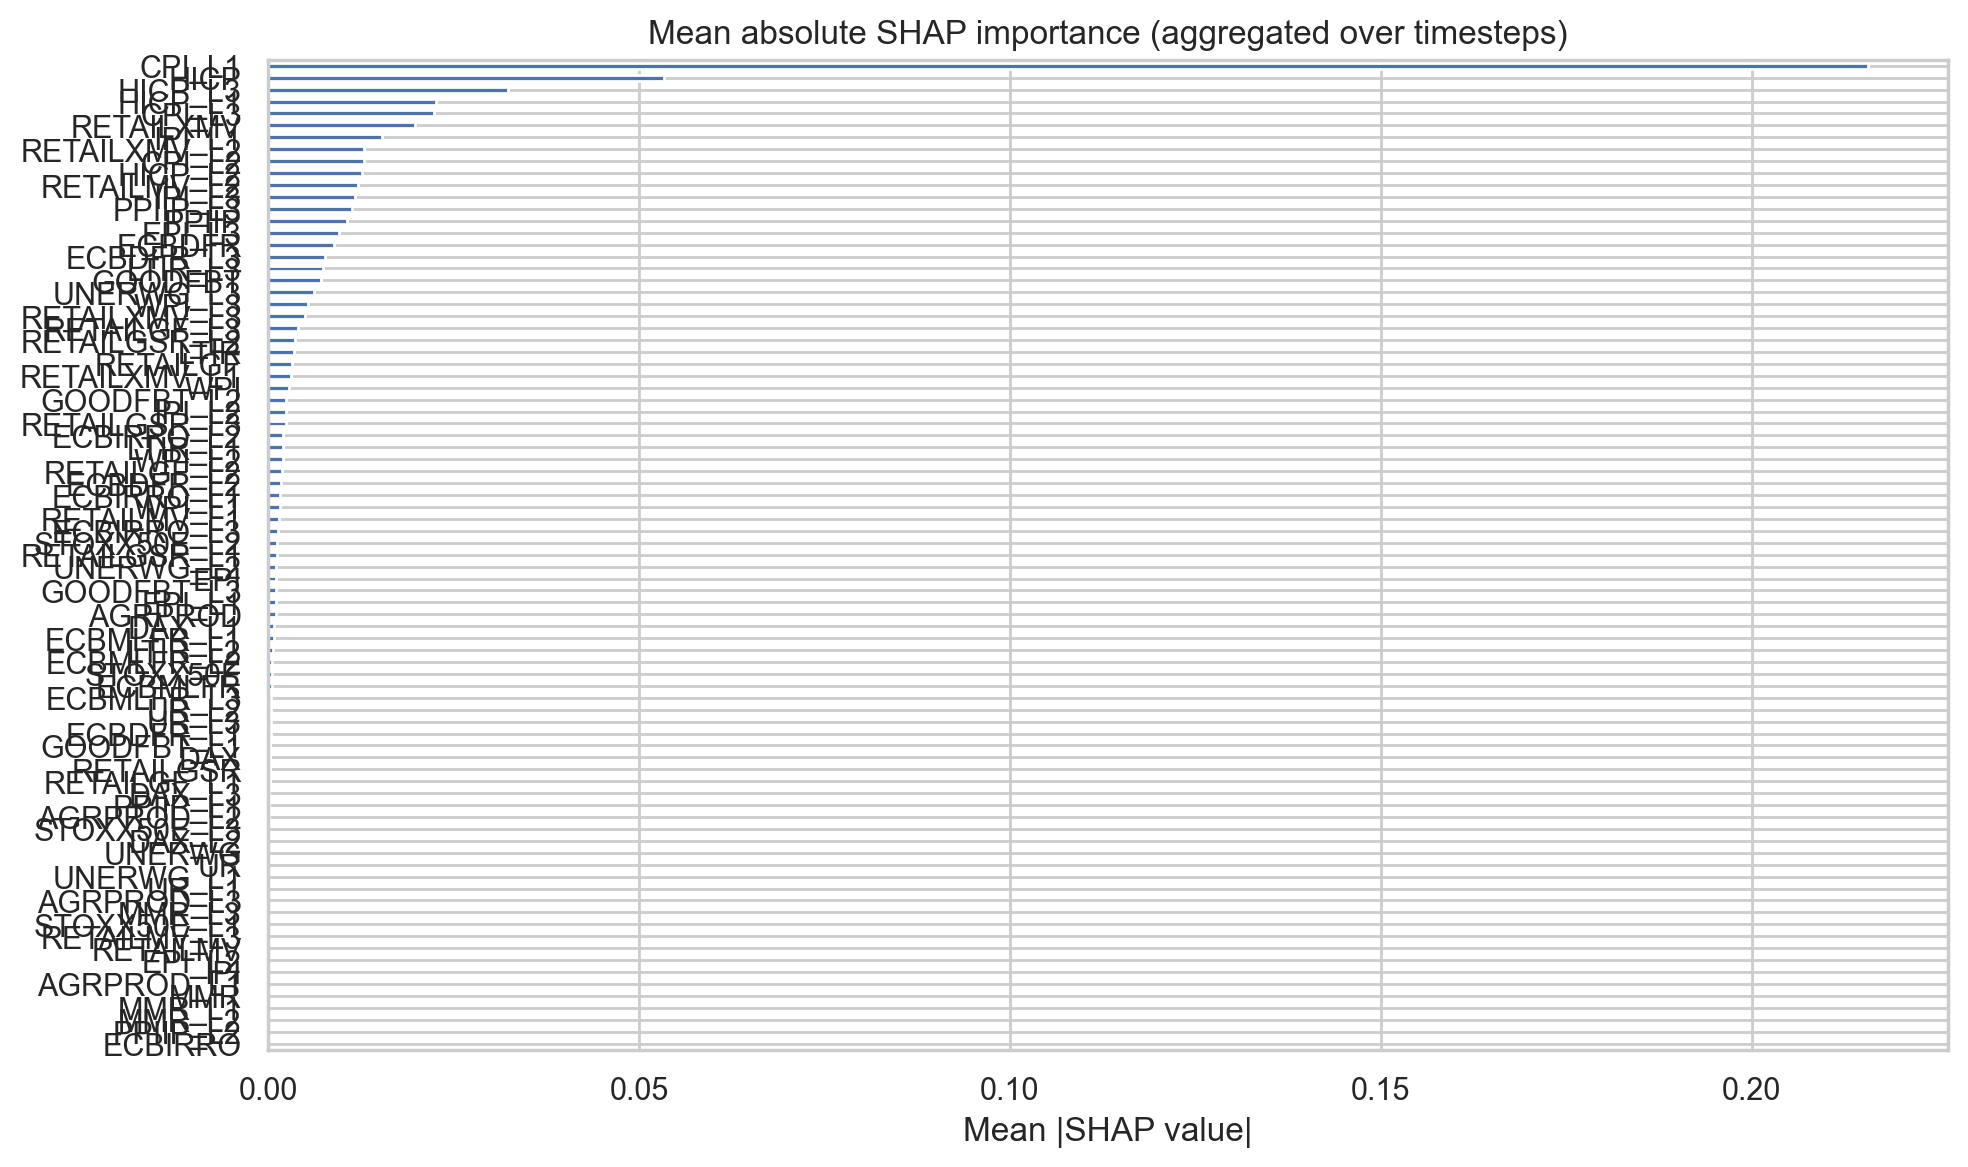

In [404]:
shap_values_3l, feature_names_3l = shappy(model_CL1D_3l, X_test_CL1D_3l, fnames_CL1D_3l)

# ***Top Influential Variables***

In [374]:
# Compute mean absolute SHAP values for each feature
shap_importance_3l = np.abs(shap_values_3l).mean(axis=0)

# Create a dictionary mapping feature names to their importance
shap_importance_dict_3l = dict(zip(feature_names_3l, shap_importance_3l))

# Sort features by importance (descending order)
sorted_features_3lags = sorted(shap_importance_dict_3l, key=shap_importance_dict_3l.get, reverse=True)

# Convert the dictionary to a list of (feature, importance) tuples
shap_importance_list_3l = list(shap_importance_dict_3l.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
shap_importance_list_3l.sort(key=lambda item: item[1], reverse=True)


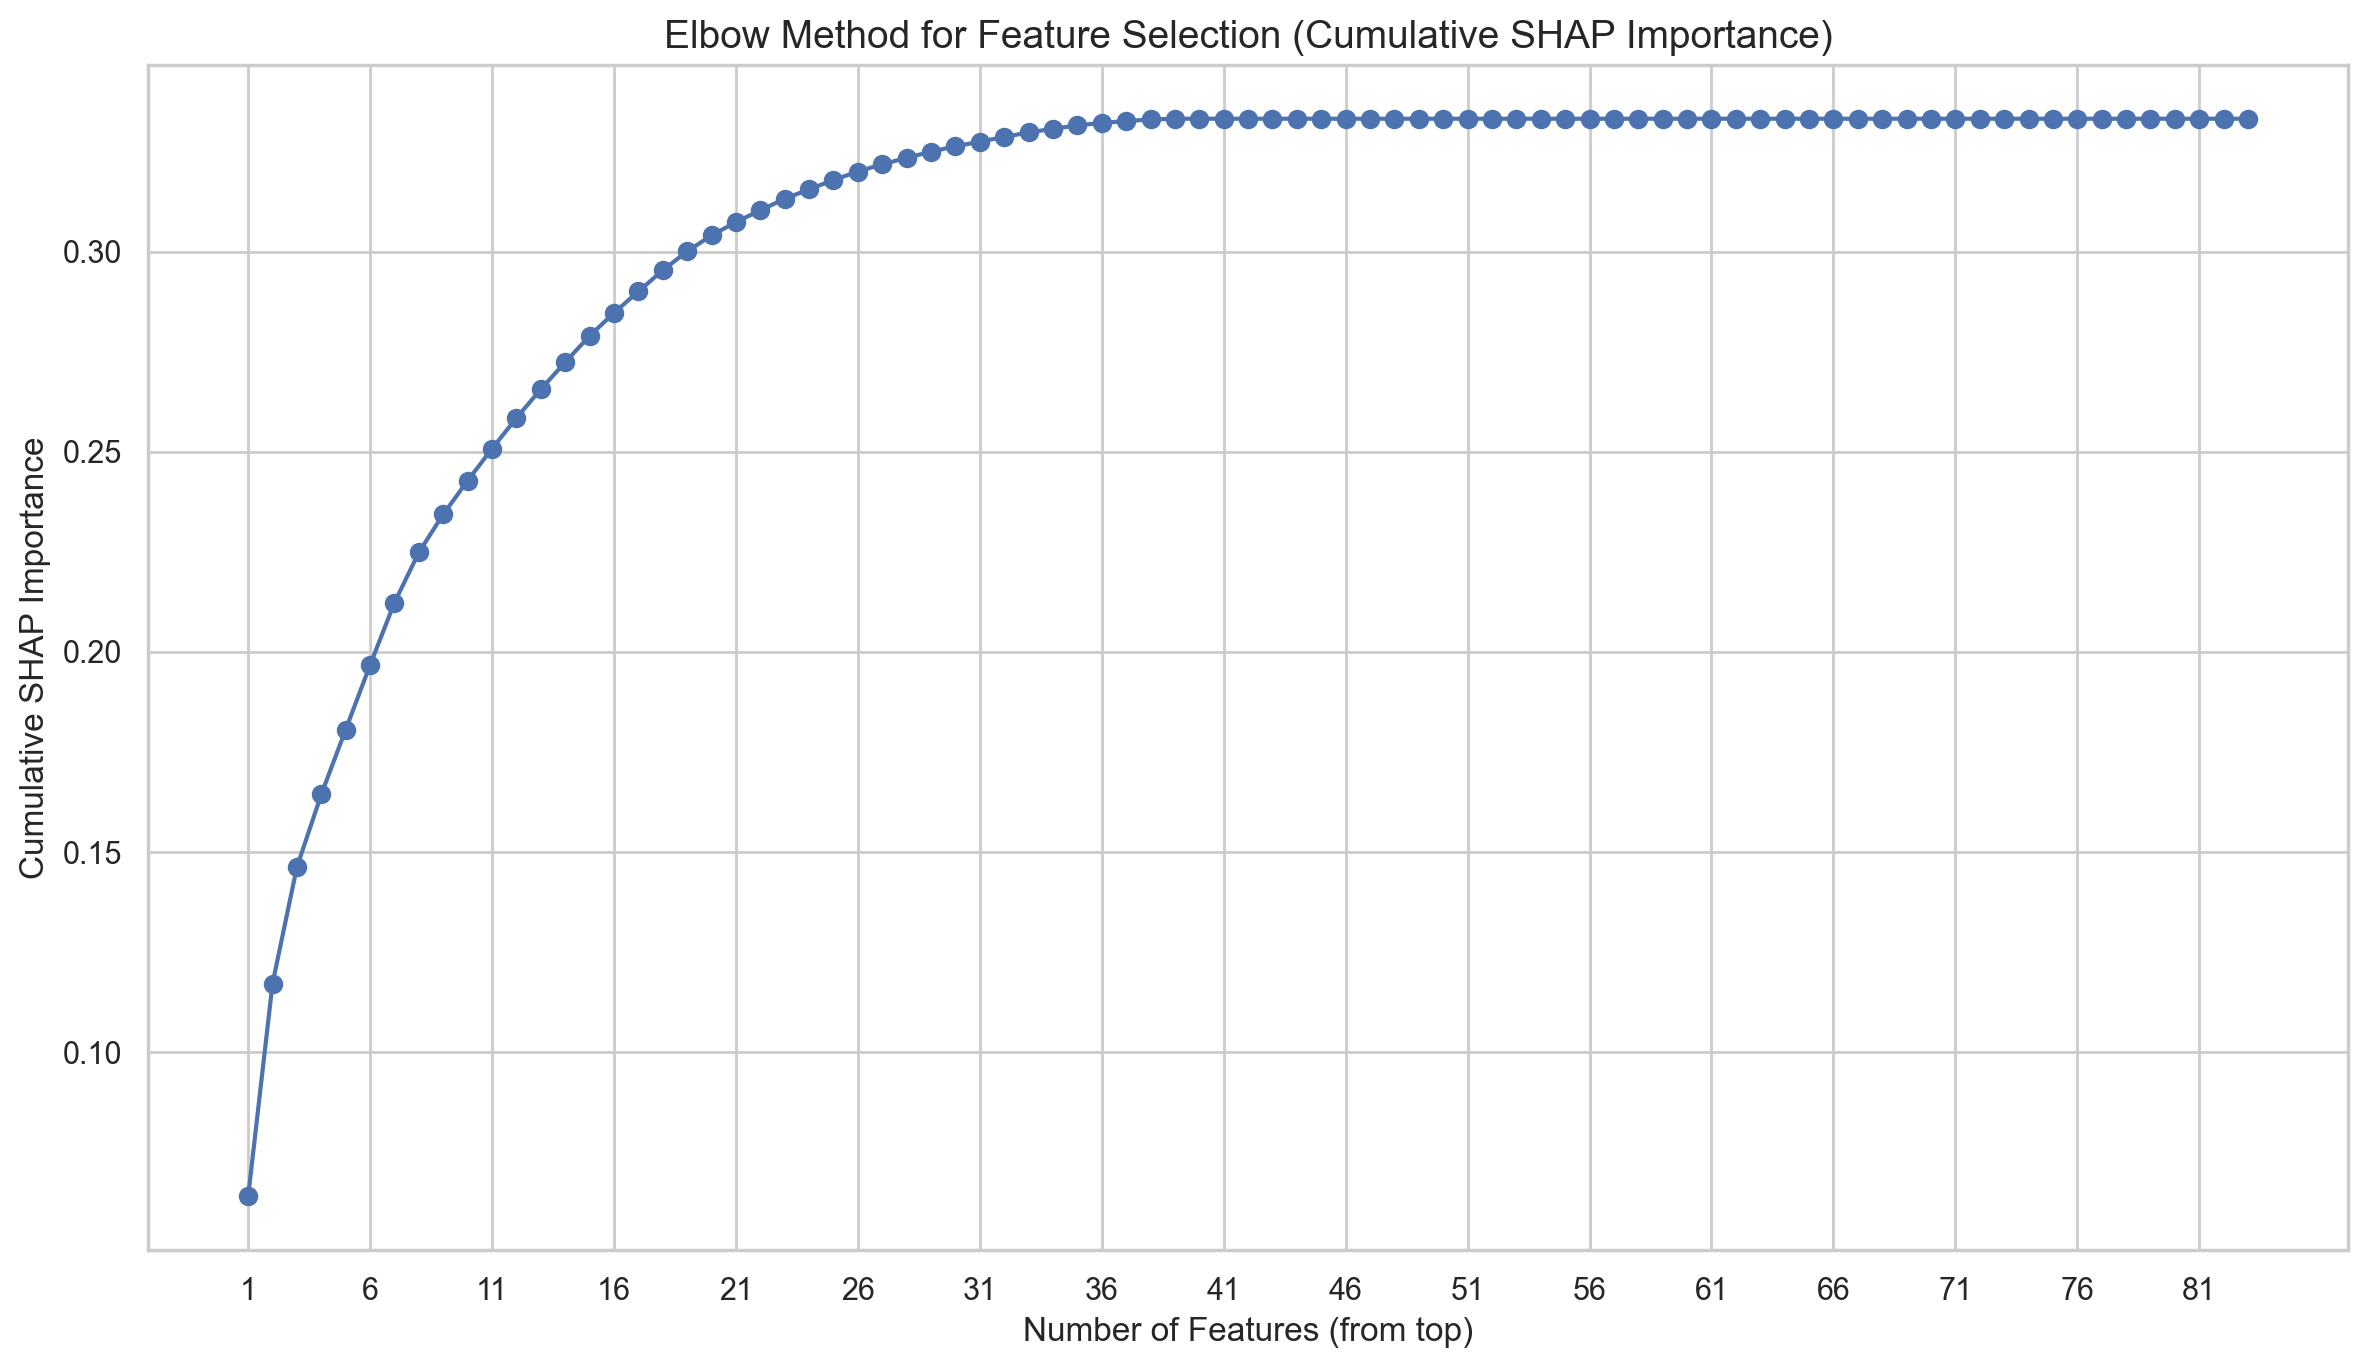

In [375]:
# Extract importance values
importance_values_3l = [item[1] for item in shap_importance_list_3l]

# Calculate cumulative importance
cumulative_importance = [sum(importance_values_3l[:i+1]) for i in range(len(importance_values_3l))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(importance_values_3l) + 1), cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(importance_values_3l) + 1, 5))

plt.tight_layout()
plt.show()

In [405]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
top_3lags_influential_variables = np.array(sorted_features_3lags)[:53]

# Print the top influential variables
print("*** Top 26 influential variables based on elbow ***")
print(top_3lags_influential_variables)
print("*** All variables sorted in order of influence ***")
print(sorted_features_3lags)

*** Top 26 influential variables based on elbow ***
['UNERWG_L3' 'STOXX50E_L1' 'ECBDFR_L3' 'ECBDFR_L1' 'IPI_L3' 'RETAILGF_L3'
 'CPI_L3' 'UR_L3' 'AGRPROD_L3' 'UR_L1' 'IPI_L2' 'ECBIRRO_L1' 'PPIIP_L1'
 'RETAILMV_L1' 'RETAILGF_L2' 'STOXX50E_L2' 'HICP_L1' 'RETAILGSR_L1'
 'LTIR_L1' 'GOODFBT_L1' 'RETAILMV_L3' 'STOXX50E' 'UNERWG_L2' 'DAX_L2'
 'HICP_L3' 'RETAILXMV_L1' 'WPI_L1' 'IPI_L1' 'EPI' 'ECBDFR_L2' 'MMR_L3'
 'DAX_L1' 'HICP' 'UNERWG_L1' 'STOXX50E_L3' 'ECBMLFR_L3' 'RETAILXMV_L3'
 'WPI_L2' 'RETAILXMV' 'CPI_L1' 'RETAILXMV_L2' 'HICP_L2' 'RETAILMV_L2'
 'PPIIP' 'CPI_L2' 'PPIIP_L3' 'ECBDFR' 'LTIR_L3' 'GOODFBT' 'LTIR' 'EPI_L3'
 'WPI_L3' 'RETAILGSR_L2']
*** All variables sorted in order of influence ***
['UNERWG_L3', 'STOXX50E_L1', 'ECBDFR_L3', 'ECBDFR_L1', 'IPI_L3', 'RETAILGF_L3', 'CPI_L3', 'UR_L3', 'AGRPROD_L3', 'UR_L1', 'IPI_L2', 'ECBIRRO_L1', 'PPIIP_L1', 'RETAILMV_L1', 'RETAILGF_L2', 'STOXX50E_L2', 'HICP_L1', 'RETAILGSR_L1', 'LTIR_L1', 'GOODFBT_L1', 'RETAILMV_L3', 'STOXX50E', 'UNERWG_L2', 'DAX_L

  0%|          | 0/34 [00:00<?, ?it/s]

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_3547/3649955827.py:117: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)


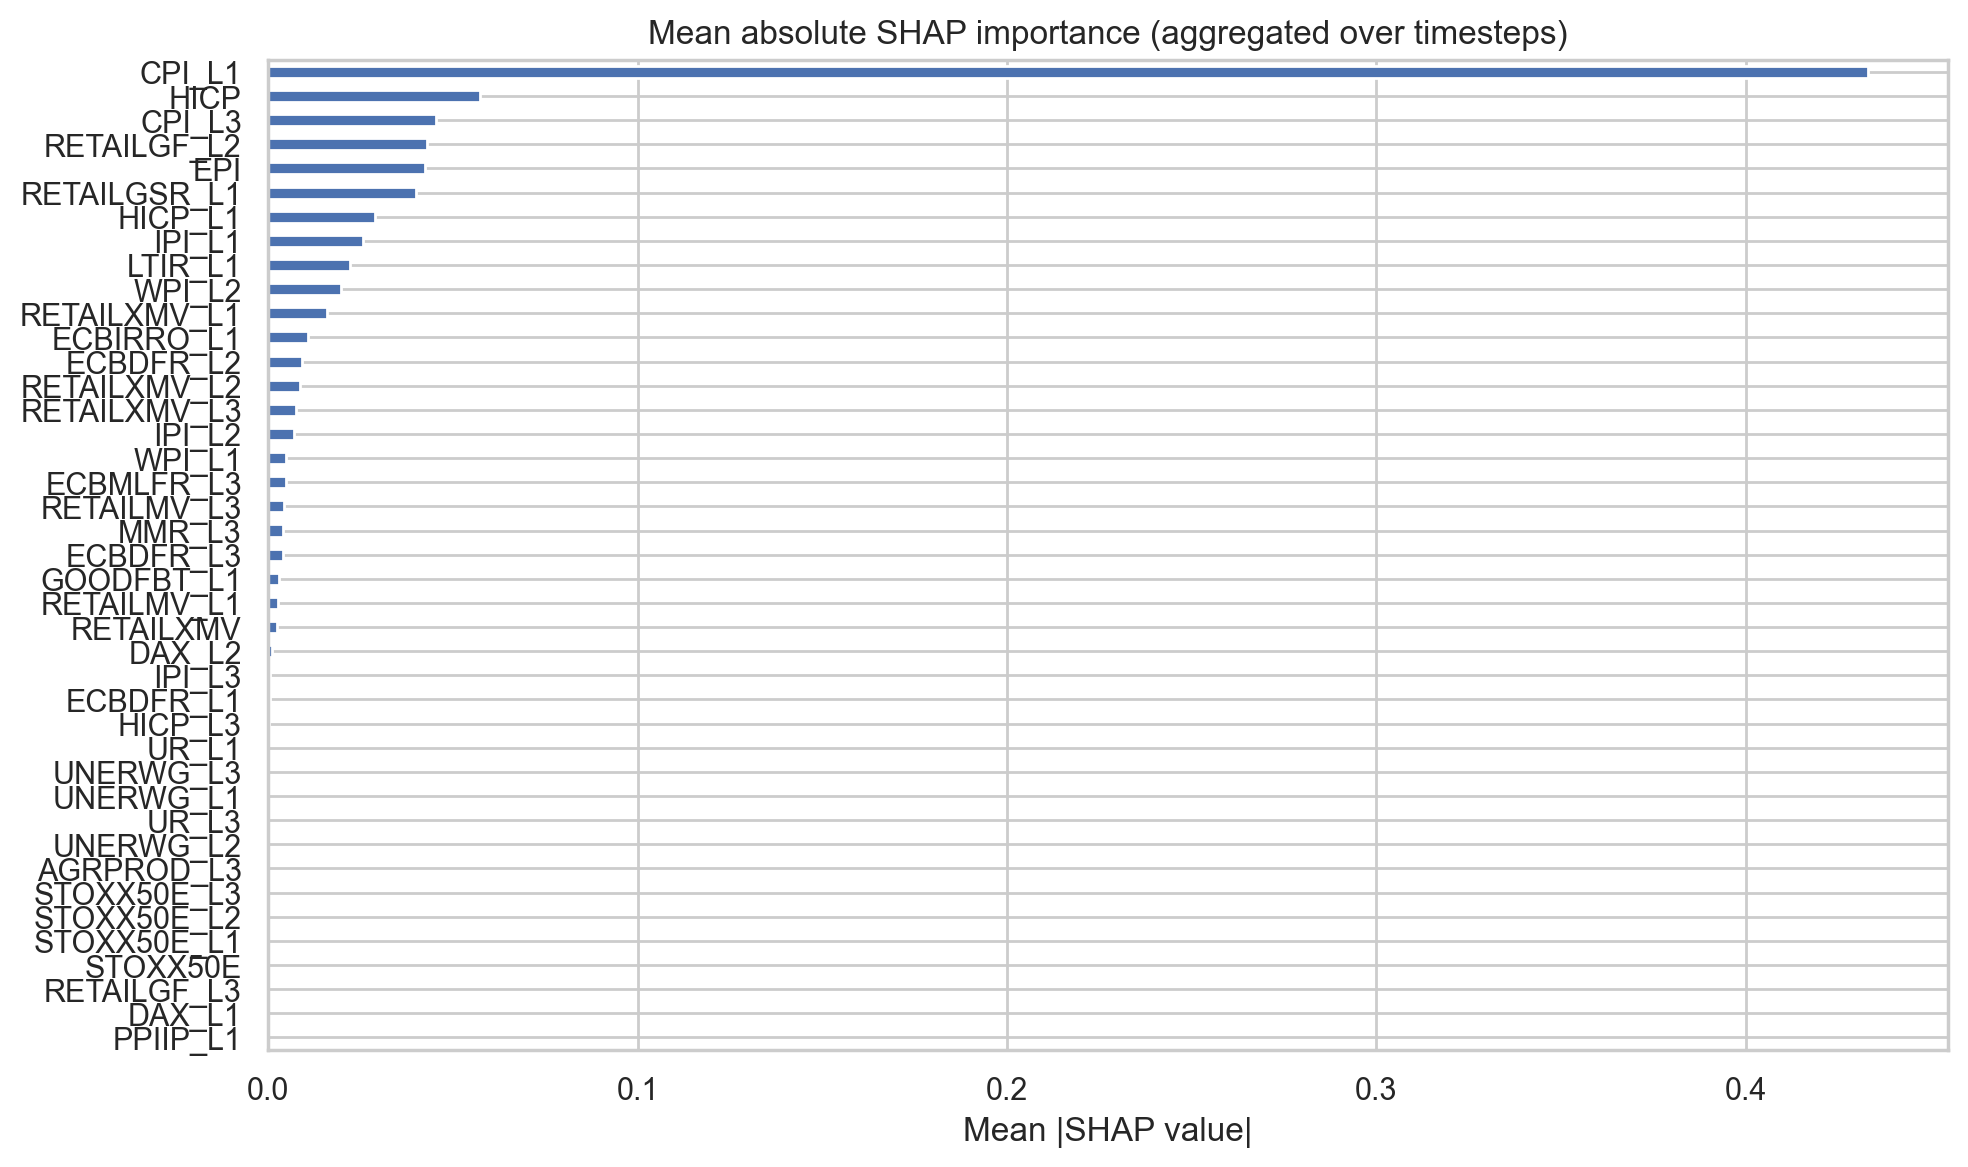

In [406]:
model_C1D_acf_shap_values, feature_names = shappy(model_C1D_acf, X_test_C1D_acf, fnames_C1D_acf)


In [376]:
# Compute mean absolute SHAP values for each feature
acf_shap_shap_importance = np.abs(model_C1D_acf_shap_values).mean(axis=0)

# Create a dictionary mapping feature names to their importance
acf_shap_importance_dict = dict(zip(feature_names, acf_shap_shap_importance))

# Sort features by importance (descending order)
acf_sorted_features = sorted(acf_shap_importance_dict, key=acf_shap_importance_dict.get, reverse=True)

# Convert the dictionary to a list of (feature, importance) tuples
acf_shap_importance_list = list(acf_shap_importance_dict.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
acf_shap_importance_list.sort(key=lambda item: item[1], reverse=True)


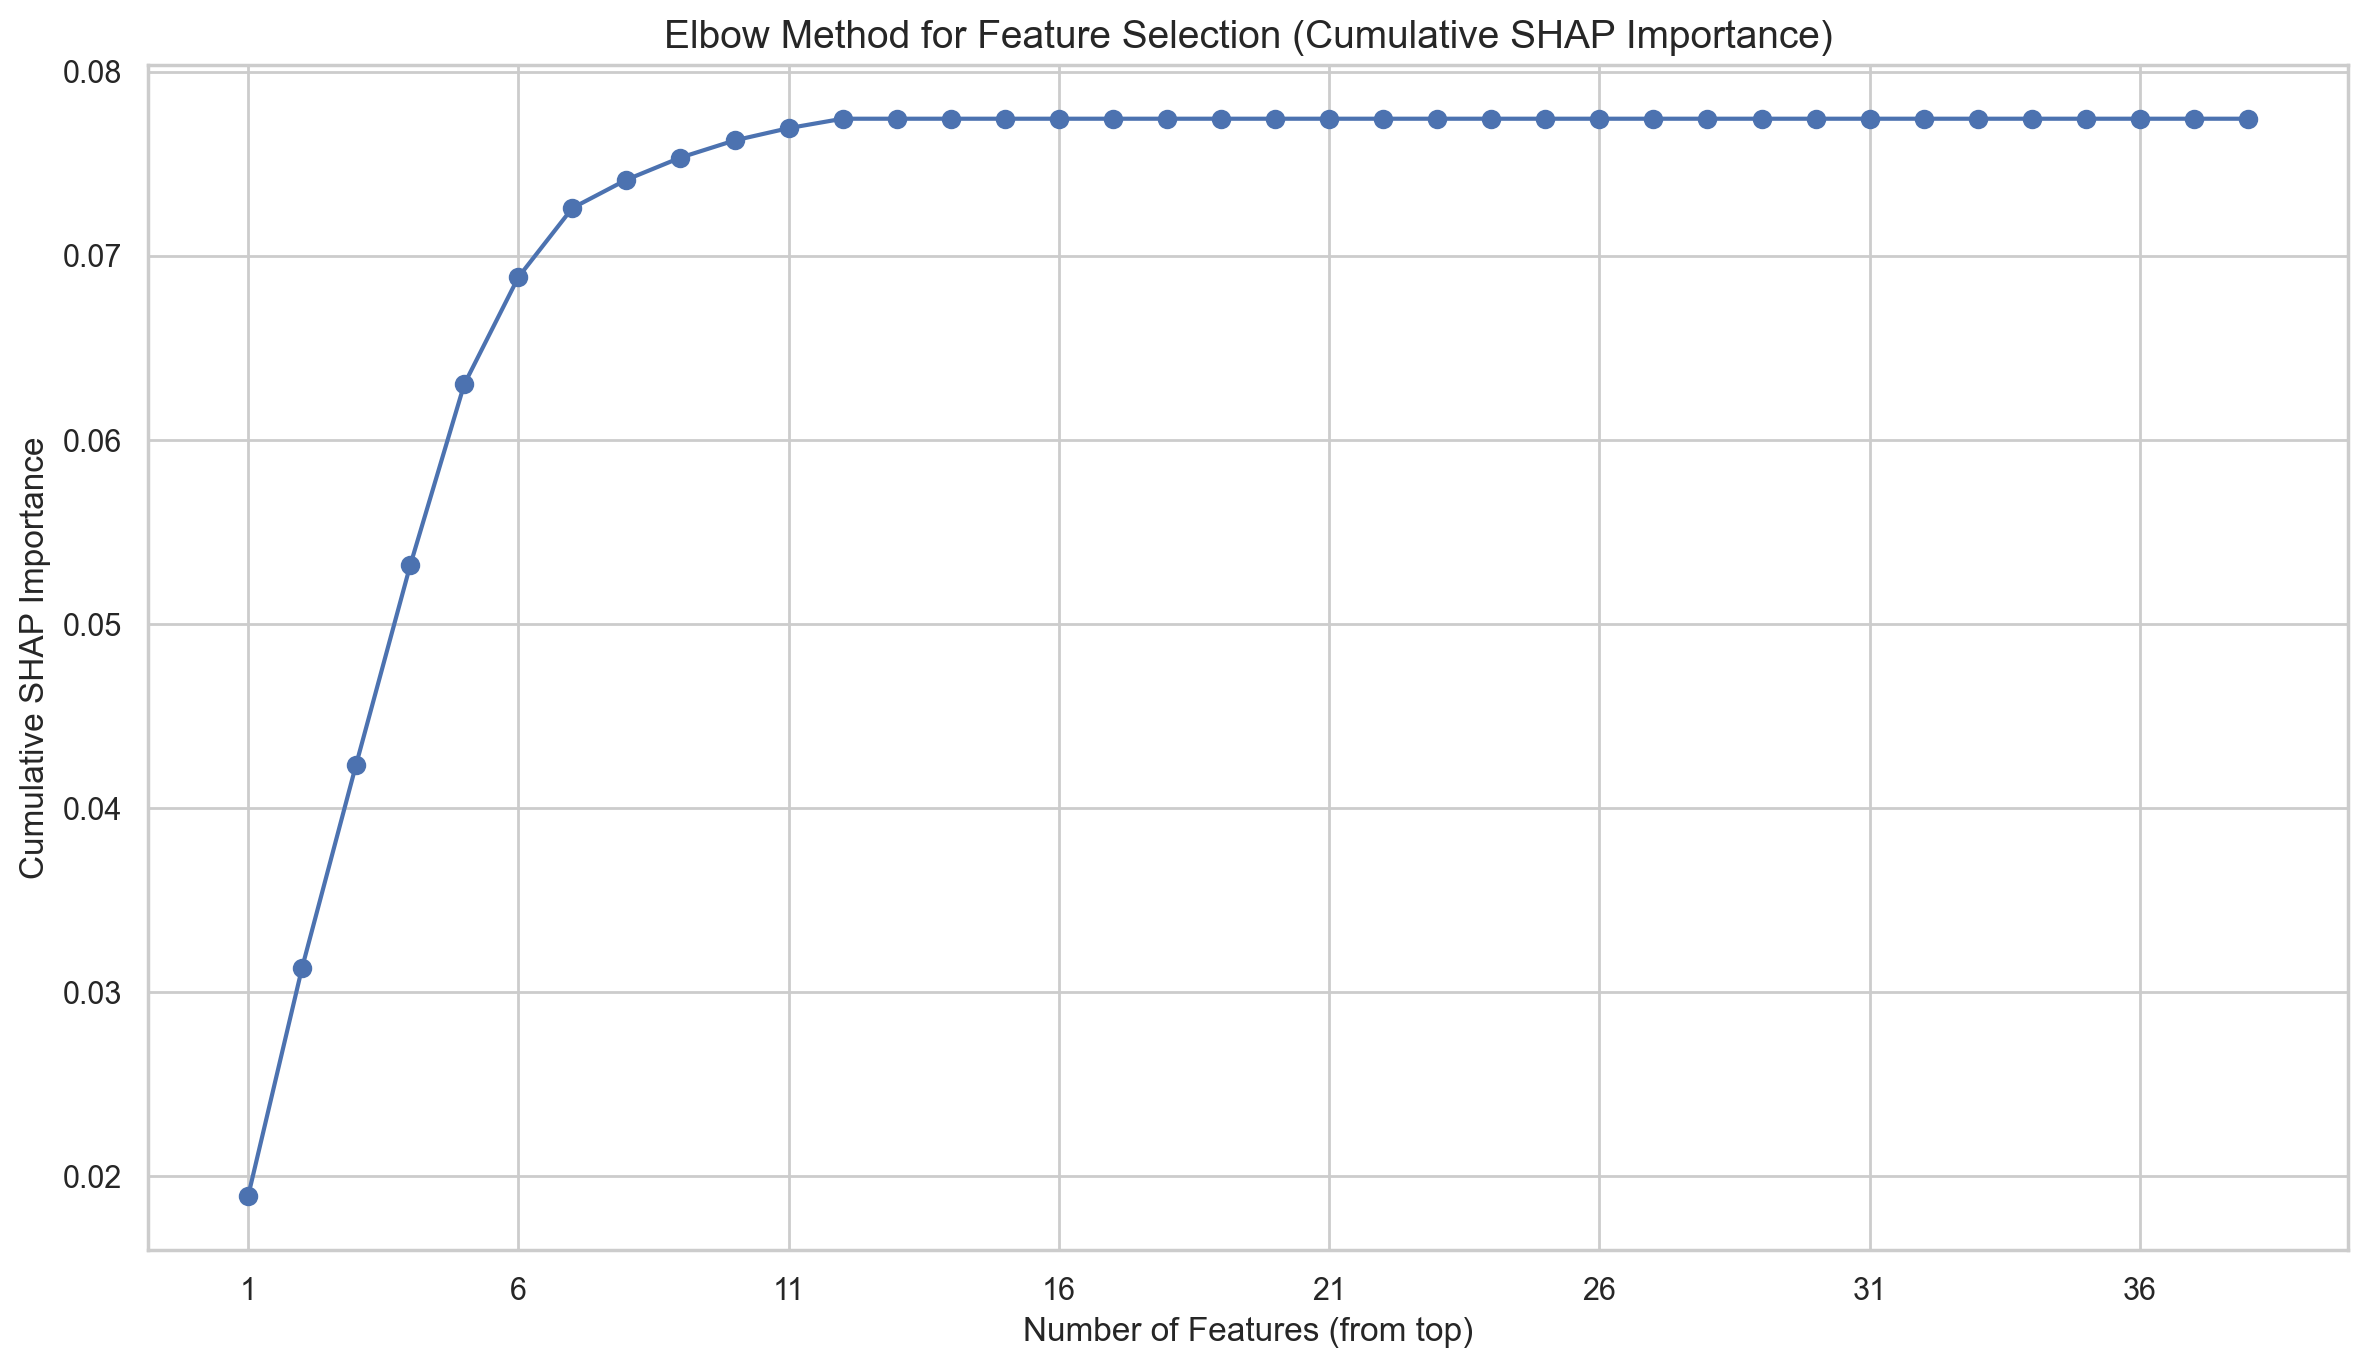

In [377]:
# Extract importance values
acf_importance_values = [item[1] for item in acf_shap_importance_list]

# Calculate cumulative importance
acf_cumulative_importance = [sum(acf_importance_values[:i+1]) for i in range(len(acf_importance_values))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(acf_importance_values) + 1), acf_cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(acf_importance_values) + 1, 5))

plt.tight_layout()
plt.show()

In [396]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
top_acf_influential_variables = np.array(acf_sorted_features)[:16]
# Print the top influential variables
print("*** Top 16 influential variables based on elbow ***")
print(top_acf_influential_variables)
print("*** All variables sorted in order of influence ***")
print(acf_sorted_features)

*** Top 16 influential variables based on elbow ***
['STOXX50E' 'ECBDFR' 'CPI_L25' 'PPIIP' 'CPI_L37' 'RETAILXMV' 'RETAILGSR'
 'UR' 'CPI_L24' 'CPI_L8' 'CPI_L23' 'AGRPROD' 'HICP' 'CPI_L1' 'RETAILGF'
 'CPI_L2']
*** All variables sorted in order of influence ***
['STOXX50E', 'ECBDFR', 'CPI_L25', 'PPIIP', 'CPI_L37', 'RETAILXMV', 'RETAILGSR', 'UR', 'CPI_L24', 'CPI_L8', 'CPI_L23', 'AGRPROD', 'HICP', 'CPI_L1', 'RETAILGF', 'CPI_L2', 'CPI_L12', 'CPI_L11', 'WPI', 'RETAILMV', 'CPI_L9', 'IPI', 'CPI_L10', 'EPI', 'CPI_L3', 'CPI_L36', 'UNERWG', 'CPI_L35', 'CPI_L7', 'GOODFBT', 'CPI_L5', 'CPI_L6', 'MMR', 'LTIR', 'ECBMLFR', 'ECBIRRO', 'CPI_L4', 'DAX']


# ***Robust Test***

# ***ALL Models***

In [422]:


def train_and_evaluate_arima_model(data, auto_arima_model, title='ARIMA: Observed vs Fitted', target_column=target, test_size=test_size):

    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series
    train_series = train_df[target_column]
    test_series = test_df[target_column]

    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()

    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=test_size)

    # Build output DataFrame
    forecast_index = test_series.index[:test_size]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:test_size]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))
    abs_error = np.abs(actual_series.values - forecast_df[target].values)
    return mae, rmse, abs_error

def train_eval_convlstm2D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size)
    model = build_model_convlstm2D(input_shape)
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def train_eval_conv1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size)
    model = build_model_conv1D(input_shape)
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def train_eval_convlstm1D(data, target, test_size=test_size):
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size)
    model = build_model_convlstm1D((X_train.shape[1], X_train.shape[2]))
    mae, rmse, abs_error = model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y)
    return mae, rmse, abs_error

def model_handler_robust(model, X_train, y_train, X_test, y_test, scaler_y):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    abs_error = np.abs(y_test_actual.flatten() - predictions_actual.flatten())
    return mae, rmse, abs_error

def train_and_evaluate_var_model(data, lag_order, test_size):
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Fit the VAR model
    model = VAR(train_df)
    var_model = model.fit(lag_order)

    input_data = train_df.values[-lag_order:]
    forecast = var_model.forecast(y=input_data, steps=test_size)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # Extract actual and forecasted values for CPI
    actual_cpi = test_df[target]
    forecasted_cpi = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))
    var_abs_error = np.abs(actual_cpi.values - forecasted_cpi.values)
    return mae, rmse, var_abs_error

def train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size, target_column=target):

    # Extract target series for SARIMA
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series for SARIMA
    train_cpi_arima = train_df[target_column]
    test_cpi_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_cpi_arima.index = pd.to_datetime(train_cpi_arima.index)

    history = train_cpi_arima.tolist()
    sarima_model = SARIMAX(history,
                           order=auto_arima_model_sarima.order,
                           seasonal_order=auto_arima_model_sarima.seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)
    forecast_df = pd.DataFrame(forecast, index=test_cpi_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpi_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpi_arima, forecast_df[target_column]))
    forecasted_cpi = forecast_df[target_column]
    abs_error = np.abs(test_cpi_arima.values - forecasted_cpi.values)
    return mae_sarima, rmse_sarima, abs_error


# 100 Subsample run

In [423]:
series_name = "dfCPI_full_dataset_subsample"

# Column Definitions

In [424]:
main_nfe_cols = main_vars_cols
main_plus_3lags_cols = feature_3_lags_cols
main_plus_cpi_acf_pcf_lags_cols = main_nfe_cols + cpi_acf_pacf_lag_cols
main_top_IV_3_lags_cols = np.append(top_3lags_influential_variables, target)
main_top_IV_acf_pacf_cols = np.append(top_acf_influential_variables, target)
main_vae_cols = vae_cpi_cols
test_size = 12

Error Arrays

In [425]:
var_maes = []
var_rmses = []
var_all_forecasts = []

arima_maes = []
arima_rmses = []
arima_all_forecasts = []

sarima_maes = []
sarima_rmses = []
sarima_all_forecasts = []

c1D_nfe_maes = []
c1D_nfe_rmses = []
c1D_nfe_all_predictions = []

cl1D_nfe_maes = []
cl1D_nfe_rmses = []
cl1D_nfe_all_predictions = []

cl1D_acf_maes = []
cl1D_acf_rmses = []
cl1D_acf_all_predictions = []

cl1D_acf_shap_maes = []
cl1D_acf_shap_rmses = []
cl1D_acf_shap_all_predictions = []

cl1D_3lags_maes = []
cl1D_3lags_rmses = []
cl1D_3lags_all_predictions = []

cl1D_3lags_shap_maes = []
cl1D_3lags_shap_rmses = []
cl1D_3lags_shap_all_predictions = []

cl2D_nfe_maes = []
cl2D_nfe_rmses = []
cl2D_nfe_all_predictions = []

cl2D_vae_maes = []
cl2D_vae_rmses = []
cl2D_vae_all_predictions = []



In [426]:
# Pre-load all data
all_data_dict = {}
print("Loading all CSVs into memory...")
for i in tqdm(range(100), desc="Loading data"):
    filename = f"{series_name}_{i + 1}.csv"
    file_path = os.path.join(all_Series_CPI_target_dir, filename)
    df = pd.read_csv(file_path, index_col = 0)
    df.index.name = 'DATE' # Set the name of the index
    all_data_dict[i + 1] = df
print("All CSVs loaded.\n")

Loading all CSVs into memory...


Loading data: 100%|██████████| 100/100 [00:00<00:00, 252.14it/s]

All CSVs loaded.



In [ ]:

for i in tqdm(range(100), desc="Processing models"):
    # filename = f"{series_name}_{i + 1}.csv"
    # file_path = os.path.join(all_LagsCPI_Dir, filename)
    # data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = all_data_dict[i + 1]
    base_data = data[main_nfe_cols]
    data_acf_pacf = data[main_plus_cpi_acf_pcf_lags_cols]
    data_3lags = data[main_plus_3lags_cols]
    data_acf_pacf_shap = data_acf_pacf[main_top_IV_acf_pacf_cols]
    data_3lags_shap = data_3lags[main_top_IV_3_lags_cols]
    data_vae = data[main_vae_cols]

    # VAR
    var_mae, var_rmse, var_forecasted_cpi = train_and_evaluate_var_model(base_data, var_lag_order, test_size=test_size)
    var_maes.append(var_mae)
    var_rmses.append(var_rmse)
    var_all_forecasts.append(var_forecasted_cpi)

    # ARIMA
    arima_mae, arima_rmse, arima_forecasted = train_and_evaluate_arima_model(base_data, auto_arima_model_arima, test_size=test_size)
    arima_maes.append(arima_mae)
    arima_rmses.append(arima_rmse)
    arima_all_forecasts.append(arima_forecasted)

    # SARIMA
    sarima_mae, sarima_rmse, sarima_forecasted_cpi = train_and_evaluate_sarima_model(base_data, auto_arima_model_sarima, test_size, target_column=target)
    sarima_maes.append(sarima_mae)
    sarima_rmses.append(sarima_rmse)
    sarima_all_forecasts.append(sarima_forecasted_cpi)

    # CONV1D NFE
    c1D_nfe_mae, c1D_nfe_rmse, c1D_nfe_all_prediction = train_eval_conv1D(base_data, target, test_size=test_size)
    c1D_nfe_maes.append(c1D_nfe_mae)
    c1D_nfe_rmses.append(c1D_nfe_rmse)
    c1D_nfe_all_predictions.append(c1D_nfe_all_prediction)

    # CONVLSTM1D NFE
    cl1D_nfe_mae, cl1D_nfe_rmse, cl1D_nfe_all_prediction = train_eval_convlstm1D(base_data, target, test_size=test_size)
    cl1D_nfe_maes.append(cl1D_nfe_mae)
    cl1D_nfe_rmses.append(cl1D_nfe_rmse)
    cl1D_nfe_all_predictions.append(cl1D_nfe_all_prediction)

    # CONVLSTM1D ACF/PACF LAGS
    cl1D_acf_mae, cl1D_acf_rmse, cl1D_acf_all_prediction = train_eval_convlstm1D(data_acf_pacf, target, test_size=test_size)
    cl1D_acf_maes.append(cl1D_acf_mae)
    cl1D_acf_rmses.append(cl1D_acf_rmse)
    cl1D_acf_all_predictions.append(cl1D_acf_all_prediction)

    # CONVLSTM1D ACF/PACF LAGS + SHAP
    cl1D_acf_shap_mae, cl1D_acf_shap_rmse, cl1D_acf_shap_all_prediction = train_eval_convlstm1D(data_acf_pacf_shap, target, test_size=test_size)
    cl1D_acf_shap_maes.append(cl1D_acf_shap_mae)
    cl1D_acf_shap_rmses.append(cl1D_acf_shap_rmse)
    cl1D_acf_shap_all_predictions.append(cl1D_acf_shap_all_prediction)

    # CONVLSTM1D 3 LAGS
    cl1D_3lags_mae, cl1D_3lags_rmse, cl1D_3lags_all_prediction = train_eval_convlstm1D(data_3lags, target, test_size=test_size)
    cl1D_3lags_maes.append(cl1D_3lags_mae)
    cl1D_3lags_rmses.append(cl1D_3lags_rmse)
    cl1D_3lags_all_predictions.append(cl1D_3lags_all_prediction)

    # CONVLSTM1D 3 LAGS + SHAP
    cl1D_3lags_shap_mae, cl1D_3lags_shap_rmse, cl1D_3lags_shap_all_prediction = train_eval_convlstm1D(data_3lags_shap, target, test_size=test_size)
    cl1D_3lags_shap_maes.append(cl1D_3lags_shap_mae)
    cl1D_3lags_shap_rmses.append(cl1D_3lags_shap_rmse)
    cl1D_3lags_shap_all_predictions.append(cl1D_3lags_shap_all_prediction)

    # CONVLSTM2D NFE
    cl2D_nfe_mae, cl2D_nfe_rmse, cl2D_nfe_all_prediction = train_eval_convlstm2D(base_data, target, test_size=test_size)
    cl2D_nfe_maes.append(cl2D_nfe_mae)
    cl2D_nfe_rmses.append(cl2D_nfe_rmse)
    cl2D_nfe_all_predictions.append(cl2D_nfe_all_prediction)

    # CONVLSTM2D VAE
    cl2D_vae_mae, cl2D_vae_rmse, cl2D_vae_all_prediction = train_eval_convlstm2D(data_vae, target, test_size=test_size)
    cl2D_vae_maes.append(cl2D_vae_mae)
    cl2D_vae_rmses.append(cl2D_vae_rmse)
    cl2D_vae_all_predictions.append(cl2D_vae_all_prediction)




# Save Results

In [431]:
print("VAR")
print(np.mean(var_all_forecasts[0]))
print("C1D_NFE")
print(np.mean(c1D_nfe_all_predictions[0]))
print("SARIMA")
print(np.mean(sarima_all_forecasts[0]))
print("ARIMA")
print(np.mean(arima_all_forecasts[0]))
print("CNN ACF PACF")
print(np.mean(cl1D_acf_all_predictions[0]))
print("CNN ACF SHAP")
print(np.mean(cl1D_acf_shap_all_predictions[0]))
print("CL1D_NFE")
print(np.mean(cl1D_nfe_all_predictions[0]))
print("CL1D_3LAGS")
print(np.mean(cl1D_3lags_all_predictions[0]))
print("CL1D_3LAGS_SHAP")
print(np.mean(cl1D_3lags_shap_all_predictions[0]))
print("CL2D_NFE")
print(np.mean(cl2D_nfe_all_predictions[0]))
print("CL2D_VAE")
print(np.mean(cl2D_vae_all_predictions[0]))


VAR
0.9840186697281839
C1D_NFE
0.7419479751194888
SARIMA
0.4646225341325152
ARIMA
0.8769058837215277
CNN ACF PACF
0.288431025623665
CNN ACF SHAP
0.3036614611223141
CL1D_NFE
0.7282223767767722
CL1D_3LAGS
0.41310781770297994
CL1D_3LAGS_SHAP
0.3726618982748886
CL2D_NFE
0.7976900252059758
CL2D_VAE
1.0676745348274148


In [440]:
# Directory to save output
output_dir = "cpi_model_results"
os.makedirs(output_dir, exist_ok=True)

# Model data
model_results = {
    "VAR": (var_maes, var_rmses, var_all_forecasts),
    "ARIMA": (arima_maes, arima_rmses, arima_all_forecasts),
    "SARIMA": (sarima_maes, sarima_rmses, sarima_all_forecasts),
    "C1D-NFE": (c1D_nfe_maes, c1D_nfe_rmses, c1D_nfe_all_predictions),
    "CL1D-NFE": (cl1D_nfe_maes, cl1D_nfe_rmses, cl1D_nfe_all_predictions),
    "CL1D-ACF": (cl1D_acf_maes, cl1D_acf_rmses, cl1D_acf_all_predictions),
    "CL1D-ACF-SHAP": (cl1D_acf_shap_maes, cl1D_acf_shap_rmses, cl1D_acf_shap_all_predictions),
    "CL1D-3LAGS": (cl1D_3lags_maes, cl1D_3lags_rmses, cl1D_3lags_all_predictions),
    "CL1D-3LAGS-SHAP": (cl1D_3lags_shap_maes, cl1D_3lags_shap_rmses, cl1D_3lags_shap_all_predictions),
    "CL2D-NFE": (cl2D_nfe_maes, cl2D_nfe_rmses, cl2D_nfe_all_predictions),
    "CL2D-VAE": (cl2D_vae_maes, cl2D_vae_rmses, cl2D_vae_all_predictions),
}


# Save MAEs
mae_df = pd.DataFrame({model: maes for model, (maes, _, _) in model_results.items()})
mae_df.index.name = "Iteration"
mae_df.to_csv(os.path.join(output_dir, "all_mae.csv"))

# Save RMSEs
rmse_df = pd.DataFrame({model: rmses for model, (_, rmses, _) in model_results.items()})
rmse_df.index.name = "Iteration"
rmse_df.to_csv(os.path.join(output_dir, "all_rmse.csv"))

# Save Forecasts (wide format)
forecast_wide = pd.DataFrame()
for model, (_, _, forecasts) in model_results.items():
    forecasts_array = np.squeeze(np.array(forecasts))
    col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
    forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
    forecast_wide = pd.concat([forecast_wide, forecast_df], axis=1)

# for model, (_, _, forecasts) in model_results.items():
#     # Extract the single array inside the list
#     if isinstance(forecasts, list) and len(forecasts) == 1 and isinstance(forecasts[0], np.ndarray):
#         forecasts_array = forecasts[0].reshape(1, -1)  # Make it (1, 12)
#     else:
#         raise ValueError(f"Unexpected format for forecasts in model {model}: {type(forecasts)}")
#
#     # Create column names
#     col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
#
#     # Convert to DataFrame and concatenate
#     forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
#     forecast_wide = pd.concat([forecast_wide, forecast_df], axis=1)


forecast_wide.index.name = "Iteration"
forecast_wide.to_csv(os.path.join(output_dir, "all_forecasts.csv"))

ValueError: All arrays must be of the same length

In [444]:

forecast_wide_1 = pd.DataFrame()
for model, (_, _, forecasts) in model_results.items():
    forecasts_array = np.squeeze(np.array(forecasts))
    # Limit to first 100 iterations
    forecasts_array = forecasts_array[:100, :]
    col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
    forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
    forecast_wide_1 = pd.concat([forecast_wide_1, forecast_df], axis=1)
# Limit the DataFrame index to first 100 iterations
forecast_wide_1 = forecast_wide_1.iloc[:100, :]
forecast_wide_1.index.name = "Iteration"
forecast_wide_1.to_csv(os.path.join(output_dir, "all_forecasts.csv"))


# THE END